# Libraries & Packages

In [1]:
!pip install -q tensorflow
!pip install -q optuna tqdm
!pip install -q lime
!pip install optuna-integration[tfkeras]
!pip install optuna-integration[xgboost]

print("Packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.1 MB/s eta 0:00:00
Packages imported successfully!


In [2]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Stats Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from pandas import Timedelta
from sklearn.preprocessing import MinMaxScaler



# SHAP & LIME
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
import shap
import lime
import lime.lime_tabular


# Hyperparameter Tuning
import optuna
from sklearn.model_selection import TimeSeriesSplit
from optuna.integration import XGBoostPruningCallback
from tqdm.notebook import tqdm
from optuna.integration import TFKerasPruningCallback

# Hugging Face Datasets Library
from datasets import load_dataset

# Notebook Settings for Visualization Consistency
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# Loading the Data

In [3]:
dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K")
print(dataset)

# Access the splits and covert them to pandas df
train_df = dataset["train"].to_pandas()
test_df = dataset["eval"].to_pandas()

# To avoid data leakage during feature engineering we combine them first and will split them back later if needed for modeling.
train_df["__src"] = "train"
test_df["__src"]  = "test"
df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\nCombined DataFrame created with shape: {df.shape}")
df.head()

README.md: 0.00B [00:00, ?B/s]

data/train.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

data/eval.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4500000 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/350000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'dt', 'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level'],
        num_rows: 4500000
    })
    eval: Dataset({
        features: ['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'dt', 'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level'],
        num_rows: 350000
    })
})

Combined DataFrame created with shape: (4850000, 20)


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level,__src
0,0,0,0,5,6,65,38,2024-03-28,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,1.6999,15.48,73.54,1.97,train
1,0,0,0,5,6,65,38,2024-03-29,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,3.0190,15.08,76.56,1.71,train
2,0,0,0,5,6,65,38,2024-03-30,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0,2.0942,15.91,76.47,1.73,train
3,0,0,0,5,6,65,38,2024-03-31,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",1.0,1,0,1.5618,16.13,77.40,1.76,train
4,0,0,0,5,6,65,38,2024-04-01,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",8,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,0,0,3.5386,15.37,78.26,1.25,train


# Initial Feature Engineering for EDA

In [4]:
# Creating SKU sotre combination - concatinating store and product id
df["sku_store_id"] = df["product_id"].astype(str) + "_" + df["store_id"].astype(str)

In [5]:
# Convert the date string column 'dt' to a pandas datetime object for time-series operations.
df["date"] = pd.to_datetime(df["dt"])
# Ordering required for time series data
df = df.sort_values(['sku_store_id', 'date']).reset_index(drop=True)

In [6]:
# Define the target variable for convenience
df['y'] = df['sale_amount']

## Stockout Feature Engineering

In [7]:
# given in the dataset description
open_hours = 17

df["stockout_hours_d"] = df["stock_hour6_22_cnt"].astype(float)

# Calculate the stockout ratio
df["stockout_ratio_d"]  = df["stockout_hours_d"] / open_hours

# Create a binary flag indicating if any stockout occurred on a given day.
df["any_stockout_d"] = (df["stockout_hours_d"] > 0).astype(int)

## Date Based Feature Engineering

In [8]:
# Day of the week (0=Monday, 6=Sunday) using date col
df["dow"] = df["date"].dt.dayofweek

# Binary flag for weekends
df["is_weekend"] = (df["dow"] >= 5).astype(int)

# Week of the year, using ISO standard.
df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)

# Month of the year.
df["month"] = df["date"].dt.month

## Promotion Feature Engineering

In [9]:
conditions = [
    (df['discount'] == 1) & (df['activity_flag'] == 1), # Non-price promotion (bundles, 1+1)
    (df['discount'] < 1) & (df['activity_flag'] == 0),  # Price discount without marketing activity (about to expire products)
    (df['discount'] < 1) & (df['activity_flag'] == 1),  # Standard discount with marketing activity (25% off)
]

# Define the corresponding labels for each strategy.
choices = ['Non-Price Promo', 'Price Penetration', 'Standard Discount']

# Use np.select to create the new categorical 'promo_strategy' feature.
# The default value is 'Full Price' discount = 1 , activity_flag = 0
df['promo_strategy'] = np.select(conditions, choices, default='Full Price')

# Create an intuitive 'discount_depth' feature (e.g., 0.1 for a 10% discount).
# This is often more interpretable for models than a price multiplier.
df['discount_depth'] = 1 - df['discount']

# Creating Splits

In [10]:
# Chronological Cutoff Dates
TRAIN_END = pd.Timestamp("2024-06-10")
VAL_END   = pd.Timestamp("2024-06-25")

train_df = df.loc[df['date'] <= TRAIN_END].copy()
val_df   = df.loc[(df['date'] > TRAIN_END) & (df['date'] <= VAL_END)].copy()
test_df  = df.loc[df['date'] > VAL_END].copy()

# Feature Engineering

## Log Transformation

In [11]:
for df in [train_df, val_df, test_df]:
    df['log_y'] = np.log1p(df['y'])

## Historical Features

In [12]:
def create_historical_features(df_to_feature, history_df):

    required_history_days = 14 # more days attained to ensure enough history
    history_tail = history_df.groupby('sku_store_id').tail(required_history_days)
    combined = pd.concat([history_tail, df_to_feature], ignore_index=True)

    # We keep the 'last' occurrence, which prioritizes the data from df_to_feature.
    combined.drop_duplicates(subset=['date', 'sku_store_id'], keep='last', inplace=True)

    # The rest of the function can now proceed with the clean, de-duplicated data
    combined.sort_values(['sku_store_id', 'date'], inplace=True)
    g_combined = combined.groupby("sku_store_id", group_keys=False)


    log_y_shift = g_combined["log_y"].shift(1)
    combined["log_y_lag_1d"] = log_y_shift
    combined["log_y_lag_7d"] = g_combined["log_y"].shift(7)
    combined["log_y_roll_mean_7d"] = log_y_shift.rolling(7, min_periods=3).mean()
    combined["log_y_roll_std_7d"]  = log_y_shift.rolling(7, min_periods=3).std()

    sr_shift = g_combined["stockout_ratio_d"].shift(1)
    combined["stockout_ratio_lag1d"] = sr_shift
    combined["stockout_ratio_r7d"]   = sr_shift.rolling(7, min_periods=3).mean()

    featured_df = combined[combined['date'].isin(df_to_feature['date'])].copy()

    return featured_df

print("create_historical_features is ready to use.")

create_historical_features is ready to use.


In [13]:
# Training Set
train_df_featured = create_historical_features(train_df, train_df)


# Validation Set
val_df_featured = create_historical_features(val_df, train_df_featured)


# Test Set
full_history_for_test = pd.concat([train_df_featured, val_df_featured], ignore_index=True)
test_df_featured = create_historical_features(test_df, full_history_for_test)

## Target Encoding

In [14]:
def create_time_aware_encodings(df_to_feature, history_df, id_cols, warmup_days=7):

    # Temporarily combine the full history with the dataframe we want to feature.
    # We need the full history for a cumulative sum
    combined = pd.concat([history_df, df_to_feature], ignore_index=True)
    combined.sort_values(['product_id', 'date'], inplace=True) # Sort is essential for cumulative stats

    target_col = 'log_y'

    for col in id_cols:
        if col not in combined.columns:
            continue

        # Collapse to one row per (ID, date) to avoid same-day leakage
        daily = (
            combined[[col, 'date', target_col]]
            .groupby([col, 'date'], as_index=False, sort=False)[target_col]
            .mean()
            .sort_values('date')
        )

        # past-only cumulative logic
        g = daily.groupby(col, sort=False)[target_col]
        daily['cum_sum'] = g.cumsum().shift(1)
        daily['cum_cnt'] = g.cumcount()
        daily['enc'] = daily['cum_sum'] / daily['cum_cnt'].replace(0, np.nan)

        # Merge the encodings back to the combined dataframe
        combined = combined.merge(
            daily[[col, 'date', 'enc', 'cum_cnt']].rename(
                columns={'enc': f'{col}_target_encoded', 'cum_cnt': f'__{col}_past_days'}
            ),
            on=[col, 'date'], how='left'
        )

    # Apply warm-up filter - ensuring enough history and dropping the missing value rows
    mask = np.ones(len(combined), dtype=bool)
    for col in id_cols:
        cnt_col = f'__{col}_past_days'
        if cnt_col in combined.columns:
            # We must handle NaNs in the count column before comparison
            mask &= (combined[cnt_col].fillna(-1) >= warmup_days)

    # Filter the combined dataframe
    combined_filtered = combined[mask].copy()

    # Return only the original rows of the target dataframe, but now with features and filtered.
    featured_df = combined_filtered[combined_filtered['date'].isin(df_to_feature['date'])].copy()

    return featured_df

print("create_time_aware_encodings' is ready now.")

create_time_aware_encodings' is ready now.


## XGBoost Model Feature Engineering

### One-hot-encoding for promo strategy and day of the week

In [15]:

# Fit on the training data and transform all sets to handle categories consistently.
ohe_cols = [c for c in ['dow','promo_strategy'] if c in train_df_featured.columns]
if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

    # Fit on training data
    ohe.fit(train_df_featured[ohe_cols])

    def apply_ohe(df, encoder, cols):
        new_cols = encoder.transform(df[cols])
        new_df = pd.DataFrame(new_cols, index=df.index, columns=encoder.get_feature_names_out(cols))
        return pd.concat([df.drop(columns=cols), new_df], axis=1)

    train_df_encoded = apply_ohe(train_df_featured, ohe, ohe_cols)
    val_df_encoded = apply_ohe(val_df_featured, ohe, ohe_cols)
    test_df_encoded = apply_ohe(test_df_featured, ohe, ohe_cols)
    print("One-hot encoding complete.")
else:
    train_df_encoded = train_df_featured
    val_df_encoded = val_df_featured
    test_df_encoded = test_df_featured
    print("No columns to one-hot encode.") # to check the data


# Target Encode the Training Set
id_cols = [
    'product_id', 'store_id', 'city_id', 'management_group_id',
    'first_category_id', 'second_category_id', 'third_category_id'
]
# For the training set, its history is empty. We create a placeholder.
empty_df = train_df_encoded.head(0)

train_df_final = create_time_aware_encodings(train_df_encoded, empty_df, id_cols)

One-hot encoding complete.


In [16]:
# Transform the Validation Set
val_df_final = create_time_aware_encodings(val_df_encoded, train_df_encoded, id_cols)

In [17]:
# Transform the Test Set
full_history_for_test = pd.concat([train_df_encoded, val_df_encoded], ignore_index=True)
test_df_final = create_time_aware_encodings(test_df_encoded, full_history_for_test, id_cols)

### Sanity Check - for feature engineering

In [18]:
if not train_df_final.empty:
    print(f"Training set:   {train_df_final.shape[0]:,} rows | Dates: {train_df_final['date'].min().date()} to {train_df_final['date'].max().date()}")
else:
    print("Training set is EMPTY!")

if not val_df_final.empty:
    print(f"Validation set: {val_df_final.shape[0]:,} rows | Dates: {val_df_final['date'].min().date()} to {val_df_final['date'].max().date()}")
else:
    print("Validation set is EMPTY!")

if not test_df_final.empty:
    print(f"Test set:       {test_df_final.shape[0]:,} rows | Dates: {test_df_final['date'].min().date()} to {test_df_final['date'].max().date()}")
else:
    print("Test set is EMPTY!")

Training set:   3,400,000 rows | Dates: 2024-04-04 to 2024-06-10
Validation set: 750,000 rows | Dates: 2024-06-11 to 2024-06-25
Test set:       350,000 rows | Dates: 2024-06-26 to 2024-07-02


### Drop Redundant Features

In [18]:
# creating splits' copies in case it is needed for the analysis
train_df_analysis = train_df_final.copy()
val_df_analysis = val_df_final.copy()
test_df_analysis = test_df_final.copy()

In [19]:
columns_to_drop = [
    'city_id', 'store_id', 'management_group_id', 'first_category_id',
       'second_category_id', 'third_category_id', 'product_id', 'dt',
       'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status',
       'discount', 'activity_flag','__src','stockout_hours_d','any_stockout_d', 'is_weekend', 'week_of_year', 'month','__product_id_past_days', '__store_id_past_days', '__city_id_past_days', '__management_group_id_past_days',
    '__first_category_id_past_days', '__second_category_id_past_days', '__third_category_id_past_days'
]

# Drop columns from all three DataFrames, ignoring errors if a column was already dropped.
train_df_final.drop(columns=columns_to_drop, inplace=True, errors='ignore')
val_df_final.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_df_final.drop(columns=columns_to_drop, inplace=True, errors='ignore')


# Final df
print("\nTraining Set:")
train_df_final.info()
print("\nValidation Set:")
val_df_final.info()
print("\nTest Set:")
test_df_final.info()


Training Set:
<class 'pandas.core.frame.DataFrame'>
Index: 3400000 entries, 91 to 3749999
Data columns (total 33 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   holiday_flag                        int32         
 1   precpt                              float64       
 2   avg_temperature                     float64       
 3   avg_humidity                        float64       
 4   avg_wind_level                      float64       
 5   sku_store_id                        object        
 6   date                                datetime64[ns]
 7   y                                   float64       
 8   stockout_ratio_d                    float64       
 9   discount_depth                      float64       
 10  log_y                               float64       
 11  log_y_lag_1d                        float64       
 12  log_y_lag_7d                        float64       
 13  log_y_roll_mean_7d             

## LSTM Feature Engineering

In [15]:

# Fit on  the training data and transform all sets to handle categories consistently.
ohe_cols = [c for c in ['promo_strategy'] if c in train_df_featured.columns]
if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

    # Fit on training data
    ohe.fit(train_df_featured[ohe_cols])

    def apply_ohe(df, encoder, cols):
        new_cols = encoder.transform(df[cols])
        new_df = pd.DataFrame(new_cols, index=df.index, columns=encoder.get_feature_names_out(cols))
        return pd.concat([df.drop(columns=cols), new_df], axis=1)

    train_df_encoded = apply_ohe(train_df_featured, ohe, ohe_cols)
    val_df_encoded = apply_ohe(val_df_featured, ohe, ohe_cols)
    test_df_encoded = apply_ohe(test_df_featured, ohe, ohe_cols)
    print("One-hot encoding complete.")
else:
    train_df_encoded = train_df_featured
    val_df_encoded = val_df_featured
    test_df_encoded = test_df_featured
    print("No columns to one-hot encode.") # to check the data


# Target Encode the Training Set
id_cols = [
    'product_id', 'store_id', 'city_id', 'management_group_id',
    'first_category_id', 'second_category_id', 'third_category_id'
]
# For the training set, its history is empty. We create a placeholder.
empty_df = train_df_encoded.head(0)

train_df_final = create_time_aware_encodings(train_df_encoded, empty_df, id_cols)

One-hot encoding complete.


In [16]:
# Transform the Validation Set
val_df_final = create_time_aware_encodings(val_df_encoded, train_df_encoded, id_cols)

In [17]:
# Transform the Test Set
full_history_for_test = pd.concat([train_df_encoded, val_df_encoded], ignore_index=True)
test_df_final = create_time_aware_encodings(test_df_encoded, full_history_for_test, id_cols)

### Cyclical Features

In [18]:
# Cell 2: Cyclical Features and Final Feature Selection


# Create copies to prevent modify df of XGBoost
train_df_lstm = train_df_final.copy()
val_df_lstm = val_df_final.copy()
test_df_lstm = test_df_final.copy()

# Create Cyclical Features for 'dow'
for df in [train_df_lstm, val_df_lstm, test_df_lstm]:
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7.0)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7.0)

# --- Step 3: Define the Final Feature Set ---
TARGET_LTSM = 'log_y'
ALL_FEATURES = train_df_lstm.columns.tolist()
COLUMNS_TO_DROP = [ 'log_y','y', 'dow', 'date', 'sku_store_id', 'precpt', 'avg_humidity', 'avg_temperature', 'avg_wind_level']


# The final list of features for the LSTM
FEATURES_LSTM = [f for f in ALL_FEATURES if f not in COLUMNS_TO_DROP]
print(f"   -> Using {len(FEATURES_LSTM)} features.")

# --- Step 4: Create the base DataFrames for scaling ---
# These contain only the columns we will scale.
train_lstm_base = train_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
val_lstm_base = val_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
test_lstm_base = test_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]

print("✅ Base DataFrames for LSTM are ready for scaling.")

   -> Using 48 features.
✅ Base DataFrames for LSTM are ready for scaling.


### Defining the feature space for LSTM

In [45]:
TARGET_LSTM = 'log_y'
ALL_FEATURES = train_df_lstm.columns.tolist()
COLUMNS_TO_DROP = [ 'log_y','y', 'dow', 'date', 'sku_store_id', 'precpt', 'avg_humidity', 'avg_temperature', 'avg_wind_level']


FEATURES_LSTM = [f for f in ALL_FEATURES if f not in COLUMNS_TO_DROP]
print(f"   -> Using {len(FEATURES_LSTM)} features.")

# --- Step 4: Create the base DataFrames for scaling ---
# These contain only the columns we will scale.
train_lstm_base = train_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
val_lstm_base = val_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
test_lstm_base = test_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]

print("✅ Base DataFrames for LSTM are ready for scaling.")

   -> Using 48 features.
✅ Base DataFrames for LSTM are ready for scaling.


In [46]:
TARGET_LTSM = 'log_y'
ALL_FEATURES = train_df_lstm.columns.tolist()
COLUMNS_TO_DROP = [ 'log_y','y', 'dow', 'date', 'sku_store_id', 'precpt', 'avg_humidity', 'avg_temperature', 'avg_wind_level']


FEATURES_LSTM = [f for f in ALL_FEATURES if f not in COLUMNS_TO_DROP]
print(f"   -> Using {len(FEATURES_LSTM)} features.")

# --- Step 4: Create the base DataFrames for scaling ---
# These contain only the columns we will scale.
train_lstm_base = train_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
val_lstm_base = val_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
test_lstm_base = test_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]

print("✅ Base DataFrames for LSTM are ready for scaling.")

   -> Using 48 features.
✅ Base DataFrames for LSTM are ready for scaling.


In [50]:
# 1. Target Variable (to be scaled separately)
TARGET_LSTM = 'log_y'

# 2. Define Features based on your Appendix Tables 9 & 10
# Note: I am using the column names generated by your previous OHE and Target Encoding steps
FEATURES_LSTM = [
    # General Features
    'holiday_flag',
    'discount_depth',

    # Stockout Features
    'stockout_ratio_d',
    'stockout_ratio_r7d',
    'stockout_ratio_lag1d',

    # Promotion Strategy (One-Hot Encoded - 'Full Price' was dropped as 'first')
    'promo_strategy_Non-Price Promo',
    'promo_strategy_Price Penetration',
    'promo_strategy_Standard Discount',

    # Historical Sales (Lags & Rolling)
    'log_y_lag_1d',
    'log_y_lag_7d',
    'log_y_roll_mean_7d',
    'log_y_roll_std_7d',

    # Target Encoded IDs
    'store_id_target_encoded',
    'product_id_target_encoded',
    'city_id_target_encoded',
    'management_group_id_target_encoded',
    'first_category_id_target_encoded',
    'second_category_id_target_encoded',
    'third_category_id_target_encoded',

    # Cyclical Features (Table 10)
    'dow_sin',
    'dow_cos'
]

print(f"✅ Strict feature space defined: {len(FEATURES_LSTM)} input features.")

✅ Strict feature space defined: 21 input features.


### Normalization

In [56]:
# --- STEP 1: Strict Normalization ---
train_X_raw = train_df_lstm[FEATURES_LSTM].astype(float)
train_y_raw = train_df_lstm[[TARGET_LSTM]].astype(float)

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(train_X_raw)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_y_raw)

def scale_strictly(df, s_x, s_y, feat_cols, target_col):
    X_s = s_x.transform(df[feat_cols].astype(float))
    y_s = s_y.transform(df[[target_col]].astype(float))
    return np.hstack([X_s, y_s])

train_scaled = scale_strictly(train_df_lstm, scaler_X, scaler_y, FEATURES_LSTM, TARGET_LSTM)
val_scaled   = scale_strictly(val_df_lstm,   scaler_X, scaler_y, FEATURES_LSTM, TARGET_LSTM)
test_scaled  = scale_strictly(test_df_lstm,  scaler_X, scaler_y, FEATURES_LSTM, TARGET_LSTM)

# --- STEP 2: Sequence Creation ---
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        end_ix = i + n_timesteps
        X.append(data[i:end_ix, :-1]) # All cols except last are features
        y.append(data[end_ix, -1])    # Last col is target
    return np.array(X), np.array(y)

N_TIMESTEPS = 7
X_train_lstm, y_train_lstm = create_sequences(train_scaled, N_TIMESTEPS)
X_val_lstm, y_val_lstm = create_sequences(val_scaled, N_TIMESTEPS)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, N_TIMESTEPS)

# Meta-data for eval
y_val_true_log = val_df_lstm[TARGET_LSTM].iloc[N_TIMESTEPS:].values
y_val_true_orig = np.expm1(y_val_true_log)
y_test_true_log = test_df_lstm[TARGET_LSTM].iloc[N_TIMESTEPS:].values
y_test_true_orig = np.expm1(y_test_true_log)

N_FEATURES = X_train_lstm.shape[2]

### Create the sequences

In [59]:
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        end_ix = i + n_timesteps
        X.append(data[i:end_ix, :-1]) # Features
        y.append(data[end_ix, -1])    # Target
    return np.array(X), np.array(y)

N_TIMESTEPS = 7
X_train_lstm, y_train_lstm = create_sequences(train_scaled, N_TIMESTEPS)
X_val_lstm, y_val_lstm = create_sequences(val_scaled, N_TIMESTEPS)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, N_TIMESTEPS)

# Prepare True Log and Original values for evaluation
y_test_true_log = test_df_lstm[TARGET_LSTM].iloc[N_TIMESTEPS:].values
y_test_true_orig = np.expm1(y_test_true_log)

In [26]:
def create_sequences(data, n_timesteps):
    X, y = [], []
    # The last column is the target ('log_y')
    for i in tqdm(range(len(data) - n_timesteps), desc="Creating Sequences"):
        end_ix = i + n_timesteps
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Using a 7-day lookback to capture weekly patterns
N_TIMESTEPS = 7

# Create sequences for all splits
X_train_lstm, y_train_lstm = create_sequences(train_scaled, N_TIMESTEPS)
X_val_lstm, y_val_lstm = create_sequences(val_scaled, N_TIMESTEPS)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, N_TIMESTEPS)

# Also prepare the original-scale test targets for our final evaluation
# slice them to align with the sequences we created
y_test_true_orig = test_df_lstm['y'].iloc[N_TIMESTEPS:].values
y_test_true_log = test_df_lstm['log_y'].iloc[N_TIMESTEPS:].values

Creating Sequences:   0%|          | 0/3399993 [00:00<?, ?it/s]

Creating Sequences:   0%|          | 0/749993 [00:00<?, ?it/s]

Creating Sequences:   0%|          | 0/349993 [00:00<?, ?it/s]

### Sanity Check

In [53]:
# Check for NaNs
assert not np.isnan(train_scaled).any(), "NaNs found in train_scaled"
assert not np.isnan(val_scaled).any(), "NaNs found in val_scaled"
assert not np.isnan(test_scaled).any(), "NaNs found in test_scaled"
print("OK")


TOLERANCE = 1e-9 # A very small number
assert np.all(train_scaled >= 0 - TOLERANCE) and np.all(train_scaled <= 1 + TOLERANCE), "train_scaled is not within the [0, 1] range (with tolerance)"
print("OK")

if val_scaled.max() > 1.0 or test_scaled.max() > 1.0:
    print(f"INFO: val_scaled (max={val_scaled.max():.2f}) and test_scaled (max={test_scaled.max():.2f}) have values > 1.0, which is expected.")

assert len(X_train_lstm.shape) == 3
print("OK")

assert len(X_test_lstm) == len(y_test_true_orig)
print("OK")

OK
OK
INFO: val_scaled (max=1.06) and test_scaled (max=1.08) have values > 1.0, which is expected.
OK
OK


# Seasonal Naive - Baseline

In [ ]:
def generate_seasonal_naive_forecasts(history_df: pd.DataFrame, forecast_df: pd.DataFrame, seasonal_period: int) -> pd.DataFrame:

    print(f"\nGenerating Seasonal Naive forecasts for {len(forecast_df):,} rows")
    all_chunks = []
    unique_skus = forecast_df['sku_store_id'].unique()

    for sku in tqdm(unique_skus, desc="Forecasting by SKU"):
        history_sku = history_df[history_df['sku_store_id'] == sku]['log_y']
        forecast_sku = forecast_df.loc[forecast_df['sku_store_id'] == sku, ['log_y']]

        if history_sku.empty or forecast_sku.empty:
            continue

        forecast_idx = forecast_sku.index
        source_idx = forecast_idx - Timedelta(days=seasonal_period)

        preds = history_sku.reindex(source_idx)
        preds.index = forecast_idx

        chunk = pd.DataFrame({
            'sku_store_id': sku,
            'log_y_true': forecast_sku['log_y'],
            'log_y_pred': preds
        }, index=forecast_idx)
        all_chunks.append(chunk)

    if not all_chunks:
        raise RuntimeError("No predictions were generated. Check data availability and split dates.")

    results_df = pd.concat(all_chunks).sort_index()
    results_df.dropna(subset=['log_y_pred'], inplace=True)
    print(f"Successfully generated {len(results_df):,} predictions.")
    return results_df

def evaluate_forecast(results_df: pd.DataFrame) -> dict:
    log_rmse = np.sqrt(mean_squared_error(results_df['log_y_true'], results_df['log_y_pred']))
    y_true_orig = np.expm1(results_df['log_y_true'])
    y_pred_orig = np.expm1(results_df['log_y_pred'])
    wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / np.sum(y_true_orig)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    return {'LOG RMSE': log_rmse, 'WAPE': wape, 'MAE': mae, 'RMSE': rmse}

In [ ]:
# Data Preparation

final_dfs = {
    "Training Set": train_df_final,
    "Validation Set": val_df_final,
    "Test Set": test_df_final
}

for name, df in final_dfs.items():
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError(f"Index for {name} is not a DatetimeIndex.")
    print(f"'{name}' is ready. Index type: {type(df.index)}")

SEASONAL_PERIOD = 7

In [ ]:
# Cell 2: Evaluate Baseline on Validation Set

# Generate forecasts for the validation period using the training history
val_results_df = generate_seasonal_naive_forecasts(
    history_df=train_df_final,
    forecast_df=val_df_final,
    seasonal_period=SEASONAL_PERIOD
)

# Calculate the performance metrics
val_performance = evaluate_forecast(val_results_df)

# Display the results in a clean table
val_results_table = pd.DataFrame({'Seasonal Naive (on Val)': val_performance}).T


print("SEASONAL NAIVE PERFORMANCE (on Val Set)")
print(val_results_table.to_string(formatters={'WAPE':'{:.2%}'.format}))
print("\n✅ Baseline evaluation on validation set complete.")


Generating Seasonal Naive forecasts for 750,000 rows


Forecasting by SKU:   0%|          | 0/50000 [00:00<?, ?it/s]

Successfully generated 350,000 predictions.

SEASONAL NAIVE PERFORMANCE (on Val Set)
                         LOG RMSE   WAPE      MAE      RMSE
Seasonal Naive (on Val)  0.303288 43.13%  0.45441  0.765074

✅ Baseline evaluation on validation set complete.


In [ ]:
# ===================================================================
# CELL: Evaluate Baseline on Test Set (Using Clean Analysis Backups)
# ===================================================================
import pandas as pd

print("--- Using the clean '_analysis' dataframes to ensure data integrity ---")

# --- Step 1: Use the clean backup dataframes, not the '_final' ones ---
# We make copies to ensure we don't modify the originals.
train_data_clean = train_df_analysis.copy()
val_data_clean = val_df_analysis.copy()
test_data_clean = test_df_analysis.copy()

# --- Step 2: A simple, robust data preparation on the clean data ---
for name, df in [('train_data', train_data_clean), ('val_data', val_data_clean), ('test_data', test_data_clean)]:
    # The '_analysis' frames are guaranteed to have a 'date' column.
    if 'date' not in df.columns:
        raise KeyError(f"Critical Error: The backup dataframe '{name}' is also missing the 'date' column.")

    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    if isinstance(df.index, pd.DatetimeIndex):
        print(f"✅ '{name}' is now correctly indexed by date.")
    else:
        raise TypeError(f"🚨 FAILED to index '{name}'.")

# --- Step 3: Proceed with the evaluation using the clean data ---

# Combine the clean training and validation data
full_history_df = pd.concat([train_data_clean, val_data_clean])
print(f"\nCreated full history from {full_history_df.index.min().date()} to {full_history_df.index.max().date()}") # This will now show correct dates!

# Generate forecasts for the test period using the clean history and test set
test_results_df = generate_seasonal_naive_forecasts(
    history_df=full_history_df,
    forecast_df=test_data_clean,
    seasonal_period=SEASONAL_PERIOD
)

# Calculate the final performance metrics
test_performance = evaluate_forecast(test_results_df)

# Display the final, reportable results
test_results_table = pd.DataFrame({'Seasonal Naive (on Test)': test_performance}).T

print("\n" + "="*50)
print("--- FINAL SEASONAL NAIVE PERFORMANCE (on Test Set) ---")
print("="*50)
print(test_results_table.to_string(formatters={'WAPE':'{:.2%}'.format}))
print("\n✅ Final baseline evaluation on test set complete.")

--- Using the clean '_analysis' dataframes to ensure data integrity ---
✅ 'train_data' is now correctly indexed by date.
✅ 'val_data' is now correctly indexed by date.
✅ 'test_data' is now correctly indexed by date.

Created full history from 2024-04-04 to 2024-06-25

Generating Seasonal Naive forecasts for 350,000 rows


Forecasting by SKU:   0%|          | 0/50000 [00:00<?, ?it/s]

Successfully generated 350,000 predictions.

--- FINAL SEASONAL NAIVE PERFORMANCE (on Test Set) ---
                          LOG RMSE   WAPE       MAE      RMSE
Seasonal Naive (on Test)  0.317565 41.83%  0.499071  0.835819

✅ Final baseline evaluation on test set complete.


In [ ]:
# ===================================================================
# CELL 1: Create the Baseline Analysis DataFrame
# ===================================================================

print("--- Creating a unified DataFrame for Seasonal Naive error analysis ---")

# We have 'test_results_df' from the baseline evaluation.
# We have 'test_data_clean' from the data preparation step, which contains all original features.

# Step 1: Ensure both dataframes are ready for merging.
# We'll work with columns for simplicity, so reset the index.
results_to_merge = test_results_df.reset_index()
features_to_merge = test_data_clean.reset_index()

# Step 2: Merge the predictions with the original features.
# The key is the combination of 'date' and 'sku_store_id'.
baseline_analysis_df = pd.merge(
    results_to_merge,
    features_to_merge,
    on=['date', 'sku_store_id'],
    how='inner' # Use 'inner' to ensure we only analyze rows with both predictions and features.
)

# Step 3: Calculate the errors on the original scale (most interpretable).
baseline_analysis_df['y_true'] = np.expm1(baseline_analysis_df['log_y_true'])
baseline_analysis_df['y_pred'] = np.expm1(baseline_analysis_df['log_y_pred'])
baseline_analysis_df['error'] = baseline_analysis_df['y_true'] - baseline_analysis_df['y_pred']
baseline_analysis_df['abs_error'] = baseline_analysis_df['error'].abs()

print(f"✅ Created 'baseline_analysis_df' with shape: {baseline_analysis_df.shape}")
print("This DataFrame now contains predictions, errors, and all original features.")

# Display the first few rows with the new error columns
display(baseline_analysis_df[['date', 'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error']].head())

--- Creating a unified DataFrame for Seasonal Naive error analysis ---
✅ Created 'baseline_analysis_df' with shape: (350000, 66)
This DataFrame now contains predictions, errors, and all original features.


,date,sku_store_id,y_true,y_pred,error,abs_error
0,2024-06-26,0_135,1.2,1.1,0.1,0.1
1,2024-06-26,824_602,0.5,0.4,0.1,0.1
2,2024-06-26,207_621,0.8,1.6,-0.8,0.8
3,2024-06-26,207_620,1.7,1.2,0.5,0.5
4,2024-06-26,682_578,0.8,0.3,0.5,0.5



--- Analyzing Baseline Error Distribution for the Top 10 Worst Categories ---
Identified Top 10 worst categories (by median absolute error): [2, 5, 22, 20, 28, 26, 4, 29, 23, 3]


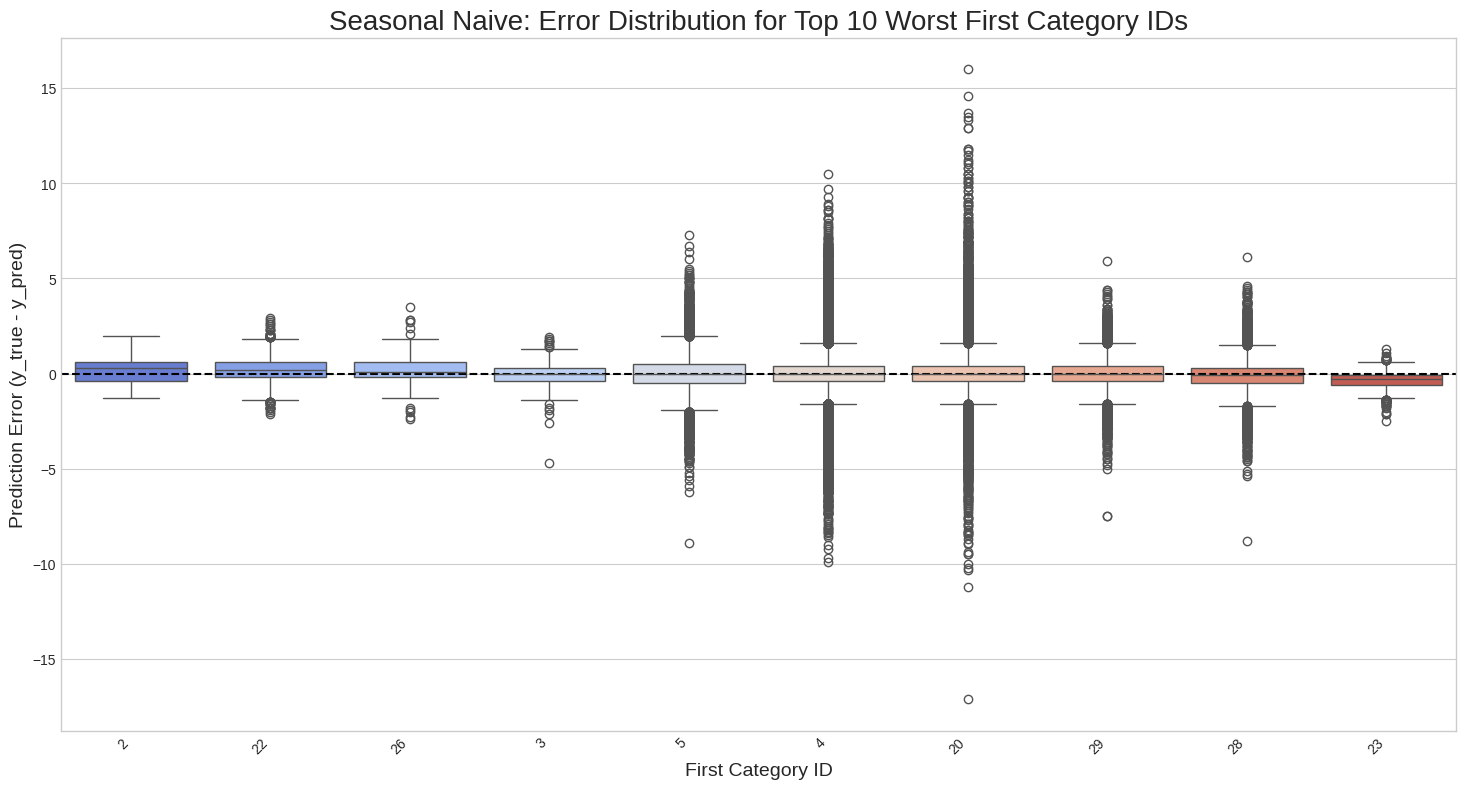

In [ ]:
category_to_analyze = 'first_category_id'

# This finds the categories that are, on average, the most wrong.
top_10_categories = (baseline_analysis_df.groupby(category_to_analyze)['abs_error']
                     .median()
                     .sort_values(ascending=False)
                     .head(10)
                     .index)

df_to_plot = baseline_analysis_df[baseline_analysis_df[category_to_analyze].isin(top_10_categories)]

sorted_order = (df_to_plot.groupby(category_to_analyze)['error']
                .median()
                .sort_values(ascending=False)
                .index)

plt.figure(figsize=(18, 9))
sns.boxplot(
    data=df_to_plot,
    x=category_to_analyze,
    y='error',
    order=sorted_order,
    palette='coolwarm'
)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Seasonal Naive: Error Distribution for Top 10 Worst First Category IDs', fontsize=20)
plt.xlabel('First Category ID', fontsize=14)
plt.ylabel('Prediction Error (y_true - y_pred)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

--- Deep-Dive Analysis for Category 20 (Seasonal Naive) ---


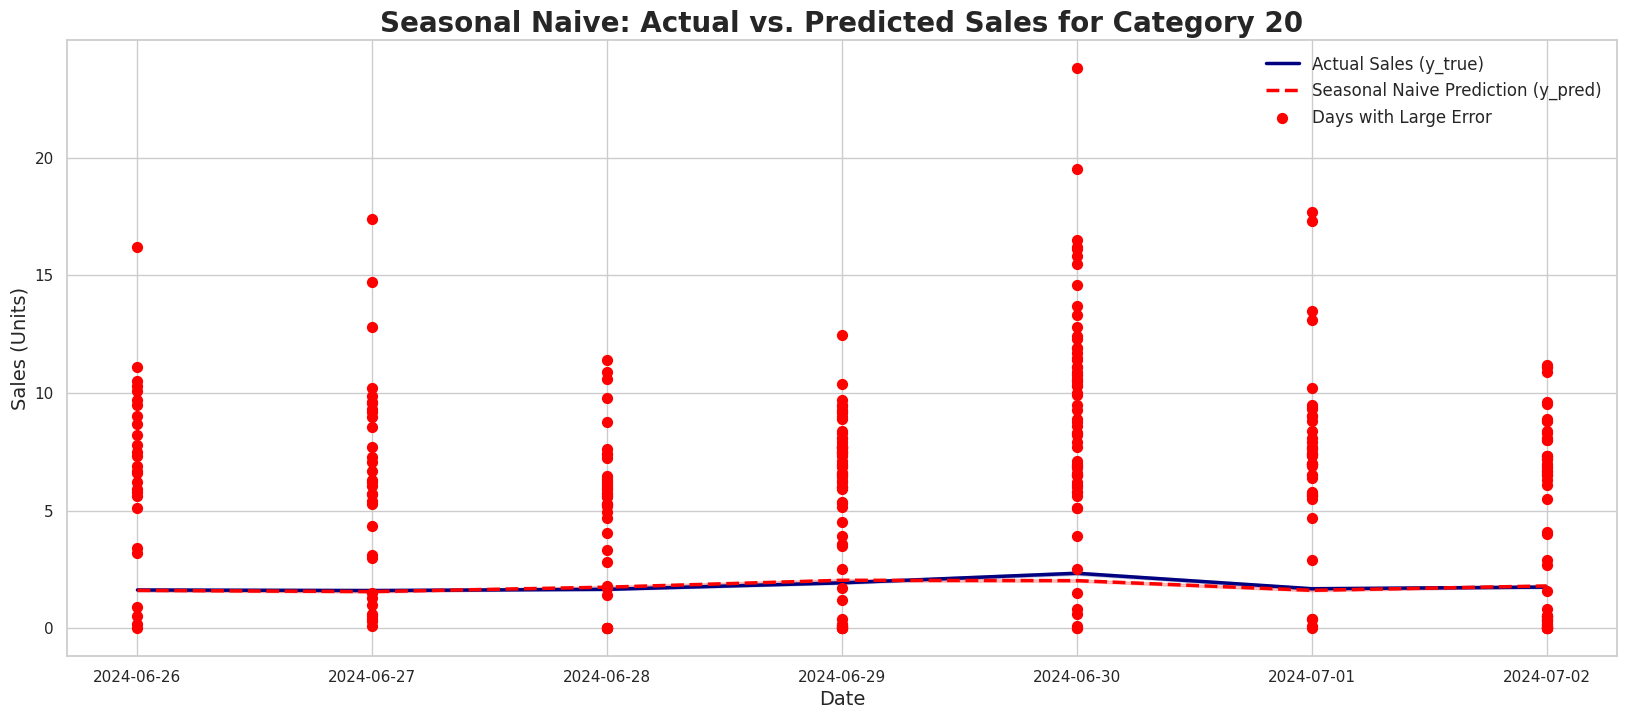

In [ ]:
# ===================================================================
# CELL: Time-Series Deep-Dive for the Baseline's Worst Category (Consistent Style)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Isolate the data and define the category to investigate ---
# From your box plot, Category 20 had the largest error range.
category_to_investigate = 20
df_to_plot = baseline_analysis_df[baseline_analysis_df['first_category_id'] == category_to_investigate].copy()

print(f"--- Deep-Dive Analysis for Category {category_to_investigate} (Seasonal Naive) ---")

# --- Step 2: Define and identify the days with the largest errors ---
# A large error for the baseline can be a huge under-prediction OR a huge over-prediction.
# We will use the absolute error to find these "spike" days.
# You can adjust this threshold based on your sales volume. A value around 5-10 is often a good start.
error_threshold = 5
spike_days = df_to_plot[df_to_plot['abs_error'] > error_threshold]

# --- Step 3: Create the visualization with a consistent style ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 8))

# Plot the Actual Sales (consistent style: navy blue, solid)
sns.lineplot(data=df_to_plot, x='date', y='y_true', label='Actual Sales (y_true)', color='navy', linewidth=2.5)

# Plot the Seasonal Naive Prediction (consistent style: dashed, but RED to differentiate from XGBoost's orange)
sns.lineplot(data=df_to_plot, x='date', y='y_pred', label='Seasonal Naive Prediction (y_pred)', color='red', linestyle='--', linewidth=2.5)

# Highlight the days with large errors (consistent style: large red dots)
if not spike_days.empty:
    # We plot the red dots on the 'y_true' line to show the actual sales on the days the model failed badly.
    plt.scatter(spike_days['date'], spike_days['y_true'], color='red', s=50, zorder=5, label='Days with Large Error')

# --- Titles and Labels (consistent style) ---
plt.title(f'Seasonal Naive: Actual vs. Predicted Sales for Category {category_to_investigate}', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales (Units)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# ===================================================================
# CELL: Compare Volatility of Good vs. Bad Categories
# ===================================================================

# --- Define a good and a bad category from your box plot ---
bad_category_id = 20
good_category_id = 2 # Category 2 has a very tight error distribution

# --- Calculate the Coefficient of Variation (a measure of volatility) ---
# We use the original, clean test data for this
volatility_bad = test_data_clean[test_data_clean['first_category_id'] == bad_category_id]['y'].std() / test_data_clean[test_data_clean['first_category_id'] == bad_category_id]['y'].mean()
volatility_good = test_data_clean[test_data_clean['first_category_id'] == good_category_id]['y'].std() / test_data_clean[test_data_clean['first_category_id'] == good_category_id]['y'].mean()

print("--- Volatility Comparison (Coefficient of Variation) ---")
print(f"  Volatility for BAD Category ({bad_category_id}): {volatility_bad:.2f}")
print(f"  Volatility for GOOD Category ({good_category_id}): {volatility_good:.2f}")

if volatility_bad > volatility_good:
    print("\nConclusion: The high-error category is significantly more volatile than the low-error category.")

--- Volatility Comparison (Coefficient of Variation) ---
  Volatility for BAD Category (20): 1.07
  Volatility for GOOD Category (2): 0.77

Conclusion: The high-error category is significantly more volatile than the low-error category.



--- Analyzing Baseline's Daily Mean Absolute Error Over Time ---


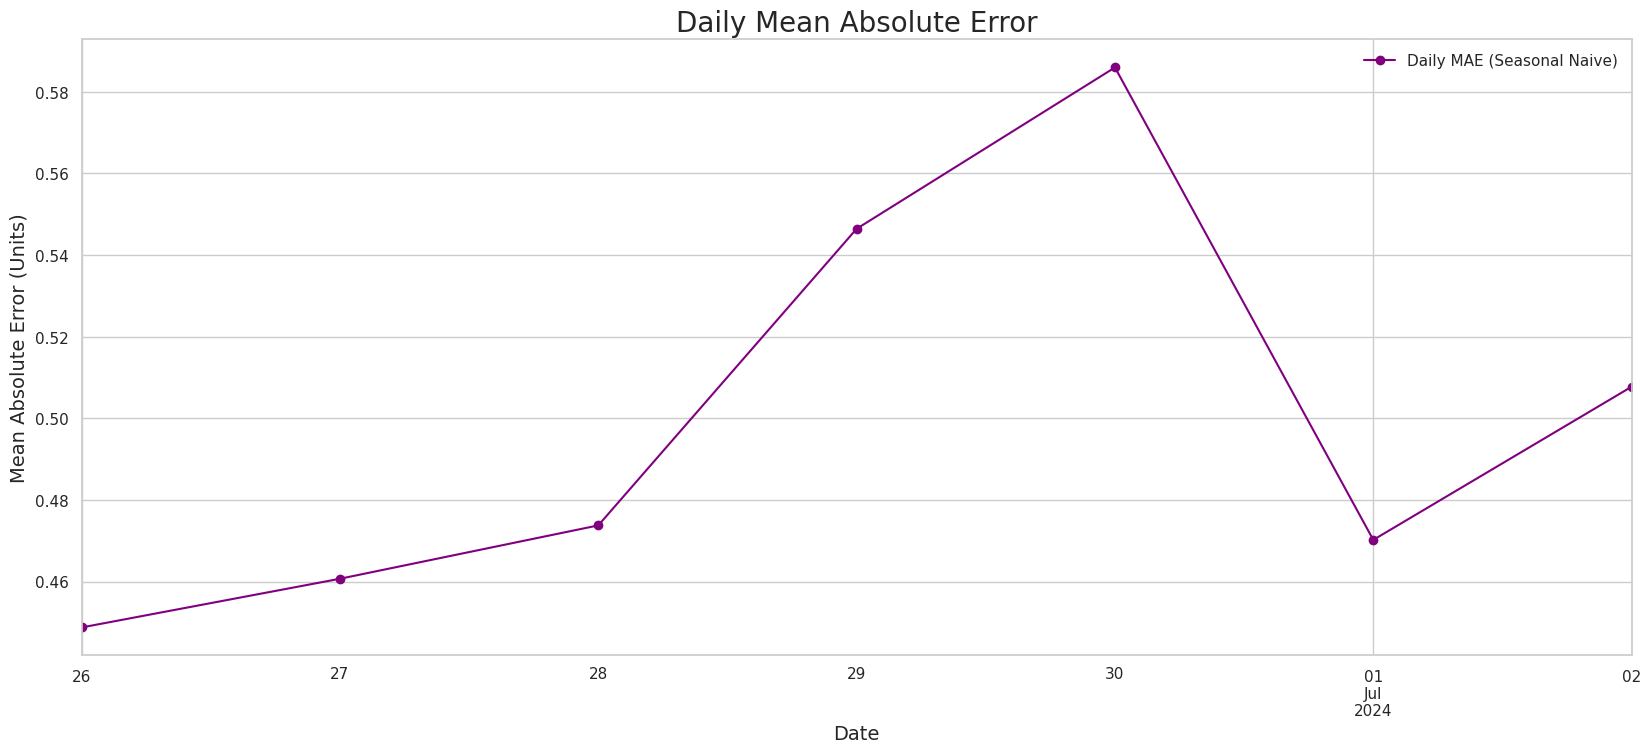

In [ ]:
# ===================================================================
# CELL 4: Analyze Error Over the Test Time Horizon
# ===================================================================

print("\n--- Analyzing Baseline's Daily Mean Absolute Error Over Time ---")

# Group by date and calculate the Mean Absolute Error for each day
daily_mae_baseline = baseline_analysis_df.groupby('date')['abs_error'].mean()

plt.figure(figsize=(20, 8))
daily_mae_baseline.plot(kind='line', marker='o', color='purple', label='Daily MAE (Seasonal Naive)')

plt.title('Daily Mean Absolute Error', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Absolute Error (Units)', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# ===================================================================
# CELL 5: Deep-Dive Investigation into a High-Error Date
# ===================================================================
import pandas as pd

date_to_investigate = pd.to_datetime('2024-06-30') # Change this date if needed
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print(f"--- Top 10 Largest Errors on {date_to_investigate.date()} (with Full Feature Context) ---")

display_cols = [
    'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error', 'first_category_id', 'dow',
    'promo_strategy_Non-Price Promo', 'promo_strategy_Price Penetration',
    'promo_strategy_Standard Discount', 'discount_depth', 'stockout_ratio_d',
    'stockout_ratio_lag1d', 'log_y_lag_1d'
]
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]
print(worst_preds_on_spike_day[display_cols].to_string())

--- Top 10 Largest Errors on 2024-06-30 (with Full Feature Context) ---
       sku_store_id  y_true  y_pred  error  abs_error  first_category_id  promo_strategy_Non-Price Promo  promo_strategy_Price Penetration  promo_strategy_Standard Discount  discount_depth  stockout_ratio_d  stockout_ratio_lag1d  log_y_lag_1d
222410      267_538     1.2   17.50 -16.30      16.30                 21                             0.0                               1.0                               0.0             1.0          0.823529                   0.0      3.194583
243897      300_555    19.5    3.50  16.00      16.00                 20                             0.0                               0.0                               0.0             0.0          0.000000                   0.0      2.606387
241981      300_431    23.8    9.20  14.60      14.60                 20                             0.0                               0.0                               0.0             0.0          0

In [ ]:
# ===================================================================
# CELL: Deep-Dive Investigation into the June 30th Error Spike
# ===================================================================

import pandas as pd

# --- Step 1: Isolate all the predictions made for the specific date ---
date_to_investigate = pd.to_datetime('2024-06-30')
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]

print(f"--- Investigation for Date: {date_to_investigate.date()} ---")
print(f"Total predictions on this day: {len(day_of_spike)}")
print(f"Average Absolute Error (MAE) on this day: {day_of_spike['abs_error'].mean():.4f}")


# --- Step 2: Find the top 10 worst predictions on that day ---
# This will tell us if the error is concentrated in a few bad predictions.
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print("\n--- Top 10 Largest Errors on this Date ---")

# Display the most relevant columns
display_cols = ['date', 'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error', 'first_category_id', 'promo_strategy']
# Filter out columns that might not exist to avoid errors
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]

print(worst_preds_on_spike_day[display_cols].to_string())


# --- Step 3: Analyze the nature of the errors ---
num_under_predictions = (worst_preds_on_spike_day['error'] > 0).sum()
num_over_predictions = (worst_preds_on_spike_day['error'] < 0).sum()

print("\n--- Summary of the Top 10 Errors ---")
print(f"Number of significant UNDER-predictions (y_true > y_pred): {num_under_predictions}")
print(f"Number of significant OVER-predictions (y_true < y_pred): {num_over_predictions}")

--- Investigation for Date: 2024-06-30 ---
Total predictions on this day: 50000
Average Absolute Error (MAE) on this day: 0.5860

--- Top 10 Largest Errors on this Date ---
             date sku_store_id  y_true  y_pred  error  abs_error  first_category_id
222410 2024-06-30      267_538     1.2   17.50 -16.30      16.30                 21
243897 2024-06-30      300_555    19.5    3.50  16.00      16.00                 20
241981 2024-06-30      300_431    23.8    9.20  14.60      14.60                 20
242052 2024-06-30      300_145    15.8    2.10  13.70      13.70                 20
242628 2024-06-30       300_34    13.3    0.00  13.30      13.30                 20
243571 2024-06-30      300_822    15.5    2.60  12.90      12.90                 20
243764 2024-06-30      300_552    11.9    0.10  11.80      11.80                 20
242813 2024-06-30      300_191    11.9    0.20  11.70      11.70                 20
242351 2024-06-30      300_231    11.1    0.00  11.10      11.10       

In [ ]:
# ===================================================================
# CELL: Comprehensive Deep-Dive Investigation into the June 30th Error Spike
# ===================================================================
import pandas as pd

# --- Step 1: Isolate all the predictions made for the specific date ---
date_to_investigate = pd.to_datetime('2024-06-30')
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]

print(f"--- Investigation for Date: {date_to_investigate.date()} ---")
print(f"Total predictions on this day: {len(day_of_spike)}")
print(f"Average Absolute Error (MAE) on this day: {day_of_spike['abs_error'].mean():.4f}")


# --- Step 2: Find the top 10 worst predictions on that day ---
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print("\n--- Top 10 Largest Errors on this Date (with Full Feature Context) ---")

# --- THIS IS THE KEY CHANGE ---
# Define a comprehensive list of columns to display for a full diagnosis.
# This includes the core error metrics and your key engineered features.
display_cols = [
    # Core Metrics
    'sku_store_id',
    'y_true',
    'y_pred',
    'error',
    'abs_error',

    # Category / Day Features
    'first_category_id',
    'dow', # Day of Week (0=Mon, 6=Sun)

    # Promotion Features
    'promo_strategy',
    'discount_depth',

    # Stockout Features
    'stockout_ratio_d',      # Stockout ratio for the CURRENT day
    'stockout_ratio_lag1d',  # Stockout ratio for the PREVIOUS day

    # Lagged/Rolling Sales Features
    'log_y_lag_1d',          # Yesterday's sales (log scale)
    'log_y_lag_7d',          # Last week's sales (log scale) - THIS IS y_pred!
    'log_y_roll_mean_7d'     # Rolling 7-day average of sales
]

# Filter out any columns that might not exist in the dataframe to prevent errors
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]

# Print the detailed table
print(worst_preds_on_spike_day[display_cols].to_string())


# --- Step 3: Analyze the nature of the errors ---
num_under_predictions = (worst_preds_on_spike_day['error'] > 0).sum()
num_over_predictions = (worst_preds_on_spike_day['error'] < 0).sum()

print("\n--- Summary of the Top 10 Errors ---")
print(f"Number of significant UNDER-predictions (y_true > y_pred): {num_under_predictions}")
print(f"Number of significant OVER-predictions (y_true < y_pred): {num_over_predictions}")

--- Investigation for Date: 2024-06-30 ---
Total predictions on this day: 50000
Average Absolute Error (MAE) on this day: 0.5860

--- Top 10 Largest Errors on this Date (with Full Feature Context) ---
       sku_store_id  y_true  y_pred  error  abs_error  first_category_id  discount_depth  stockout_ratio_d  stockout_ratio_lag1d  log_y_lag_1d  log_y_lag_7d  log_y_roll_mean_7d
222410      267_538     1.2   17.50 -16.30      16.30                 21             1.0          0.823529                   0.0      3.194583      2.917771            2.875876
243897      300_555    19.5    3.50  16.00      16.00                 20             0.0          0.000000                   0.0      2.606387      1.504077            1.995068
241981      300_431    23.8    9.20  14.60      14.60                 20             0.0          0.000000                   0.0      2.509599      2.322388            2.526990
242052      300_145    15.8    2.10  13.70      13.70                 20             0.0   

In [ ]:
# ===================================================================
# CELL: Comprehensive Deep-Dive with PROMOTION Details
# ===================================================================
import pandas as pd

# --- Step 1: Isolate all the predictions made for the specific date ---
date_to_investigate = pd.to_datetime('2024-06-30')
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]

print(f"--- Investigation for Date: {date_to_investigate.date()} ---")
print(f"Total predictions on this day: {len(day_of_spike)}")
print(f"Average Absolute Error (MAE) on this day: {day_of_spike['abs_error'].mean():.4f}")


# --- Step 2: Find the top 10 worst predictions on that day ---
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print("\n--- Top 10 Largest Errors on this Date (with Full Feature Context) ---")

# --- THIS IS THE KEY CHANGE ---
# We now include the one-hot encoded promotion columns.
display_cols = [
    # Core Metrics
    'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error',

    # Category / Day Features
    'first_category_id', 'dow',

    # Promotion Features (One-Hot Encoded)
    'promo_strategy_Non-Price Promo',
    'promo_strategy_Price Penetration',
    'promo_strategy_Standard Discount',
    'discount_depth',

    # Stockout & Lagged Features
    'stockout_ratio_d', 'stockout_ratio_lag1d', 'log_y_lag_1d'
]

# Filter out any columns that might not exist to prevent errors
# (This is important in case one of the promo types never appears in the top 10)
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]

# Print the detailed table
print(worst_preds_on_spike_day[display_cols].to_string())

--- Investigation for Date: 2024-06-30 ---
Total predictions on this day: 50000
Average Absolute Error (MAE) on this day: 0.5860

--- Top 10 Largest Errors on this Date (with Full Feature Context) ---
       sku_store_id  y_true  y_pred  error  abs_error  first_category_id  promo_strategy_Non-Price Promo  promo_strategy_Price Penetration  promo_strategy_Standard Discount  discount_depth  stockout_ratio_d  stockout_ratio_lag1d  log_y_lag_1d
222410      267_538     1.2   17.50 -16.30      16.30                 21                             0.0                               1.0                               0.0             1.0          0.823529                   0.0      3.194583
243897      300_555    19.5    3.50  16.00      16.00                 20                             0.0                               0.0                               0.0             0.0          0.000000                   0.0      2.606387
241981      300_431    23.8    9.20  14.60      14.60                 

--- Generating the Predictive Behavior distribution for the Seasonal Naive Baseline ---


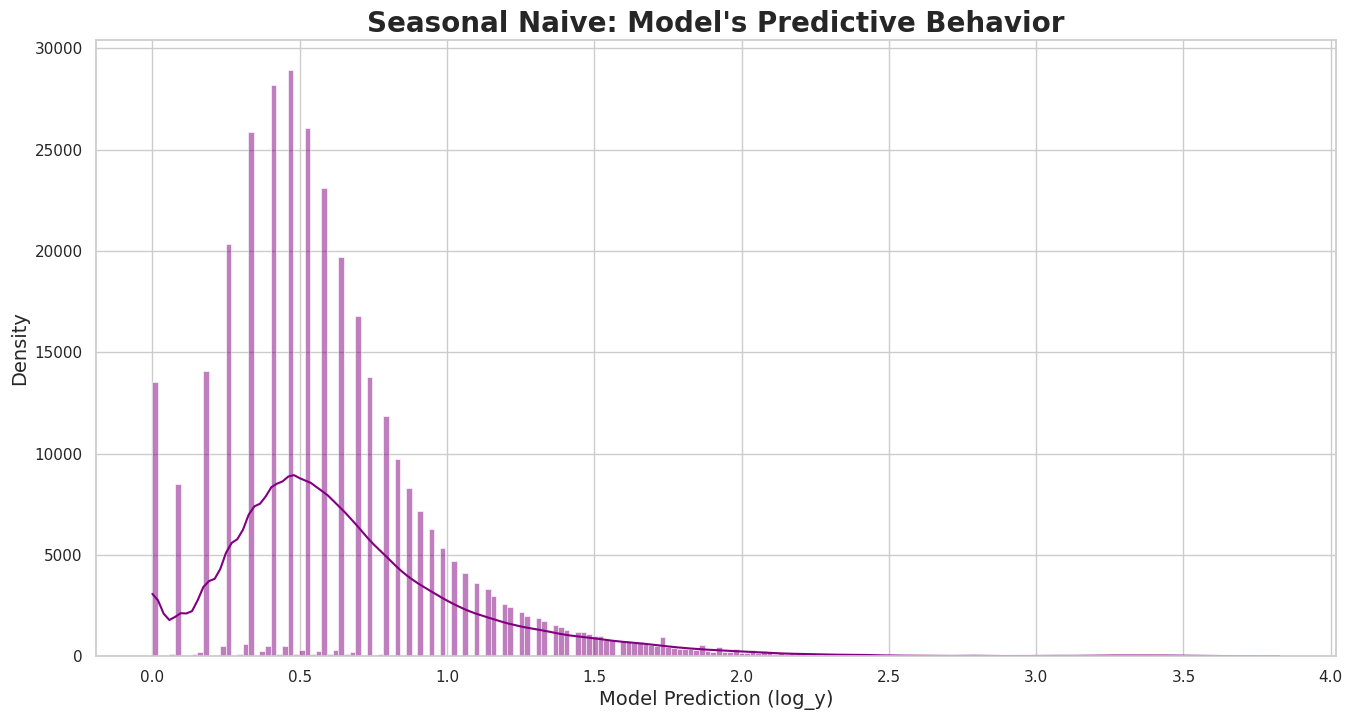

In [ ]:
# ===================================================================
# CELL: Visualize the Seasonal Naive Model's Predictive Behavior
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating the Predictive Behavior distribution for the Seasonal Naive Baseline ---")

# --- Set the plotting style ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))

# --- Create the histogram and density plot ---
# We use the log-transformed predictions ('log_y_pred') from our analysis dataframe.
# A high number of bins helps to see the shape clearly.
sns.histplot(baseline_analysis_df['log_y_pred'], kde=True, color='purple', bins=200)

# --- Titles and Labels (consistent with your other plots) ---
plt.title("Seasonal Naive: Model's Predictive Behavior", fontsize=20, fontweight='bold')
plt.xlabel("Model Prediction (log_y)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

--- Generating Predicted vs. Actual plot for the Baseline Model ---


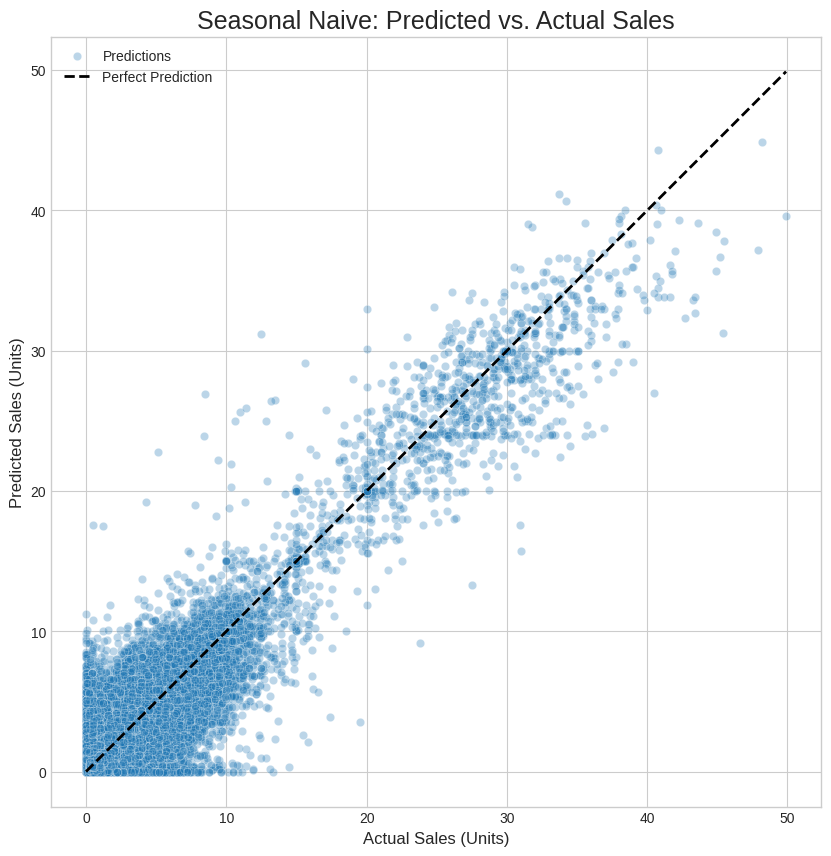

In [ ]:
# ===================================================================
# CELL: Predicted vs. Actual Analysis for the Baseline Model
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating Predicted vs. Actual plot for the Baseline Model ---")

# We use the original scale data for the most intuitive interpretation
df_to_plot = baseline_analysis_df.copy()

plt.figure(figsize=(10, 10)) # Use a square figure for a better aspect ratio

# Create the scatter plot
sns.scatterplot(
    x='y_true',
    y='y_pred',
    data=df_to_plot,
    alpha=0.3, # Use transparency to see the density of points
    label='Predictions'
)

# --- Create the "Perfect Prediction" line ---
# Find the minimum and maximum values for the axes to create a perfect diagonal line
min_val = min(df_to_plot['y_true'].min(), df_to_plot['y_pred'].min())
max_val = max(df_to_plot['y_true'].max(), df_to_plot['y_pred'].max())

# Plot the y=x line
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=2, label='Perfect Prediction')

# --- Titles and Labels ---
plt.title('Seasonal Naive: Predicted vs. Actual Sales', fontsize=18)
plt.xlabel('Actual Sales (Units)', fontsize=12)
plt.ylabel('Predicted Sales (Units)', fontsize=12)
plt.legend()

# IMPORTANT: Make the plot square so the diagonal line looks correct
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [ ]:
# Ensure the model and test data are loaded and ready

# 1. Generate the predictions (this is the line that was missing before)
final_predictions_log = champion_model_xgb.predict(X_test)
print("Prediction step executed successfully.")

# 2. Now run the diagnostics
print("\n--- Verifying Target Variable Ranges ---")
print(f"Training target (log_y) range: {y_full_train.min():.4f} to {y_full_train.max():.4f}")
print(f"Test target (log_y) range:     {y_test.min():.4f} to {y_test.max():.4f}")
print(f"Prediction (log_y) range:      {final_predictions_log.min():.4f} to {final_predictions_log.max():.4f}")

Prediction step executed successfully.

--- Verifying Target Variable Ranges ---
Training target (log_y) range: 0.0000 to 3.8265
Test target (log_y) range:     0.0000 to 3.9299
Prediction (log_y) range:      -0.1076 to 3.2142


In [ ]:
print("--- Statistical Summary of XGBoost Actuals ---")
# Ensure the y_true column is calculated if it's not already
if 'y_true' not in xgb_analysis_df.columns:
    xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
print(xgb_analysis_df['y_true'].describe())

print("\n" + "="*50 + "\n")

print("--- Statistical Summary of Seasonal Naive (Baseline) Actuals ---")
# The variable for your baseline model's analysis data is 'baseline_analysis_df'
# based on your plotting code
print(baseline_analysis_df['y_true'].describe())

--- Statistical Summary of XGBoost Actuals ---
count    25088.000000
mean         0.880291
std          0.746075
min          0.000000
25%          0.400000
50%          0.700000
75%          1.100000
max          9.200000
Name: y_true, dtype: float64


--- Statistical Summary of Seasonal Naive (Baseline) Actuals ---
count    350000.000000
mean          1.193053
std           1.911597
min           0.000000
25%           0.400000
50%           0.800000
75%           1.300000
max          49.900000
Name: y_true, dtype: float64


In [ ]:
# After you create train_df_final, val_df_final, test_df_final...
print(f"Train shape: {train_df_final.shape}")
print(f"Validation shape: {val_df_final.shape}")
print(f"Test shape: {test_df_final.shape}")

Train shape: (3400000, 33)
Validation shape: (750000, 33)
Test shape: (350000, 33)


In [ ]:
# 5. Create and Save the Detailed Analysis DataFrame (for visualizations)
print("Creating detailed analysis DataFrame...")

# Create a dataframe with predictions and true values (350,000 rows)
xgb_predictions_df = pd.DataFrame({
    'log_y_true': y_test,
    'log_y_pred': final_predictions_log
}, index=X_test.index)

# CORRECTED: Merge with the FULL test set dataframe
xgb_analysis_df = pd.merge(
    xgb_predictions_df,
    test_df_final, # Use the correct, full-sized dataframe
    left_index=True,
    right_index=True,
    how='inner'
)

# Calculate error columns
xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
xgb_analysis_df['y_pred'] = np.expm1(xgb_analysis_df['log_y_pred'])
xgb_analysis_df['error'] = xgb_analysis_df['y_true'] - xgb_analysis_df['y_pred']
xgb_analysis_df['abs_error'] = xgb_analysis_df['error'].abs()

# Now, this shape should be 350,000
print(f"Shape of the final analysis DataFrame: {xgb_analysis_df.shape}")

DETAILED_ANALYSIS_PATH = os.path.join(MODEL_DIR, "champion_xgb_ANALYSIS_data.csv")
xgb_analysis_df.to_csv(DETAILED_ANALYSIS_PATH, index=False)
print(f"✅ Detailed analysis data for visualizations saved to: {DETAILED_ANALYSIS_PATH}")

Creating detailed analysis DataFrame...
Shape of the final analysis DataFrame: (350000, 39)
✅ Detailed analysis data for visualizations saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_ANALYSIS_data.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# ===================================================================
# SECTION 1: PREDICTION & METRIC CALCULATION (This part was already correct)
# ===================================================================
print("--- Making predictions on the full test set ---")

# Ensure your model and data (X_test, y_test) are loaded and available
# X_test and y_test should both have 350,000 rows
final_predictions_log = champion_model_xgb.predict(X_test)
print(f"Prediction complete. Generated {len(final_predictions_log)} predictions.")

# Prepare true values for metric calculation
y_true_log = y_test
y_true_orig = np.expm1(y_true_log)
y_pred_orig = np.expm1(final_predictions_log)

# Calculate metrics on the full 350,000-row test set
print("\n--- Calculating final performance metrics ---")
final_rmse_log = np.sqrt(mean_squared_error(y_true_log, final_predictions_log))
final_wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / (np.sum(y_true_orig) + 1e-9)
final_mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
final_rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

champion_xgb_results = {
    'LOG RMSE': final_rmse_log, 'WAPE': final_wape, 'MAE': final_mae_orig, 'RMSE': final_rmse_orig
}
results_df = pd.DataFrame({'XGBoost Champion (on Test)': champion_xgb_results}).T
print(results_df.to_string(formatters={'WAPE':'{:.2%}'.format}))


# ===================================================================
# SECTION 2: CREATE AND SAVE THE DETAILED ANALYSIS DATAFRAME (This section is now corrected)
# ===================================================================
print("\n--- Creating detailed analysis DataFrame for visualizations ---")

# Create a dataframe with predictions and true values (will have 350,000 rows)
xgb_predictions_df = pd.DataFrame({
    'log_y_true': y_test,
    'log_y_pred': final_predictions_log
}, index=X_test.index)

# BUG FIX: Merge with the FULL test dataframe `test_df_final`, NOT the old `test_df_analysis`.
# This ensures we keep all 350,000 rows.
xgb_analysis_df = pd.merge(
    xgb_predictions_df,
    test_df_final,  # <--- THIS IS THE FIX
    left_index=True,
    right_index=True,
    how='inner'
)

# Add the calculated columns for easier analysis and plotting
# Note: Some columns like 'log_y' might already exist from test_df_final, which is fine.
# We recalculate 'y_true' and 'y_pred' from the merged data to be certain.
xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
xgb_analysis_df['y_pred'] = np.expm1(xgb_analysis_df['log_y_pred'])
xgb_analysis_df['error'] = xgb_analysis_df['y_true'] - xgb_analysis_df['y_pred']
xgb_analysis_df['abs_error'] = xgb_analysis_df['error'].abs()

# Verification step: Check the shape to confirm the fix worked.
print(f"Shape of the final analysis DataFrame: {xgb_analysis_df.shape}")
print(f"Max 'y_true' in final analysis DataFrame: {xgb_analysis_df['y_true'].max()}")

# Define your save directory and save the corrected file
MODEL_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model"
DETAILED_ANALYSIS_PATH = os.path.join(MODEL_DIR, "champion_xgb_ANALYSIS_data_CORRECTED.csv")
xgb_analysis_df.to_csv(DETAILED_ANALYSIS_PATH, index=False)
print(f"✅ Corrected detailed analysis data saved to: {DETAILED_ANALYSIS_PATH}")

--- Making predictions on the full test set ---
Prediction complete. Generated 350000 predictions.

--- Calculating final performance metrics ---
                            LOG RMSE   WAPE       MAE      RMSE
XGBoost Champion (on Test)  0.187893 29.28%  0.349346  0.802428

--- Creating detailed analysis DataFrame for visualizations ---
Shape of the final analysis DataFrame: (350000, 39)
Max 'y_true' in final analysis DataFrame: 49.9
✅ Corrected detailed analysis data saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_ANALYSIS_data_CORRECTED.csv


## Save the model

In [ ]:
# ===================================================================
# ADD-ON: Save the DETAILED ANALYSIS DataFrame to Google Drive
# ===================================================================
from google.colab import drive
import os

# This assumes 'baseline_analysis_df' has just been created in the cell above.

print("\n--- Saving the DETAILED baseline analysis data to Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path where you want to save the data
RESULTS_DIR = "/content/drive/MyDrive/Colab_Results"
ANALYSIS_DATA_PATH = os.path.join(RESULTS_DIR, "seasonal_naive_ANALYSIS_data.csv")

# 3. Create the directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# 4. Save the 'baseline_analysis_df' to a CSV file.
#    index=False is good here as the default index is not meaningful.
baseline_analysis_df.to_csv(ANALYSIS_DATA_PATH, index=False)

print(f"\n✅ Detailed analysis data has been permanently saved to: {ANALYSIS_DATA_PATH}")


--- Saving the DETAILED baseline analysis data to Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Detailed analysis data has been permanently saved to: /content/drive/MyDrive/Colab_Results/seasonal_naive_ANALYSIS_data.csv


In [28]:
# ===================================================================
# CELL: Load the DETAILED Analysis Data from Google Drive
# ===================================================================
import pandas as pd
import os
from google.colab import drive

print("--- Loading the DETAILED baseline analysis data from Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path to your saved data file
ANALYSIS_DATA_PATH = "/content/drive/MyDrive/Colab_Results/seasonal_naive_ANALYSIS_data.csv"

# 3. Check if the file exists and then load it
if not os.path.exists(ANALYSIS_DATA_PATH):
    raise FileNotFoundError(f"Analysis data file not found at {ANALYSIS_DATA_PATH}.")

# Load the CSV. Tell pandas to parse the 'date' column correctly.
baseline_analysis_df = pd.read_csv(ANALYSIS_DATA_PATH, parse_dates=['date'])

print("✅ Detailed analysis data loaded into 'baseline_analysis_df'. You can now run your visualization cells.")

# --- You can now run ANY of your plotting cells, for example: ---
# (Just copy-paste one of your visualization cells here)
print("\n--- Example: Generating Box Plot for Top 10 Worst Categories ---")
# ... (your box plot code) ...

--- Loading the DETAILED baseline analysis data from Google Drive ---
Mounted at /content/drive
✅ Detailed analysis data loaded into 'baseline_analysis_df'. You can now run your visualization cells.

--- Example: Generating Box Plot for Top 10 Worst Categories ---


In [ ]:
from google.colab import drive
import os

print("\n--- Saving Final Test Set baseline results to Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path where you want to save the results
RESULTS_DIR = "/content/drive/MyDrive/Colab_Results"
RESULTS_PATH = os.path.join(RESULTS_DIR, "seasonal_naive_test_results.csv")

# 3. Create the directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# 4. Save the 'test_results_table' DataFrame to a CSV file.
#    The index=True is CRITICAL to save the model name.
test_results_table.to_csv(RESULTS_PATH, index=True)

print(f"\n✅ Test baseline results permanently saved to: {RESULTS_PATH}")
# ===================================================================


--- Saving Final Test Set baseline results to Google Drive ---
Mounted at /content/drive

✅ Test baseline results permanently saved to: /content/drive/MyDrive/Colab_Results/seasonal_naive_test_results.csv


In [ ]:
# ===================================================================
# CELL: Load Saved Seasonal Naive TEST Results from Google Drive
# This runs in seconds in any new session.
# ===================================================================
import pandas as pd
import os
from google.colab import drive

print("--- Loading FINAL baseline results from Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path to your saved results file
#    This MUST be the exact same path you used to save it.
RESULTS_PATH = "/content/drive/MyDrive/Colab_Results/seasonal_naive_test_results.csv"

# 3. Check if the file exists and load it
if not os.path.exists(RESULTS_PATH):
    raise FileNotFoundError(f"Results file not found at {RESULTS_PATH}. Please ensure you have run the saving script first.")

# Load the CSV. The index_col=0 tells pandas that the first column is our index ('Seasonal Naive (on Test)').
test_results_table = pd.read_csv(RESULTS_PATH, index_col=0)

print("✅ Final baseline results loaded successfully from Drive.")


# --- 4. Display the Loaded Table ---
# This will look exactly like your original output.
print("\n" + "="*50)
print("--- FINAL SEASONAL NAIVE PERFORMANCE (on Test Set) ---")
print("="*50)
print(test_results_table.to_string(formatters={'WAPE':'{:.2%}'.format}))

# XGBoost

In [20]:
train_df_final = train_df_final.sort_values(['sku_store_id', 'date']).reset_index(drop=True)
val_df_final = val_df_final.sort_values(['sku_store_id', 'date']).reset_index(drop=True)
test_df_final = test_df_final.sort_values(['sku_store_id', 'date']).reset_index(drop=True)

In [21]:
TARGET = 'log_y'
ALL_POSSIBLE_FEATURES = train_df_final.columns.tolist()


COLUMNS_TO_DROP = [ 'log_y','y', 'date', 'sku_store_id', 'precpt', 'avg_humidity', 'avg_temperature', 'avg_wind_level']


FEATURES = [f for f in ALL_POSSIBLE_FEATURES if f not in COLUMNS_TO_DROP]
print(f"Using {len(FEATURES)} final features for the model.")

print("\n--- Step 1b: Creating Final Data Splits for Modeling ---")
X_train = train_df_final[FEATURES]
y_train = train_df_final[TARGET]

X_val = val_df_final[FEATURES]
y_val = val_df_final[TARGET]

X_test = test_df_final[FEATURES]
y_test = test_df_final[TARGET]

X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

print("\nData Shapes for Modeling:")
print(f"   - Training features shape:   {X_train.shape}")
print(f"   - Validation features shape: {X_val.shape}")
print(f"   - Test features shape:       {X_test.shape}")
print(f"   - Full training shape:       {X_full_train.shape}")


Using 25 final features for the model.

--- Step 1b: Creating Final Data Splits for Modeling ---

Data Shapes for Modeling:
   - Training features shape:   (3400000, 25)
   - Validation features shape: (750000, 25)
   - Test features shape:       (350000, 25)
   - Full training shape:       (4150000, 25)


In [22]:
# Instantiate the model with default parameters
untuned_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Fit (Train) the model only on the training set
untuned_model.fit(X_train, y_train)

# predict on the validation set
val_predictions_log = untuned_model.predict(X_val)

# evaluate the performance
print("\nPerformance of Untuned XGBoost on Validation Set")

# Convert target and predictions back to original scale
y_true_orig = np.expm1(y_val)
y_pred_orig = np.expm1(val_predictions_log)

# Calculate metrics
log_rmse = np.sqrt(mean_squared_error(y_val, val_predictions_log))
wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / np.sum(y_true_orig)
mae = mean_absolute_error(y_true_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

print(f"  LOG RMSE: {log_rmse:.4f}")
print(f"  WAPE:     {wape:.2%}")
print(f"  MAE:      {mae:.4f}")
print(f"  RMSE:     {rmse:.4f}")


Performance of Untuned XGBoost on Validation Set
  LOG RMSE: 0.1876
  WAPE:     29.19%
  MAE:      0.3270
  RMSE:     0.6748


In [ ]:
# Hyperparameter Tuning

X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([y_train, y_val])

def objective_cv(trial):
    params = {
        'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'random_state': 42, 'n_jobs': -1,
        'booster': 'gbtree',
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 5.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True), # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),  # L1 regularization
    }

    N_SPLITS = 4
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    scores = []

    for train_index, val_index in tscv.split(X_tune):
        X_train_fold, X_val_fold = X_tune.iloc[train_index], X_tune.iloc[val_index]
        y_train_fold, y_val_fold = y_tune.iloc[train_index], y_tune.iloc[val_index]


        # Convert data to DMatrix
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)

        pruning_callback = XGBoostPruningCallback(trial, "validation-rmse")

        # Use xgb.train which accepts callbacks
        model = xgb.train(
            params=params,
            dtrain=dtrain_fold,
            num_boost_round=2000,
            evals=[(dval_fold, 'validation')],
            callbacks=[pruning_callback],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        # Get the best score from the trained model object
        scores.append(model.best_score)


    return np.mean(scores)

N_TRIALS = 30

study_cv = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

with tqdm(total=N_TRIALS, desc="Optimizing Hyperparameters") as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)

    study_cv.optimize(objective_cv, n_trials=N_TRIALS, callbacks=[tqdm_callback])

print(f"Best validation RMSE (avg across folds): {study_cv.best_value:.4f}")
print("Best hyperparameters found:")
print(study_cv.best_params)

[I 2025-11-25 17:27:53,042] A new study created in memory with name: no-name-d64e3bf4-2756-47eb-806d-5e0820084434


Optimizing Hyperparameters:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-25 17:35:45,881] Trial 0 finished with value: 0.19325826982880928 and parameters: {'learning_rate': 0.023171758042400847, 'max_depth': 12, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 2.2761531148837062e-07, 'min_child_weight': 4, 'lambda': 2.9152036385288193e-08, 'alpha': 0.08499808989182997}. Best is trial 0 with value: 0.19325826982880928.
[I 2025-11-25 17:37:53,471] Trial 1 finished with value: 0.19407502805940055 and parameters: {'learning_rate': 0.05859268690985102, 'max_depth': 10, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 0.17433860342268107, 'min_child_weight': 5, 'lambda': 2.8483918709107956e-07, 'alpha': 2.9324868872723725e-07}. Best is trial 0 with value: 0.19325826982880928.
[I 2025-11-25 17:46:45,574] Trial 2 finished with value: 0.19396846737214396 and parameters: {'learning_rate': 0.01737635693697876, 'max_depth': 8, 'subsample': 0.7159725093210578, 'colsample_bytree': 0.645614570099

Best validation RMSE (avg across folds): 0.1933
Best hyperparameters found:
{'learning_rate': 0.023171758042400847, 'max_depth': 12, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 2.2761531148837062e-07, 'min_child_weight': 4, 'lambda': 2.9152036385288193e-08, 'alpha': 0.08499808989182997}


In [ ]:
# Fit the Model

best_params_xgb = study_cv.best_params
best_params_xgb['random_state'] = 42
best_params_xgb['n_jobs'] = -1
best_params_xgb['objective'] = 'reg:squarederror'

# Instantiate the model with a high number of estimators for early stopping.
champion_model_xgb = xgb.XGBRegressor(
    n_estimators=2000,
    early_stopping_rounds=50,
    **best_params_xgb
)

champion_model_xgb.fit(
    X_full_train, y_full_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

[0]	validation_0-rmse:0.41849
[100]	validation_0-rmse:0.18401
[200]	validation_0-rmse:0.17037
[300]	validation_0-rmse:0.16474
[400]	validation_0-rmse:0.16060
[500]	validation_0-rmse:0.15762
[600]	validation_0-rmse:0.15502
[700]	validation_0-rmse:0.15299
[800]	validation_0-rmse:0.15112
[900]	validation_0-rmse:0.14942
[1000]	validation_0-rmse:0.14788
[1100]	validation_0-rmse:0.14641
[1200]	validation_0-rmse:0.14509
[1300]	validation_0-rmse:0.14380
[1400]	validation_0-rmse:0.14251
[1500]	validation_0-rmse:0.14134
[1600]	validation_0-rmse:0.14026
[1700]	validation_0-rmse:0.13923
[1800]	validation_0-rmse:0.13823
[1900]	validation_0-rmse:0.13724
[1999]	validation_0-rmse:0.13632


XGBRegressor(alpha=0.08499808989182997, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7993292420985183, device=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=2.2761531148837062e-07, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=2.9152036385288193e-08, learning_rate=0.023171758042400847,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, ...)

In [ ]:
final_predictions_log = champion_model_xgb.predict(X_test)
print("Prediction complete.")

y_true_log = y_test
y_true_orig = np.expm1(y_true_log)
y_pred_orig = np.expm1(final_predictions_log)

# Calculate metrics
final_rmse_log = np.sqrt(mean_squared_error(y_true_log, final_predictions_log))
final_wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / (np.sum(y_true_orig) + 1e-9)
final_mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
final_rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)) # Added for completeness


champion_xgb_results = {
    'LOG RMSE': final_rmse_log, 'WAPE': final_wape, 'MAE': final_mae_orig, 'RMSE': final_rmse_orig
}

results_df = pd.DataFrame({
    'XGBoost Champion (on Test)': champion_xgb_results
}).T

print(results_df.to_string(formatters={'WAPE':'{:.2%}'.format}))

Prediction complete.
                            LOG RMSE   WAPE       MAE      RMSE
XGBoost Champion (on Test)  0.187893 29.28%  0.349346  0.802428


## Generalizaton Tests

In [24]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------
# (A) Your best params
# -----------------------
best_params_xgb = {
    "learning_rate": 0.023171758042400847,
    "max_depth": 12,
    "subsample": 0.8659969709057025,
    "colsample_bytree": 0.7993292420985183,
    "gamma": 2.2761531148837062e-07,
    "min_child_weight": 4,
    "lambda": 2.9152036385288193e-08,
    "alpha": 0.08499808989182997,
}

# Map names safely for XGBRegressor
best_params_xgb_safe = best_params_xgb.copy()
best_params_xgb_safe["reg_lambda"] = best_params_xgb_safe.pop("lambda")
best_params_xgb_safe["reg_alpha"]  = best_params_xgb_safe.pop("alpha")

best_params_xgb_safe.update({
    "objective": "reg:squarederror",
    "random_state": 42,
    "n_jobs": -1,
})

# -----------------------
# (B) Build champion model
# -----------------------
champion_model_xgb = xgb.XGBRegressor(
    n_estimators=2000,
    early_stopping_rounds=50,
    **best_params_xgb_safe
)

# -----------------------
# (C) Fit (with progress output)
# -----------------------
# verbose=100 prints every 100 boosting rounds (acts like a progress indicator)
champion_model_xgb.fit(
    X_full_train, y_full_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

print("✅ Champion XGBoost model re-trained and in memory.")
print("Best iteration:", champion_model_xgb.best_iteration)
print("Best score:", champion_model_xgb.best_score)


[0]	validation_0-rmse:0.41849
[100]	validation_0-rmse:0.18401
[200]	validation_0-rmse:0.17037
[300]	validation_0-rmse:0.16474
[400]	validation_0-rmse:0.16060
[500]	validation_0-rmse:0.15762
[600]	validation_0-rmse:0.15502
[700]	validation_0-rmse:0.15299
[800]	validation_0-rmse:0.15112
[900]	validation_0-rmse:0.14942
[1000]	validation_0-rmse:0.14788
[1100]	validation_0-rmse:0.14641
[1200]	validation_0-rmse:0.14509
[1300]	validation_0-rmse:0.14380
[1400]	validation_0-rmse:0.14251
[1500]	validation_0-rmse:0.14134
[1600]	validation_0-rmse:0.14026
[1700]	validation_0-rmse:0.13923
[1800]	validation_0-rmse:0.13823
[1900]	validation_0-rmse:0.13724
[1999]	validation_0-rmse:0.13632
✅ Champion XGBoost model re-trained and in memory.
Best iteration: 1999
Best score: 0.13631649254988487


In [25]:
PAST_SALES_COLS = [
    "log_y_lag_1d",
    "log_y_lag_7d",
    "log_y_roll_mean_7d",
    "log_y_roll_std_7d",
]

missing = [c for c in PAST_SALES_COLS if c not in X_test.columns]
if missing:
    raise ValueError(f"Missing past-sales columns in X_test: {missing}")

print("Perturbing:", PAST_SALES_COLS)


Perturbing: ['log_y_lag_1d', 'log_y_lag_7d', 'log_y_roll_mean_7d', 'log_y_roll_std_7d']


In [26]:
def eval_metrics_log_and_orig(y_true_log, y_pred_log):
    log_rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))

    y_true_orig = np.expm1(y_true_log)
    y_pred_orig = np.expm1(y_pred_log)

    wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / (np.sum(y_true_orig) + 1e-9)
    mae  = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    return log_rmse, wape, mae, rmse

def sensitivity_past_obs_xgb(model, X_test, y_test_log, cols_to_perturb,
                             sigmas=(0.0, 0.01, 0.02, 0.05), seed=42):
    rng = np.random.default_rng(seed)

    base_pred_log = model.predict(X_test)
    base_pred_orig = np.expm1(base_pred_log)

    rows = []
    for s in sigmas:
        Xp = X_test.copy()
        if s > 0:
            noise = rng.normal(0.0, s, size=(len(Xp), len(cols_to_perturb)))
            Xp[cols_to_perturb] = Xp[cols_to_perturb].to_numpy() + noise

        pred_log = model.predict(Xp)
        pred_orig = np.expm1(pred_log)

        # prediction drift (orig scale)
        drift_mae = float(np.mean(np.abs(pred_orig - base_pred_orig)))

        log_rmse, wape, mae, rmse = eval_metrics_log_and_orig(y_test_log, pred_log)

        rows.append({
            "sigma (log-space)": s,
            "pred drift MAE vs base (orig)": drift_mae,
            "LOG RMSE": log_rmse,
            "WAPE": wape,
            "MAE": mae,
            "RMSE": rmse
        })

    out = pd.DataFrame(rows)
    out["WAPE"] = out["WAPE"].map(lambda x: f"{x:.2%}")
    return out

xgb_sens_table = sensitivity_past_obs_xgb(
    champion_model_xgb, X_test, y_test,
    cols_to_perturb=PAST_SALES_COLS,
    sigmas=(0.0, 0.01, 0.02, 0.05),
    seed=42
)

print(xgb_sens_table.to_string(index=False))


 sigma (log-space)  pred drift MAE vs base (orig)  LOG RMSE   WAPE      MAE     RMSE
              0.00                       0.000000  0.187893 29.28% 0.349346 0.802428
              0.01                       0.020265  0.188260 29.36% 0.350237 0.804830
              0.02                       0.033808  0.188784 29.43% 0.351159 0.807794
              0.05                       0.074495  0.192974 30.03% 0.358279 0.816750


### save the model

In [ ]:
# ===================================================================
# REPLACEMENT SECTION: Save EVERYTHING to Google Drive (Corrected)
# ===================================================================
import pandas as pd
import numpy as np
import joblib
import os
import json
from google.colab import drive

print("\n" + "="*50)
print("--- SAVING ALL ARTIFACTS TO GOOGLE DRIVE (WITH CORRECTIONS) ---")

# 1. Mount Google Drive (if not already mounted)
drive.mount('/content/drive')
MODEL_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model"
os.makedirs(MODEL_DIR, exist_ok=True)

# 2. Save the Trained Model Object (No change here)
MODEL_PATH = os.path.join(MODEL_DIR, "champion_xgb_model.joblib")
joblib.dump(champion_model_xgb, MODEL_PATH)
print(f"✅ Trained XGBoost model saved to: {MODEL_PATH}")

# 3. Save the Feature List (No change here)
FEATURES_PATH = os.path.join(MODEL_DIR, "model_features.json")
with open(FEATURES_PATH, 'w') as f:
    json.dump(FEATURES, f)
print(f"✅ Model feature list saved to: {FEATURES_PATH}")

# 4. Save the Final Summary Results Table (No change here)
SUMMARY_RESULTS_PATH = os.path.join(MODEL_DIR, "champion_xgb_results_SUMMARY.csv")
results_df.to_csv(SUMMARY_RESULTS_PATH, index=True)
print(f"✅ Final summary table saved to: {SUMMARY_RESULTS_PATH}")

# 5. Create and Save the CORRECTED Detailed Analysis DataFrame
print("\n--- Creating and saving the CORRECTED detailed analysis DataFrame ---")

# Create a dataframe with predictions and true values (from your full 350k test set)
xgb_predictions_df = pd.DataFrame({
    'log_y_true': y_test,
    'log_y_pred': final_predictions_log
}, index=X_test.index)

# =============================== THE BUG FIX IS HERE ===============================
# We are merging with the full `test_df_final` dataframe.
# This ensures the final analysis file contains all 350,000 test results.
xgb_analysis_df = pd.merge(
    xgb_predictions_df,
    test_df_final,  # <--- CORRECT: Using the full test set dataframe
    left_index=True,
    right_index=True,
    how='inner'
)
# =================================================================================

# Add the calculated columns for analysis
xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
xgb_analysis_df['y_pred'] = np.expm1(xgb_analysis_df['log_y_pred'])
xgb_analysis_df['error'] = xgb_analysis_df['y_true'] - xgb_analysis_df['y_pred']
xgb_analysis_df['abs_error'] = xgb_analysis_df['error'].abs()

# Add a verification step to be 100% sure the fix worked before saving
print(f"Verifying shape of the analysis data to be saved: {xgb_analysis_df.shape}")
if xgb_analysis_df.shape[0] > 300000:
    print("✅ Verification successful! The dataframe has the full number of rows.")
else:
    print("🚨 WARNING: The dataframe is still small. The fix did not work as expected.")


# Give the corrected file a new name to avoid confusion
DETAILED_ANALYSIS_PATH = os.path.join(MODEL_DIR, "champion_xgb_ANALYSIS_data_CORRECTED.csv")
xgb_analysis_df.to_csv(DETAILED_ANALYSIS_PATH, index=False)
print(f"✅ Corrected detailed analysis data saved to: {DETAILED_ANALYSIS_PATH}")

print("\n\n🎉🎉🎉 ALL DONE. All corrected XGBoost artifacts are permanently saved. 🎉🎉🎉")


--- SAVING ALL ARTIFACTS TO GOOGLE DRIVE (WITH CORRECTIONS) ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Trained XGBoost model saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_model.joblib
✅ Model feature list saved to: /content/drive/MyDrive/XGBoost_Champion_Model/model_features.json
✅ Final summary table saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_results_SUMMARY.csv

--- Creating and saving the CORRECTED detailed analysis DataFrame ---
Verifying shape of the analysis data to be saved: (350000, 39)
✅ Verification successful! The dataframe has the full number of rows.
✅ Corrected detailed analysis data saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_ANALYSIS_data_CORRECTED.csv


🎉🎉🎉 ALL DONE. All corrected XGBoost artifacts are permanently saved. 🎉🎉🎉


In [23]:
import pandas as pd
import numpy as np
import joblib
import json
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the path where you saved everything
MODEL_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model"

print("--- LOADING XGBOOST ARTIFACTS ---")

# 3. Load the Detailed Analysis DataFrame (The 350k test rows)
# This is the file you need for the "High/Medium/Volatile" analysis
DETAILED_ANALYSIS_PATH = os.path.join(MODEL_DIR, "champion_xgb_ANALYSIS_data_CORRECTED.csv")
xgb_analysis_df = pd.read_csv(DETAILED_ANALYSIS_PATH)
print(f"✅ Loaded Detailed Analysis Data. Shape: {xgb_analysis_df.shape}")

# 4. Load the Trained Model Object
MODEL_PATH = os.path.join(MODEL_DIR, "champion_xgb_model.joblib")
champion_model_xgb = joblib.load(MODEL_PATH)
print(f"✅ Loaded Trained XGBoost Model.")

# 5. Load the Feature List
FEATURES_PATH = os.path.join(MODEL_DIR, "model_features.json")
with open(FEATURES_PATH, 'r') as f:
    FEATURES = json.load(f)
print(f"✅ Loaded Feature List ({len(FEATURES)} features).")

# 6. Load the Summary Results (Aggregate Metrics)
SUMMARY_RESULTS_PATH = os.path.join(MODEL_DIR, "champion_xgb_results_SUMMARY.csv")
results_summary_df = pd.read_csv(SUMMARY_RESULTS_PATH)
print(f"✅ Loaded Summary Metrics Table.")

print("\n🎉 SUCCESS: All XGBoost data is now available in your session variables.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- LOADING XGBOOST ARTIFACTS ---
✅ Loaded Detailed Analysis Data. Shape: (350000, 39)
✅ Loaded Trained XGBoost Model.
✅ Loaded Feature List (25 features).
✅ Loaded Summary Metrics Table.

🎉 SUCCESS: All XGBoost data is now available in your session variables.


## Error Analysis

In [ ]:
# Prepare Data for Visualization

log_predictions = champion_model_xgb.predict(X_test)

y_true_orig = np.expm1(y_test)
y_pred_orig = np.expm1(log_predictions)

analysis_df = test_df_analysis.copy()

analysis_df['y_true'] = y_true_orig
analysis_df['y_pred'] = y_pred_orig

analysis_df['error'] = analysis_df['y_true'] - analysis_df['y_pred'] # This is the residual
analysis_df['abs_error'] = np.abs(analysis_df['error']) # Absolute error for aggregation


### Predictive Behavior

Calculating predictions for the full test set...


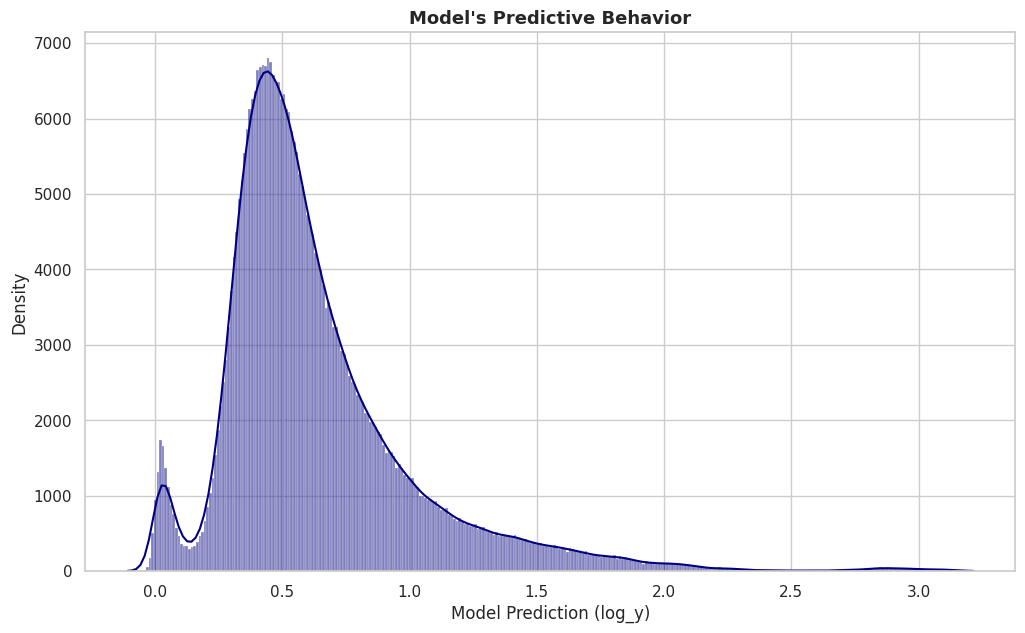

In [ ]:

if 'full_test_predictions' not in locals():
    print("Calculating predictions for the full test set...")
    full_test_predictions = champion_model_xgb.predict(X_test)

mean_prediction = np.mean(full_test_predictions)
median_prediction = np.median(full_test_predictions)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(full_test_predictions, kde=True, color='navy', label='Distribution of All Predictions')

plt.title('Model\'s Predictive Behavior', fontsize=13, fontweight='bold')
plt.xlabel('Model Prediction (log_y)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()


--- Generating the XGBoost Daily Mean Absolute Error Plot ---


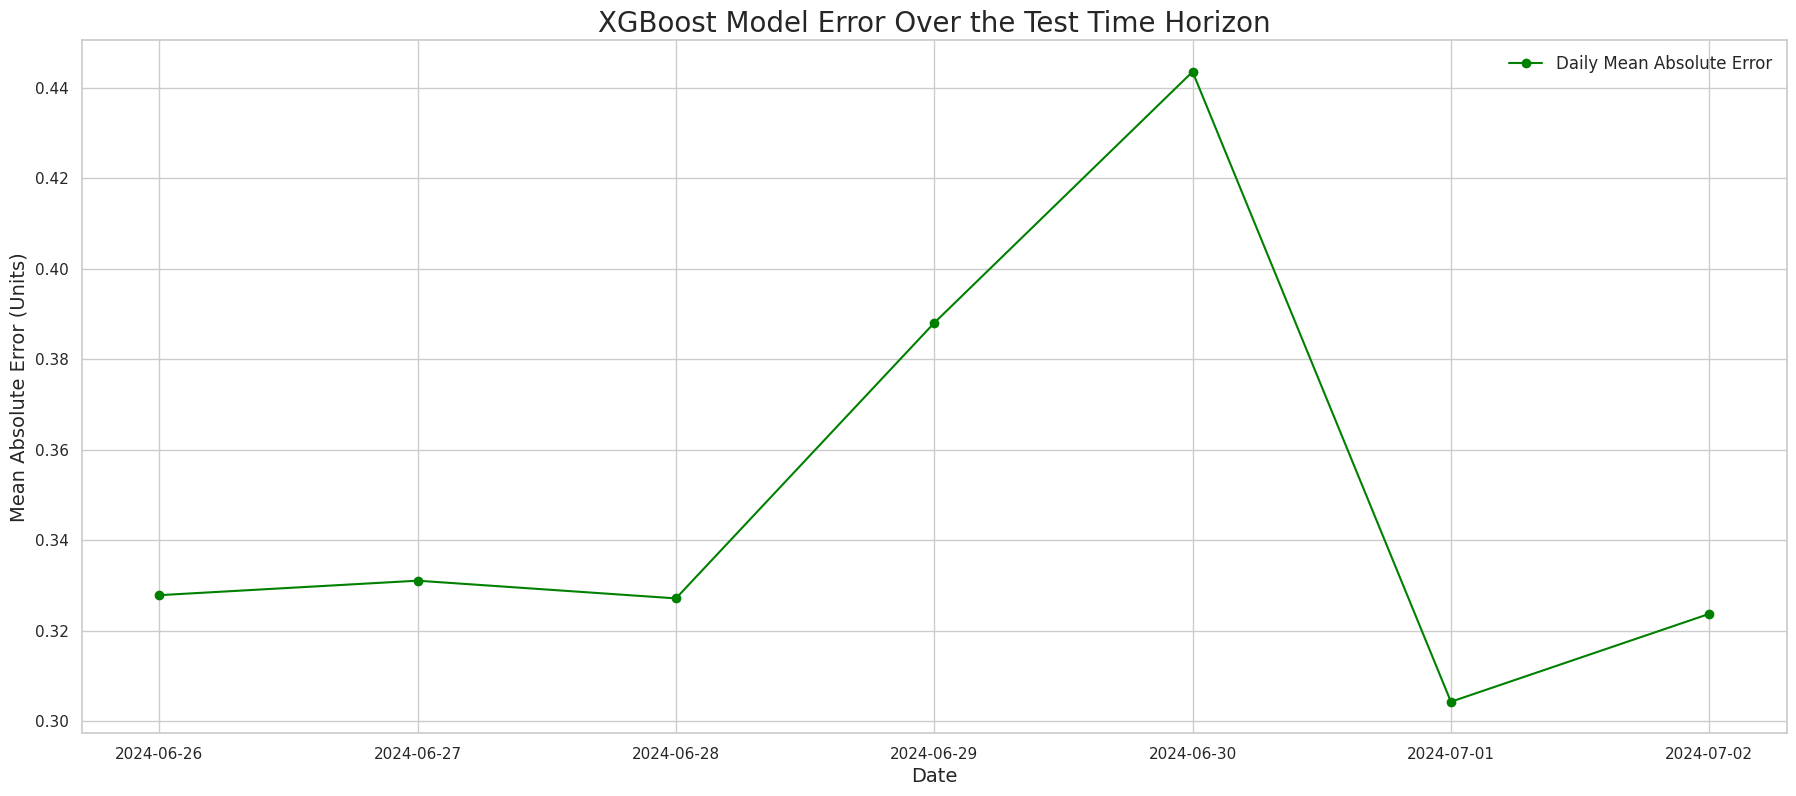

In [ ]:
# ===================================================================
# CELL 2: Generate the XGBoost Error-Over-Time Plot (Consistent Style)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generating the XGBoost Daily Mean Absolute Error Plot ---")

# --- Step 1: Aggregate the data by date ---
# This groups all predictions for a given day and calculates the average absolute error.
daily_mae_xgb = xgb_analysis_df.groupby('date')['abs_error'].mean()

# --- Step 2: Create the visualization ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(22, 9)) # Use a wide figure

# Plot the data with styling that matches your example
plt.plot(
    daily_mae_xgb.index,
    daily_mae_xgb.values,
    marker='o',
    linestyle='-',
    color='green',
    label='Daily Mean Absolute Error'
)

# --- Step 3: Add titles and labels for a professional finish ---
plt.title('XGBoost Model Error Over the Test Time Horizon', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Absolute Error (Units)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

--- Generating the Corrected XGBoost Scatter Plot ---


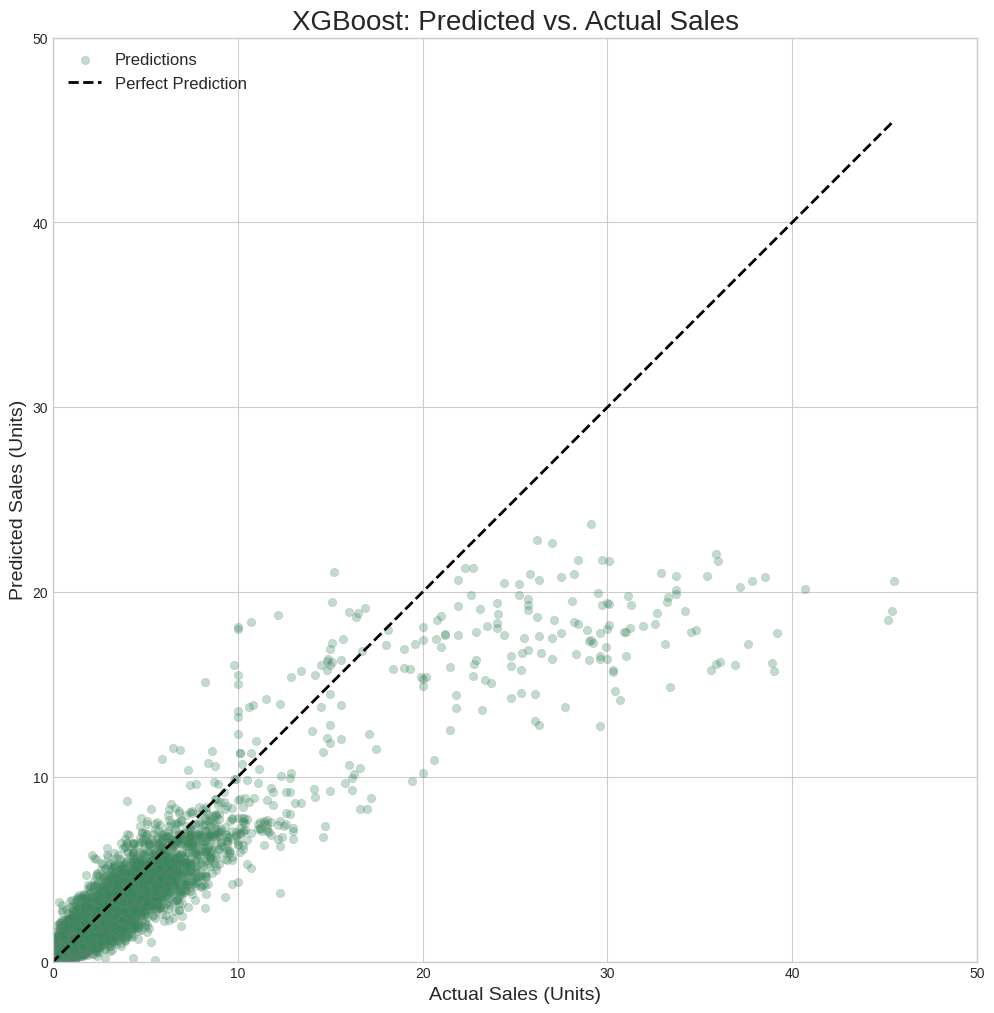

In [ ]:
print("--- Generating the Corrected XGBoost Scatter Plot ---")

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 12))

# Sample the data for a cleaner plot, just like before.
# Now len(xgb_analysis_df) is 350,000
df_to_plot = xgb_analysis_df.sample(
    n=min(50000, len(xgb_analysis_df)),
    random_state=42
).copy()

sns.scatterplot(
    x='y_true',
    y='y_pred',
    data=df_to_plot,
    alpha=0.3,
    color='seagreen',
    edgecolor='gray',
    linewidth=0.5,
    label='Predictions'
)

# Find the overall min/max for the perfect prediction line to match the data
min_val = min(df_to_plot['y_true'].min(), df_to_plot['y_pred'].min())
max_val = max(df_to_plot['y_true'].max(), df_to_plot['y_pred'].max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='black',
    linestyle='--',
    linewidth=2,
    label='Perfect Prediction'
)

plt.title('XGBoost: Predicted vs. Actual Sales', fontsize=20)
plt.xlabel('Actual Sales (Units)', fontsize=14)
plt.ylabel('Predicted Sales (Units)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# Optional but recommended: Set axis limits to match your other plots for a direct comparison
plt.xlim(0, 50)
plt.ylim(0, 50)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# LSTM

In [62]:
# Define the baseline model architecture
N_TIMESTEPS = X_train_lstm.shape[1]
N_FEATURES = X_train_lstm.shape[2]

In [63]:
# --- Baseline Evaluation ---
val_preds_scaled = baseline_model.predict(X_val_lstm, verbose=0)

# 1. CLIP: Prevent "crazy" numbers
val_preds_scaled = np.clip(val_preds_scaled, 0, 1)

# 2. INVERSE: Use scaler_y directly
val_preds_log = scaler_y.inverse_transform(val_preds_scaled).ravel()
val_preds_orig = np.expm1(val_preds_log)

# Metrics
baseline_log_rmse = np.sqrt(mean_squared_error(y_val_true_log, val_preds_log))
baseline_wape = np.sum(np.abs(y_val_true_orig - val_preds_orig)) / (np.sum(y_val_true_orig) + 1e-9)
baseline_mae = mean_absolute_error(y_val_true_orig, val_preds_orig)

print(f"\nBaseline LSTM Performance (Validation):")
print(f"  LOG RMSE: {baseline_log_rmse:.4f}")
print(f"  WAPE:     {baseline_wape:.2%}")
print(f"  MAE:      {baseline_mae:.4f}")


Baseline LSTM Performance (Validation):
  LOG RMSE: 0.2753
  WAPE:     41.62%
  MAE:      0.4661


In [ ]:

def objective_lstm(trial):
    n_units = trial.suggest_categorical('n_units', [32, 50, 64, 100, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)


    model = Sequential([
        LSTM(units=n_units, activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES)),
        Dropout(rate=dropout_rate),
        Dense(1)
    ])


    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')


    # Early stopping for the individual trial
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    # Pruning callback to stop unpromising trials early
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')


    history = model.fit(
        X_train_lstm, y_train_lstm,
        epochs=50,
        batch_size=128,
        validation_data=(X_val_lstm, y_val_lstm),
        callbacks=[early_stopping, pruning_callback], # Pass both callbacks
        verbose=0
    )


    return min(history.history['val_loss'])


N_TRIALS_LSTM = 30
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5) # Don't prune before the 5th epoch
study_lstm = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42), pruner=pruner)

print(f"\nStarting Optuna search with {N_TRIALS_LSTM} trials and pruning")
with tqdm(total=N_TRIALS_LSTM, desc="Tuning LSTM") as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)
    study_lstm.optimize(objective_lstm, n_trials=N_TRIALS_LSTM, callbacks=[tqdm_callback])



best_trial = study_lstm.best_trial
print(f"Best trial number: {best_trial.number}")
print(f"Best validation loss (MSE): {best_trial.value:.6f}")
print("Best hyperparameters found:")
for key, value in best_trial.params.items():
    print(f"  - {key}: {value}")


In [64]:
best_lstm_params = {
    'n_units': 64,
    'dropout_rate': 0.37311043255955234,
    'learning_rate': 0.0012279424298136227
}

champion_model_lstm = Sequential([
    LSTM(units=best_lstm_params['n_units'], activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES)),
    Dropout(rate=best_lstm_params['dropout_rate']),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate'])
champion_model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

print(best_lstm_params)
champion_model_lstm.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = champion_model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stopping],
    verbose=1
)

{'n_units': 64, 'dropout_rate': 0.37311043255955234, 'learning_rate': 0.0012279424298136227}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,081 (86.25 KB)

 Trainable params: 22,081 (86.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 2/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 3/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 4/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 5/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 6/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 7/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 8/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 9/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 10/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 11/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.00

In [65]:
# --- Champion Evaluation on Test Set ---
print("\nMaking predictions on the unseen test set...")
test_predictions_scaled = champion_model_lstm.predict(X_test_lstm, verbose=0)

# 1. CLIP: Stability for perturbation
test_predictions_scaled = np.clip(test_predictions_scaled, 0, 1)

# 2. INVERSE: Dual-scaling logic
final_predictions_log = scaler_y.inverse_transform(test_predictions_scaled).ravel()
final_predictions_orig = np.expm1(final_predictions_log)

# 3. Final Metrics
final_lstm_rmse_log = np.sqrt(mean_squared_error(y_test_true_log, final_predictions_log))
final_lstm_wape = np.sum(np.abs(y_test_true_orig - final_predictions_orig)) / (np.sum(y_test_true_orig) + 1e-9)
final_lstm_mae = mean_absolute_error(y_test_true_orig, final_predictions_orig)
final_lstm_rmse_orig = np.sqrt(mean_squared_error(y_test_true_orig, final_predictions_orig))

lstm_results = {
    'LOG RMSE': final_lstm_rmse_log,
    'WAPE': final_lstm_wape,
    'MAE': final_lstm_mae,
    'RMSE': final_lstm_rmse_orig
}

results_df = pd.DataFrame({'LSTM Champion (on Test)': lstm_results}).T
print("\n" + "="*50)
print("--- FINAL LSTM MODEL PERFORMANCE (Test Set) ---")
print("="*50)
print(results_df.to_string(formatters={'WAPE':'{:.2%}'.format}))


Making predictions on the unseen test set...

--- FINAL LSTM MODEL PERFORMANCE (Test Set) ---
                         LOG RMSE   WAPE       MAE    RMSE
LSTM Champion (on Test)  0.288998 42.58%  0.507985  0.9387


## Generalization Test

In [67]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ==========================================
# THE UPDATED PERTURBATION ANALYSIS FUNCTION
# ==========================================
def run_lstm_perturbation_v2(model, s_x, s_y, base_df, orig_df, feat_list, target_name, n_timesteps, sigmas):
    rng = np.random.default_rng(42)
    results = []

    # Prepare Ground Truth (Aligned with 7-day lookback)
    y_true_log = orig_df[target_name].iloc[n_timesteps:].values
    y_true_orig = np.expm1(y_true_log)

    def get_processed_sequences(df_input):
        X_raw = df_input[feat_list].astype(float)
        y_raw = df_input[[target_name]].astype(float)
        X_s = s_x.transform(X_raw)
        y_s = s_y.transform(y_raw)
        combined = np.hstack([X_s, y_s])
        X_seq = []
        for i in range(len(combined) - n_timesteps):
            X_seq.append(combined[i : i + n_timesteps, :-1])
        return np.array(X_seq)

    # --- Baseline (Sigma 0) ---
    print("🔄 Calculating Baseline (Sigma 0)...")
    X_base = get_processed_sequences(base_df)
    base_preds_scaled = np.clip(model.predict(X_base, verbose=0), 0, 1)
    base_preds_orig = np.expm1(s_y.inverse_transform(base_preds_scaled).ravel())

    # --- Loop through Sigmas ---
    for s in sigmas:
        df_p = base_df.copy()

        if s > 0:
            for col in PAST_SALES_COLS:
                if col in df_p.columns:
                    df_p[col] = df_p[col].astype(float) + rng.normal(0, s, size=len(df_p))

        X_p = get_processed_sequences(df_p)
        preds_p_scaled = np.clip(model.predict(X_p, verbose=0), 0, 1)

        preds_p_log = s_y.inverse_transform(preds_p_scaled).ravel()
        preds_p_orig = np.expm1(preds_p_log)

        # --- METRICS CALCULATION ---
        drift_mae = np.mean(np.abs(preds_p_orig - base_preds_orig))
        log_rmse = np.sqrt(mean_squared_error(y_true_log, preds_p_log))

        # New: Normal RMSE (Original Scale)
        rmse_orig = np.sqrt(mean_squared_error(y_true_orig, preds_p_orig))

        mae_orig = mean_absolute_error(y_true_orig, preds_p_orig)
        wape = np.sum(np.abs(y_true_orig - preds_p_orig)) / (np.sum(y_true_orig) + 1e-9)

        results.append({
            "Sigma": s,
            "Drift MAE": round(drift_mae, 5),
            "Log RMSE": round(log_rmse, 4),
            "RMSE (Orig)": round(rmse_orig, 4), # Added this
            "MAE (Orig)": round(mae_orig, 4),
            "WAPE": f"{wape:.2%}"
        })
        print(f"✅ Sigma {s} analysis complete.")

    return pd.DataFrame(results)

# ==========================================
# EXECUTE
# ==========================================
lstm_sensitivity_table = run_lstm_perturbation_v2(
    model=champion_model_lstm,
    s_x=scaler_X,
    s_y=scaler_y,
    base_df=test_lstm_base,
    orig_df=test_df_lstm,
    feat_list=FEATURES_LSTM,
    target_name=TARGET_LSTM,
    n_timesteps=N_TIMESTEPS,
    sigmas=SIGMAS
)

print("\n" + "="*60)
print("FINAL LSTM SENSITIVITY ANALYSIS WITH NORMAL RMSE")
print("="*60)
print(lstm_sensitivity_table.to_string(index=False))

🔄 Calculating Baseline (Sigma 0)...
✅ Sigma 0.0 analysis complete.
✅ Sigma 0.01 analysis complete.
✅ Sigma 0.02 analysis complete.
✅ Sigma 0.05 analysis complete.

FINAL LSTM SENSITIVITY ANALYSIS WITH NORMAL RMSE
 Sigma  Drift MAE  Log RMSE  RMSE (Orig)  MAE (Orig)   WAPE
  0.00    0.00000    0.2890       0.9387      0.5080 42.58%
  0.01    0.00459    0.2890       0.9388      0.5080 42.58%
  0.02    0.00927    0.2891       0.9387      0.5081 42.59%
  0.05    0.02313    0.2893       0.9392      0.5085 42.62%


In [37]:
# --- REPLACE YOUR TEST SET PREDICTION LOGIC WITH THIS ---
print("\nMaking predictions on the unseen test set...")
test_predictions_scaled = champion_model_lstm.predict(X_test_lstm, verbose=0)

# 1. CLIP: Prevent "crazy" numbers by keeping predictions in training range [0, 1]
test_predictions_scaled = np.clip(test_predictions_scaled, 0, 1)

# 2. INVERSE: Use scaler_y directly (No dummy_array needed!)
final_predictions_log = scaler_y.inverse_transform(test_predictions_scaled).ravel()
final_predictions_orig = np.expm1(final_predictions_log)

# 3. Calculate metrics
final_lstm_rmse_log = np.sqrt(mean_squared_error(y_test_true_log, final_predictions_log))
final_lstm_wape = np.sum(np.abs(y_test_true_orig - final_predictions_orig)) / (np.sum(y_test_true_orig) + 1e-9)
final_lstm_mae = mean_absolute_error(y_test_true_orig, final_predictions_orig)
final_lstm_rmse_orig = np.sqrt(mean_squared_error(y_test_true_orig, final_predictions_orig))

lstm_results = {'LOG RMSE': final_lstm_rmse_log, 'WAPE': final_lstm_wape, 'MAE': final_lstm_mae, 'RMSE': final_lstm_rmse_orig }
results_df = pd.DataFrame({'LSTM Champion (on Test)': lstm_results}).T
print(results_df.to_string(formatters={'WAPE':'{:.2%}'.format}))


Making predictions on the unseen test set...
                         LOG RMSE   WAPE       MAE      RMSE
LSTM Champion (on Test)  0.280895 41.48%  0.494856  0.939798


## Error Analysis

In [ ]:
# ===================================================================
# CELL 1: Create or Load the LSTM Analysis DataFrame
# ===================================================================
import pandas as pd
import numpy as np

# OPTION 1: If you have already run the evaluation and have the variables in memory
print("--- Creating a unified DataFrame for LSTM error analysis ---")
# This requires aligning predictions with the original test dataframe's features
# We must drop the first N_TIMESTEPS rows from the original feature df to align correctly.
lstm_analysis_df = test_df_analysis.iloc[N_TIMESTEPS:].copy()
lstm_analysis_df['y_pred'] = final_predictions_orig
lstm_analysis_df['error'] = lstm_analysis_df['y'] - lstm_analysis_df['y_pred']
lstm_analysis_df['abs_error'] = lstm_analysis_df['error'].abs()
# Rename 'y' to 'y_true' for consistency
lstm_analysis_df.rename(columns={'y': 'y_true'}, inplace=True)
print("✅ Created 'lstm_analysis_df' from the current session.")


# OPTION 2: If you have restarted the session and saved the file
# print("--- Loading the DETAILED LSTM analysis data from Google Drive ---")
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# ANALYSIS_DATA_PATH = "/content/drive/MyDrive/LSTM_Champion_Model/champion_lstm_ANALYSIS_data.csv"
# lstm_analysis_df = pd.read_csv(ANALYSIS_DATA_PATH, parse_dates=['date'])
# print("✅ 'lstm_analysis_df' for the TEST SET is now in memory.")

display(lstm_analysis_df[['date', 'sku_store_id', 'y_true', 'y_pred', 'error']].head())

--- Creating a unified DataFrame for LSTM error analysis ---


NameError: name 'test_df_analysis' is not defined

--- Generating Predicted vs. Actual plot for the LSTM Model ---


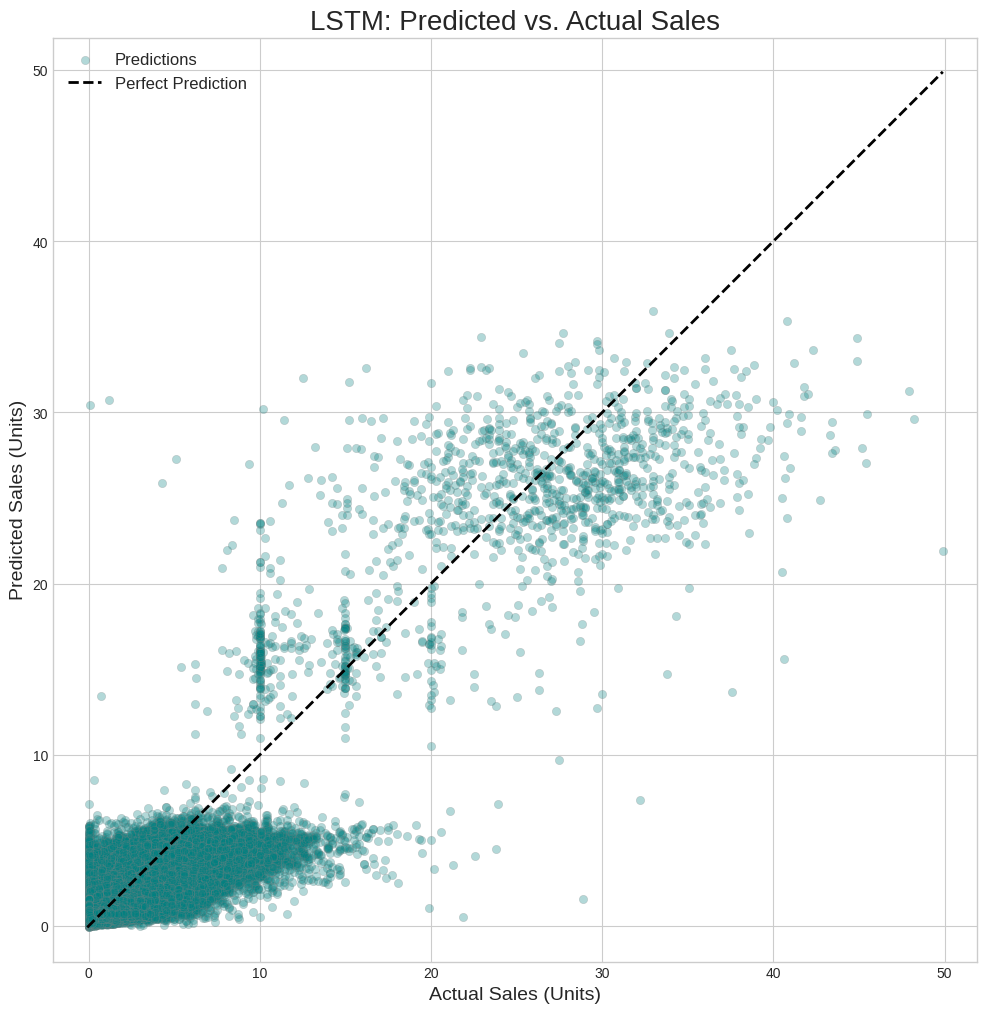

In [ ]:
# ===================================================================
# CELL: LSTM - Predicted vs. Actual Plot (with DIAGONAL Line)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating Predicted vs. Actual plot for the LSTM Model ---")

# This assumes 'lstm_analysis_df' is loaded and available from the previous step.

plt.figure(figsize=(12, 12)) # Use a square figure for a better aspect ratio

# --- Create the scatter plot with styling ---
# X-axis is the TRUE value, Y-axis is the PREDICTED value.
sns.scatterplot(
    x='y_true',
    y='y_pred',
    data=lstm_analysis_df,
    alpha=0.3,
    color='teal',   # Consistent color for LSTM
    edgecolor='gray',
    linewidth=0.5,
    label='Predictions'
)

# --- Create the DIAGONAL "Perfect Prediction" line ---
min_val = min(lstm_analysis_df['y_true'].min(), lstm_analysis_df['y_pred'].min())
max_val = max(lstm_analysis_df['y_true'].max(), lstm_analysis_df['y_pred'].max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='black',
    linestyle='--',
    linewidth=2,
    label='Perfect Prediction'
)

# --- Add titles and labels ---
plt.title('LSTM: Predicted vs. Actual Sales', fontsize=20)
plt.xlabel('Actual Sales (Units)', fontsize=14)
plt.ylabel('Predicted Sales (Units)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# --- CRITICAL: Enforce the square aspect ratio ---
# This ensures the 'Perfect Prediction' line is a true 45-degree diagonal.
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(min_val - 2, max_val + 2)
plt.ylim(min_val - 2, max_val + 2)

plt.show()

## Predictive Behavior

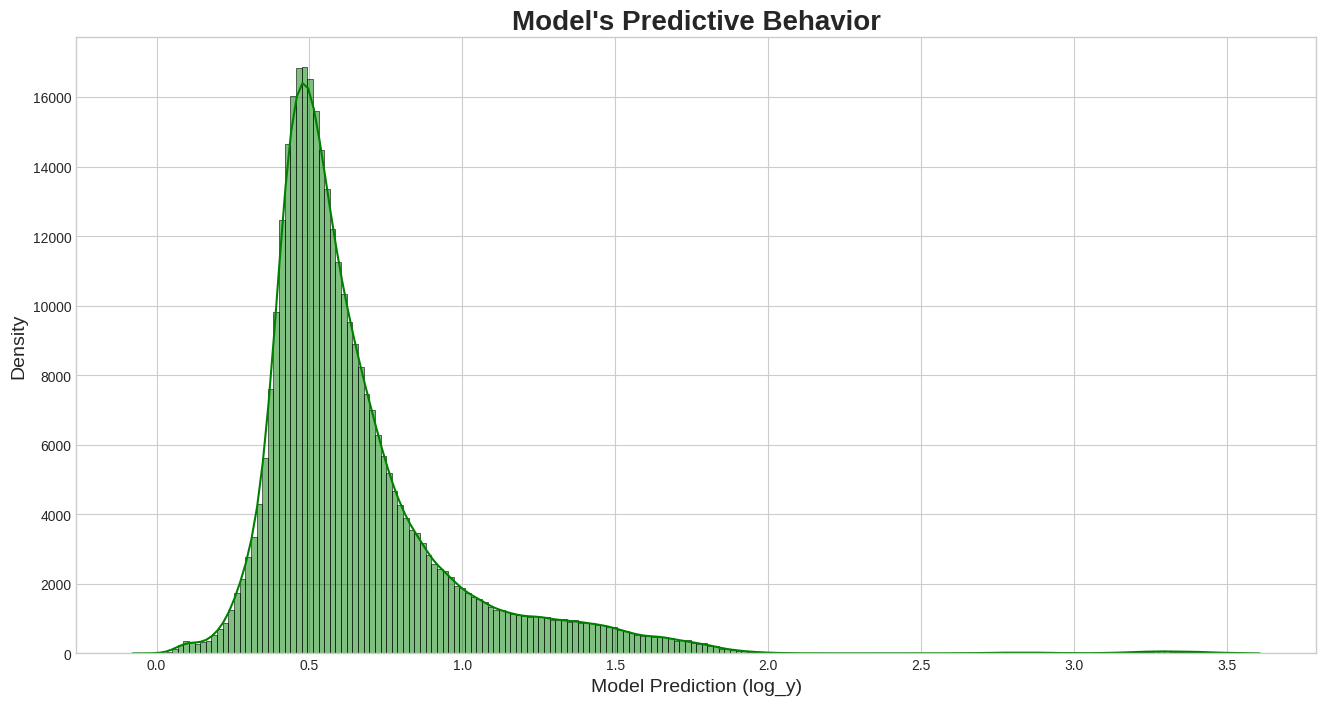

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

# Create the histogram and density plot
# use the log-transformed predictions to see the model's underlying behavior
sns.histplot(final_predictions_log, kde=True, color='green', bins=200)

plt.title("Model's Predictive Behavior", fontsize=20, fontweight='bold')
plt.xlabel("Model Prediction (log_y)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

## LSTM Error Over Time

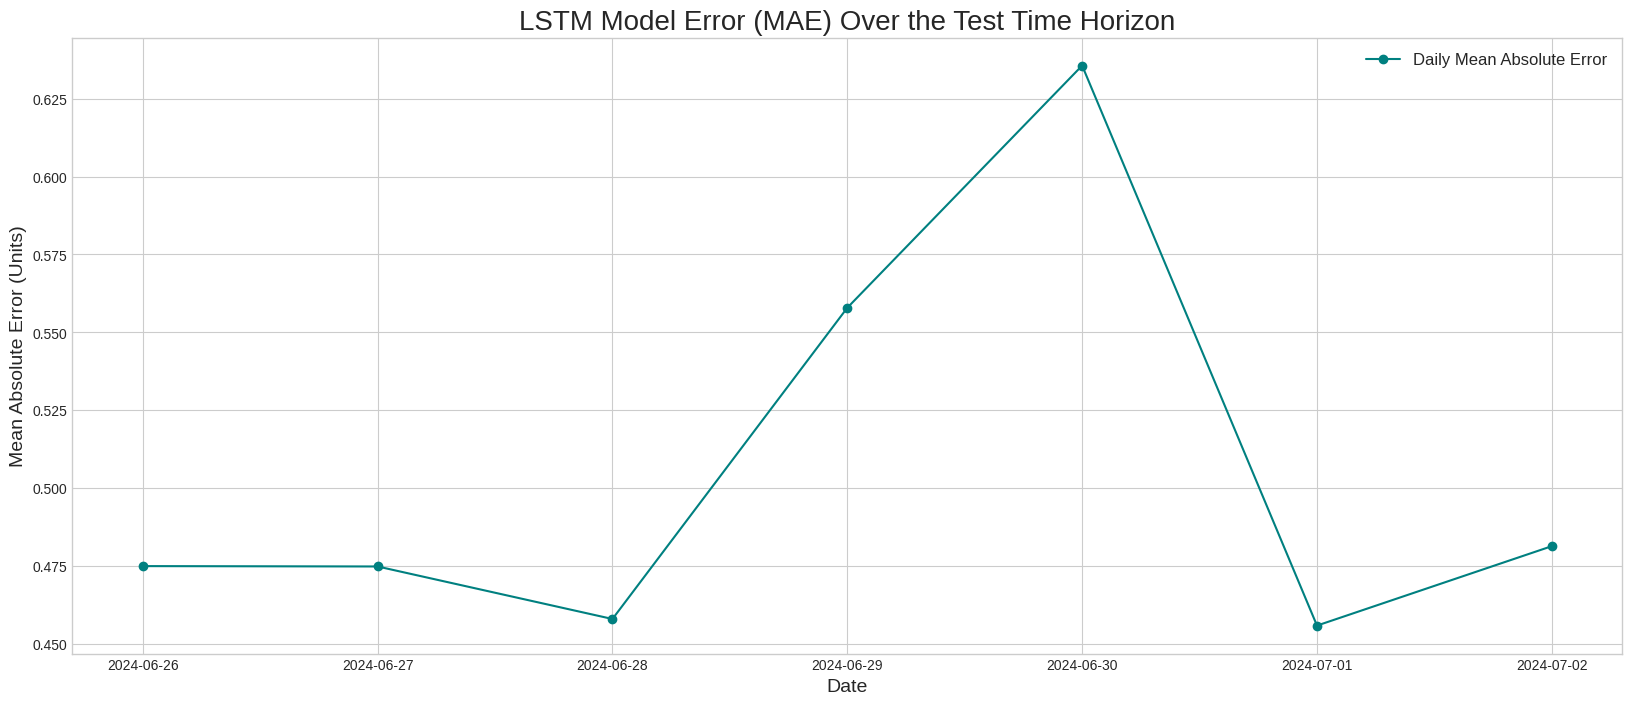

In [ ]:
error_df = pd.DataFrame({
    'y_true': y_test_true_orig,
    'y_pred': final_predictions_orig
})
error_df['abs_error'] = (error_df['y_true'] - error_df['y_pred']).abs()

# Add the 'date' column and Calculate the Daily Mean Absolute Error ---
# Align the dates from the test_df_lstm, which corresponds to the sliced sequences
aligned_dates = test_df_lstm['date'].iloc[N_TIMESTEPS:].reset_index(drop=True)
error_df['date'] = aligned_dates

daily_mae = error_df.groupby('date')['abs_error'].mean()

plt.figure(figsize=(20, 8))

plt.plot(daily_mae.index, daily_mae.values, marker='o', linestyle='-', color='teal', label='Daily Mean Absolute Error')

plt.title("LSTM Model Error (MAE) Over the Test Time Horizon", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Mean Absolute Error (Units)", fontsize=14)
plt.legend(fontsize=12)
plt.show()

# Combined Error Analysis

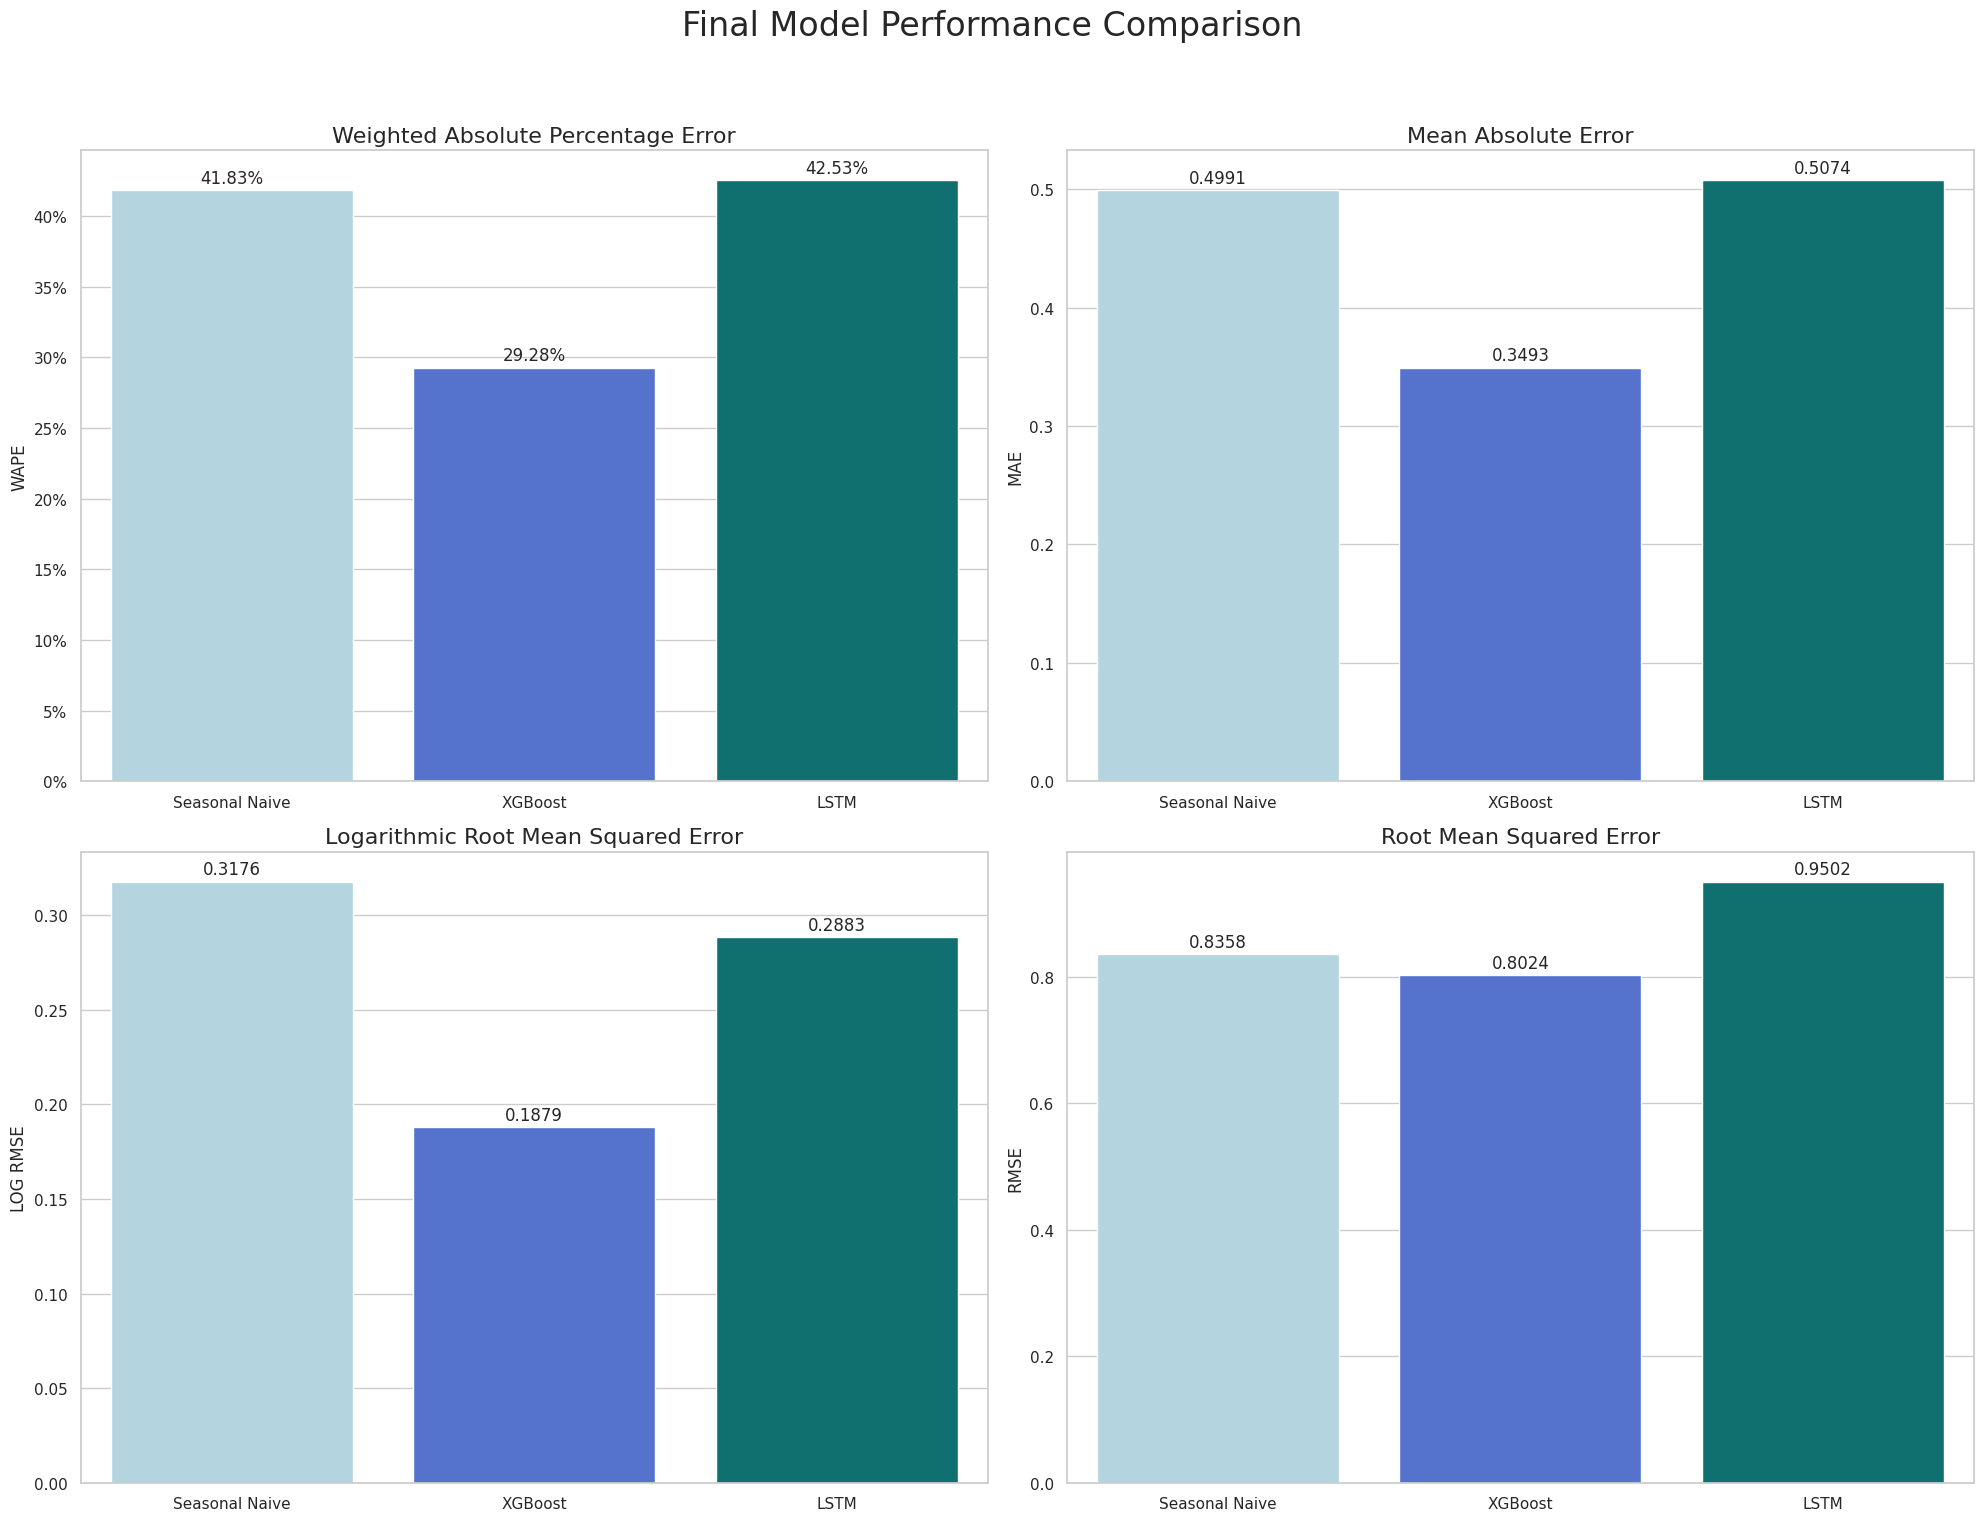

In [ ]:
# ===================================================================
# CELL: Final Model Performance Comparison (2x2 Bar Charts)
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Input the Final Results Data ---
# I have transcribed the data you provided into a structured dictionary.
final_results_data = {
    'Seasonal Naive': {
        'LOG RMSE': 0.317565,
        'WAPE': 0.4183, # Converted from 41.83%
        'MAE': 0.499071,
        'RMSE': 0.835819
    },
    'XGBoost': {
        'LOG RMSE': 0.187893,
        'WAPE': 0.2928, # Converted from 29.28%
        'MAE': 0.349346,
        'RMSE': 0.802428
    },
    'LSTM': {
        'LOG RMSE': 0.288323,
        'WAPE': 0.4253, # Converted from 42.53%
        'MAE': 0.507361,
        'RMSE': 0.950218
    }
}

# Create a DataFrame and set the model name as the index
results_df = pd.DataFrame(final_results_data).T
results_df.index.name = 'Model'

# --- Step 2: Define the Consistent Color Palette for the Models ---
# Using the colors from our previous visualizations
model_colors = {
    'Seasonal Naive': 'lightblue',
    'XGBoost': 'royalblue',
    'LSTM': 'teal'
}

# --- Step 3: Create the 2x2 Grid of Plots ---
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Final Model Performance Comparison', fontsize=24)

# --- Plot 1 (Top-Left): WAPE ---
ax1 = axes[0, 0]
sns.barplot(x=results_df.index, y=results_df['WAPE'], ax=ax1, palette=model_colors)
ax1.set_title('Weighted Absolute Percentage Error', fontsize=16)
ax1.set_ylabel('WAPE')
ax1.set_xlabel('')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# --- Plot 2 (Top-Right): MAE ---
ax2 = axes[0, 1]
sns.barplot(x=results_df.index, y=results_df['MAE'], ax=ax2, palette=model_colors)
ax2.set_title('Mean Absolute Error', fontsize=16)
ax2.set_ylabel('MAE')
ax2.set_xlabel('')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# --- Plot 3 (Bottom-Left): LOG RMSE ---
ax3 = axes[1, 0]
sns.barplot(x=results_df.index, y=results_df['LOG RMSE'], ax=ax3, palette=model_colors)
ax3.set_title('Logarithmic Root Mean Squared Error', fontsize=16)
ax3.set_ylabel('LOG RMSE')
ax3.set_xlabel('')
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# --- Plot 4 (Bottom-Right): Normal RMSE ---
ax4 = axes[1, 1]
sns.barplot(x=results_df.index, y=results_df['RMSE'], ax=ax4, palette=model_colors)
ax4.set_title('Root Mean Squared Error', fontsize=16)
ax4.set_ylabel('RMSE')
ax4.set_xlabel('')
for p in ax4.patches:
    ax4.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

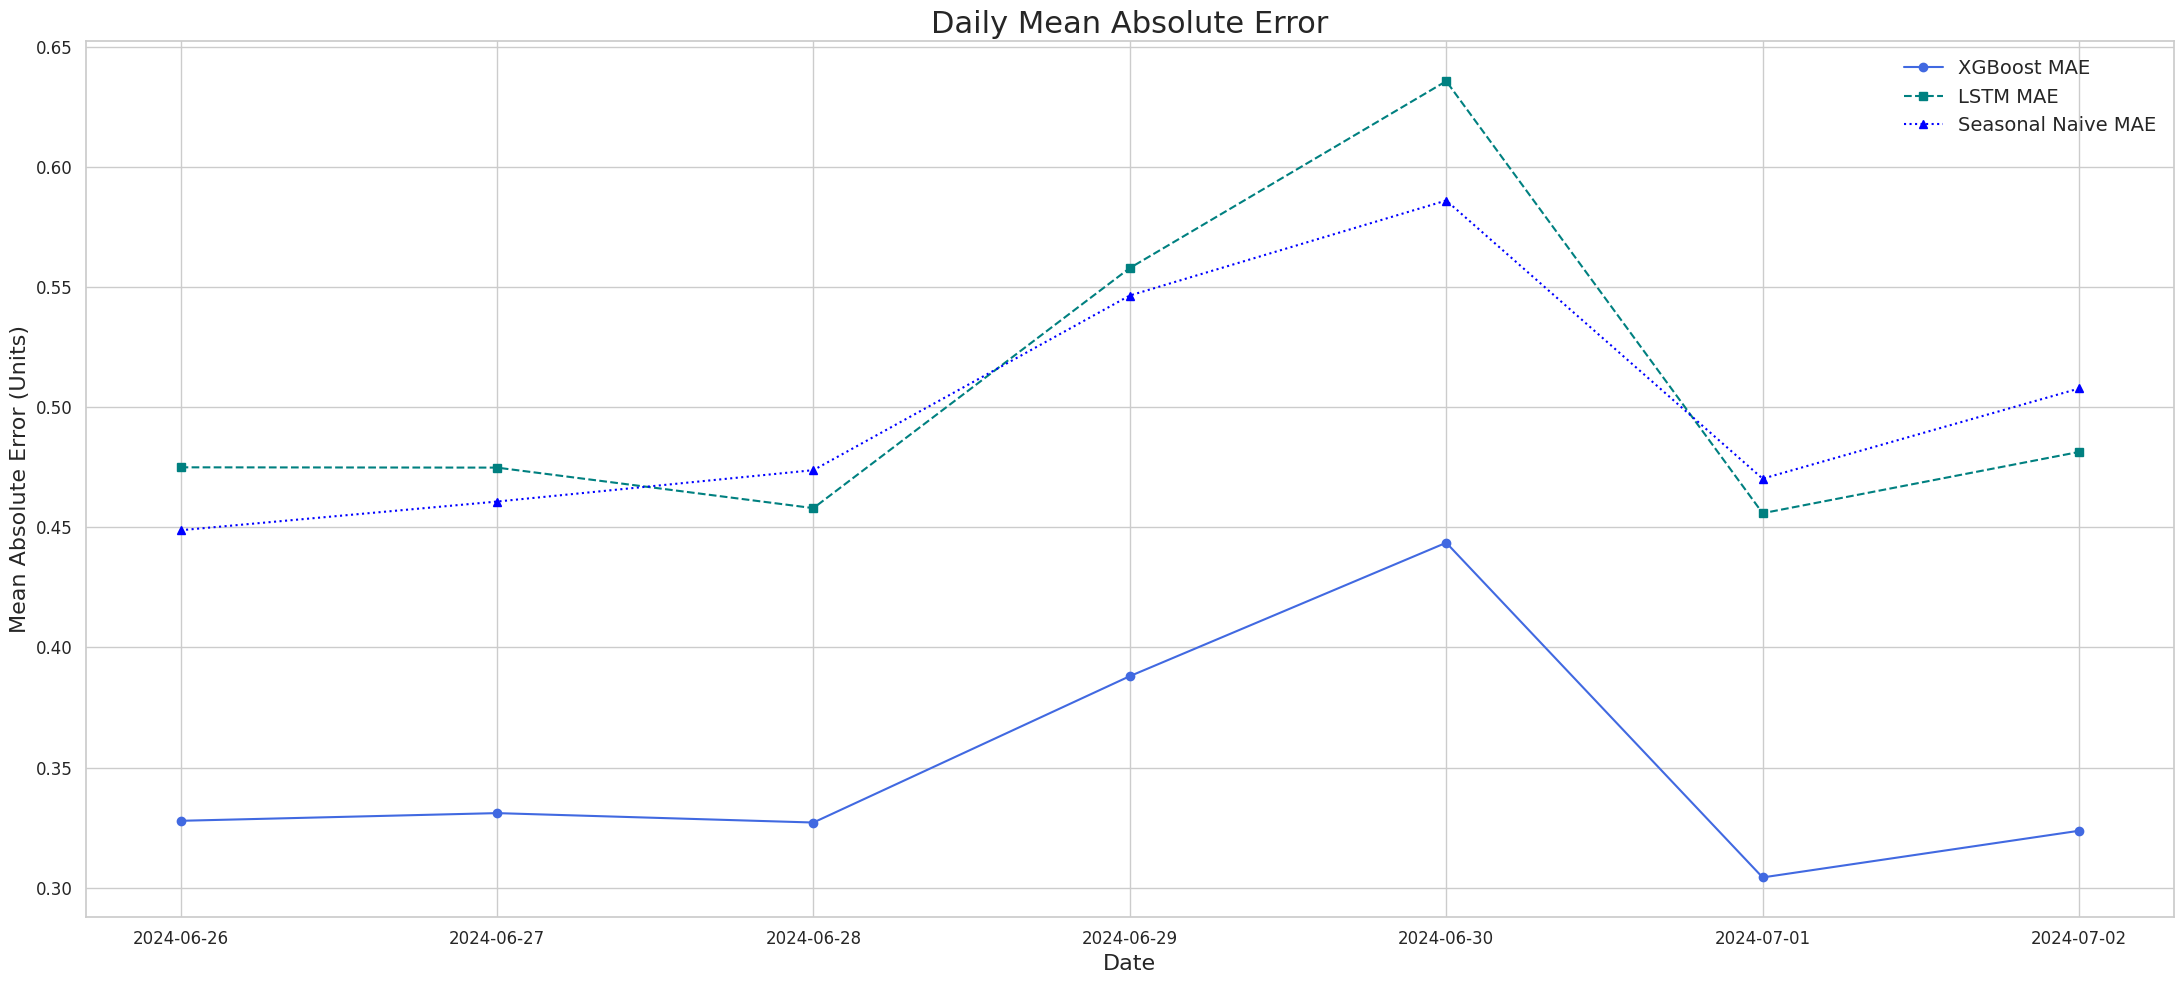

In [ ]:
# ===================================================================
# CELL 2: Create the Final, Combined Error-Over-Time Plot
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(22, 10))

# --- Plot each model's error line if its data was loaded successfully ---

# Plot XGBoost
if xgb_analysis_df is not None:
    daily_mae_xgb = xgb_analysis_df.groupby('date')['abs_error'].mean()
    plt.plot(daily_mae_xgb.index, daily_mae_xgb.values, marker='o', linestyle='-', color='royalblue', label='XGBoost MAE')

# Plot LSTM
if lstm_analysis_df is not None:
    daily_mae_lstm = lstm_analysis_df.groupby('date')['abs_error'].mean()
    plt.plot(daily_mae_lstm.index, daily_mae_lstm.values, marker='s', linestyle='--', color='teal', label='LSTM MAE')

# Plot Seasonal Naive
if baseline_analysis_df is not None:
    daily_mae_baseline = baseline_analysis_df.groupby('date')['abs_error'].mean()
    plt.plot(daily_mae_baseline.index, daily_mae_baseline.values, marker='^', linestyle=':', color='blue', label='Seasonal Naive MAE')

# --- Add titles, labels, and legend for a professional finish ---
plt.title('Daily Mean Absolute Error', fontsize=22)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Mean Absolute Error (Units)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# The legend is crucial for telling the lines apart
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
daily_mae = (
    xgb_analysis_df.groupby("date")["abs_error"].mean().to_frame("mae_xgb")
    .join(lstm_analysis_df.groupby("date")["abs_error"].mean().to_frame("mae_lstm"))
    .join(baseline_analysis_df.groupby("date")["abs_error"].mean().to_frame("mae_snaive"))
    .reset_index()
)

daily_mae

,date,mae_xgb,mae_lstm,mae_snaive
0,2024-06-26,0.327815,0.474924,0.448743
1,2024-06-27,0.331017,0.474805,0.460676
2,2024-06-28,0.327102,0.457941,0.473751
3,2024-06-29,0.388016,0.557866,0.546428
4,2024-06-30,0.443542,0.635636,0.585965
5,2024-07-01,0.304250,0.455824,0.470200
6,2024-07-02,0.323680,0.481327,0.507733


In [ ]:
# Top 2 worst days for XGBoost
problem_days = (
    daily_mae
    .nlargest(2, "mae_xgb")["date"]
    .tolist()
)

problem_days


[Timestamp('2024-06-30 00:00:00'), Timestamp('2024-06-29 00:00:00')]

In [ ]:
test_df_final.columns

Index(['holiday_flag', 'precpt', 'avg_temperature', 'avg_humidity',
       'avg_wind_level', 'sku_store_id', 'date', 'y', 'stockout_ratio_d',
       'dow', 'discount_depth', 'log_y', 'log_y_lag_1d', 'log_y_lag_7d',
       'log_y_roll_mean_7d', 'log_y_roll_std_7d', 'stockout_ratio_lag1d',
       'stockout_ratio_r7d', 'promo_strategy_Non-Price Promo',
       'promo_strategy_Price Penetration', 'promo_strategy_Standard Discount',
       'product_id_target_encoded', 'store_id_target_encoded',
       'city_id_target_encoded', 'management_group_id_target_encoded',
       'first_category_id_target_encoded', 'second_category_id_target_encoded',
       'third_category_id_target_encoded', 'is_problem_day'],
      dtype='object')

In [ ]:
test_df_final["is_problem_day"] = test_df_final["date"].isin(problem_days)

feature_cols = [
    "y",
    "discount_depth",
    "stockout_ratio_d",
    "holiday_flag",
    'promo_strategy_Non-Price Promo',
    'promo_strategy_Price Penetration',
    'promo_strategy_Standard Discount'
]

feature_summary = (
    test_df_final
    .groupby("is_problem_day")[feature_cols]
    .mean()
    .rename(index={False: "normal_days", True: "problem_days"})
)

feature_summary


,y,discount_depth,stockout_ratio_d,holiday_flag,promo_strategy_Non-Price Promo,promo_strategy_Price Penetration,promo_strategy_Standard Discount
is_problem_day,,,,,,,
normal_days,1.094337,0.07814,0.166059,0.0,0.011736,0.174352,0.31466
problem_days,1.439842,0.07885,0.181342,1.0,0.013900,0.185480,0.32403


In [ ]:
# assuming train_df_final has columns: date, holiday_flag

# 1) collapse to day level
daily_holidays = (
    val_df_final
    .groupby("date")["holiday_flag"]
    .max()          # 1 if that day has any holiday rows
    .reset_index()
)

# 2) number of holiday days in the train set
n_holiday_days = daily_holidays["holiday_flag"].sum()

# 3) (optional) total days and share
total_days = len(daily_holidays)
share_holiday_days = n_holiday_days / total_days

print("Holiday days:", n_holiday_days)
print("Total days:", total_days)
print("Share of days that are holidays: {:.2%}".format(share_holiday_days))


Holiday days: 4
Total days: 15
Share of days that are holidays: 26.67%


## Cateogrize Product Groups

In [ ]:
import pandas as pd

# 1. Update the metrics from your screenshots
# These represent the performance achieved during the model selection/tuning phase
val_metrics = {
    'XGBoost': {'MAE': 0.3270, 'WAPE': 29.19, 'RMSE': 0.6748},
    'LSTM': {'MAE': 0.4705, 'WAPE': 42.01, 'RMSE': 0.8694},
    'Seasonal Naive': {'MAE': 0.4544, 'WAPE': 43.13, 'RMSE': 0.7651}
}

# 2. Extract Test MAE from your loaded analysis dataframes
test_results = []
for name, df in [('XGBoost', xgb_analysis_df), ('LSTM', lstm_analysis_df), ('Seasonal Naive', baseline_analysis_df)]:
    t_mae = df['abs_error'].mean()
    v_mae = val_metrics[name]['MAE']

    # Calculate Generalization Gap (Performance Decay)
    gen_gap = ((t_mae - v_mae) / v_mae) * 100

    test_results.append({
        'Model': name,
        'Val MAE (Training Phase)': v_mae,
        'Test MAE (Held-out)': t_mae,
        'Generalization Gap (%)': gen_gap
    })

df_gen_report = pd.DataFrame(test_results)
print("--- TABLE: GENERALIZATION CONTRAST (RUBRIC 4D) ---")
print(df_gen_report.round(4))



--- TABLE: GENERALIZATION CONTRAST (RUBRIC 4D) ---
            Model  Val MAE (Training Phase)  Test MAE (Held-out)  \
0         XGBoost                    0.3270               0.3493   
1            LSTM                    0.4705               0.5055   
2  Seasonal Naive                    0.4544               0.4991   

   Generalization Gap (%)  
0                  6.8336  
1                  7.4336  
2                  9.8307  


NameError: name 'train_metrics' is not defined

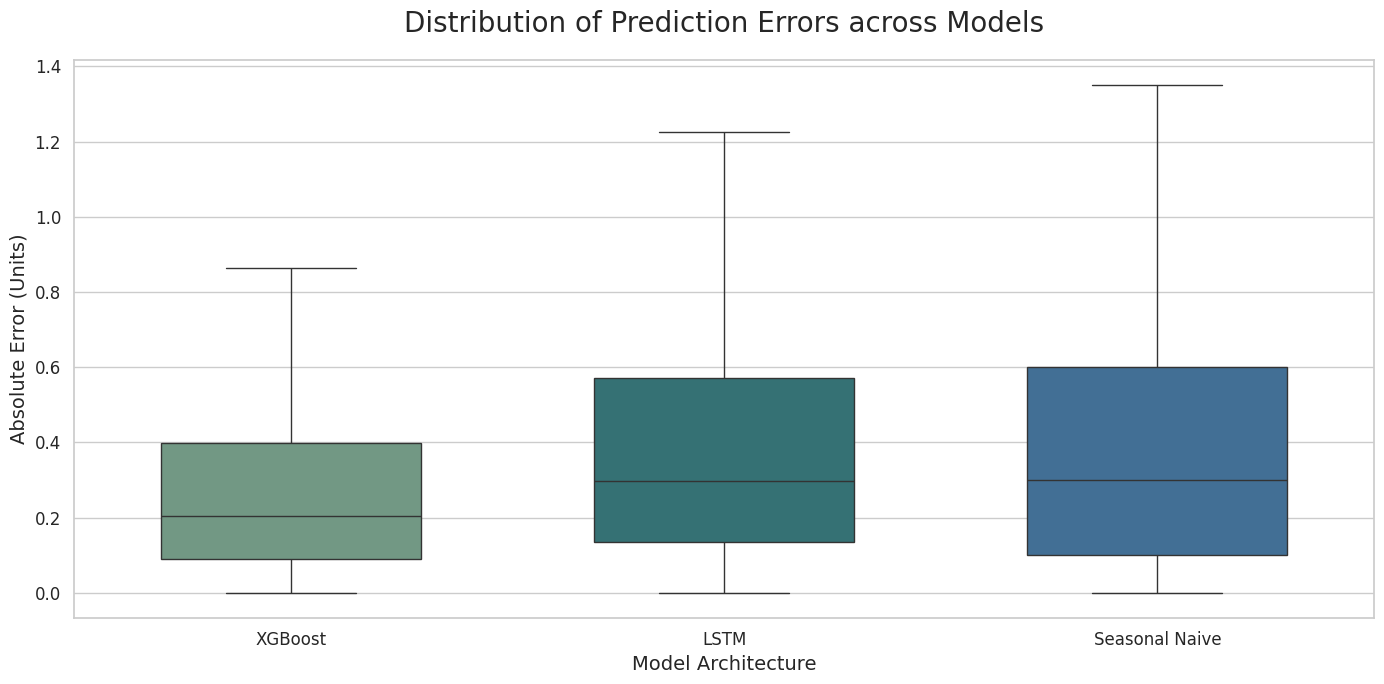

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define the custom palette based on your scatter plots
# Order: XGBoost (Green), LSTM (Teal), Seasonal Naive (Blue)
custom_palette = {
    'XGBoost': '#6c9e83',
    'LSTM': '#2b7b7e',
    'Seasonal Naive': '#3470a3'
}

# 2. Combine data for plotting
# (Assuming your analysis dfs are loaded as xgb_analysis_df, lstm_analysis_df, baseline_analysis_df)
xgb_analysis_df['Model'] = 'XGBoost'
lstm_analysis_df['Model'] = 'LSTM'
baseline_analysis_df['Model'] = 'Seasonal Naive'

combined_df = pd.concat([xgb_analysis_df, lstm_analysis_df, baseline_analysis_df])

# 3. Create the plot
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# We use the 'order' parameter to ensure the X-axis matches your expected sequence
sns.boxplot(
    data=combined_df,
    x='Model',
    y='abs_error',
    palette=custom_palette,
    order=['XGBoost', 'LSTM', 'Seasonal Naive'],
    showfliers=False, # Keeps the plot clean; outliers can be discussed in text
    width=0.6
)

plt.title('Distribution of Prediction Errors across Models', fontsize=20, pad=20)
plt.ylabel('Absolute Error (Units)', fontsize=14)
plt.xlabel('Model Architecture', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# XAI

## Getting a Sample

In [ ]:
# ===================================================================
# CELL 1 (Corrected): Create a Prediction-Stratified Sample for BOTH LIME and SHAP
# ===================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

print("--- Creating a Prediction-Stratified Sample for a Fair XAI Comparison ---")

# --- Step 1: Define the Sample Size ---
SAMPLE_SIZE = 10000

if len(X_test) < SAMPLE_SIZE:
    print(f"Warning: Test set size ({len(X_test)}) is smaller than the desired sample size ({SAMPLE_SIZE}). Using the full test set.")
    SAMPLE_SIZE = len(X_test)

# --- Step 2: Generate Predictions and Create Strata ---
print("Generating predictions on the full test set to create stratification bins...")
full_test_predictions = champion_model_xgb.predict(X_test)

N_BINS = 10
prediction_bins = pd.qcut(full_test_predictions, q=N_BINS, labels=False, duplicates='drop')
print(f"Created {len(np.unique(prediction_bins))} bins to stratify on.")

# --- Step 3: Perform Stratified Sampling ---
print(f"Performing stratified sampling to get {SAMPLE_SIZE} instances...")
X_shap_input, _, _, _ = train_test_split(
    X_test,
    prediction_bins,
    train_size=SAMPLE_SIZE,
    random_state=42,
    stratify=prediction_bins
)

# Create an identical sample for LIME
X_lime_sample = X_shap_input.copy()

print(f"\n✅ Created identical samples for SHAP and LIME.")
print(f"   - Shape of 'X_shap_input': {X_shap_input.shape}")
print(f"   - Shape of 'X_lime_sample': {X_lime_sample.shape}")

--- Creating a Prediction-Stratified Sample for a Fair XAI Comparison ---
Generating predictions on the full test set to create stratification bins...
Created 10 bins to stratify on.
Performing stratified sampling to get 10000 instances...

✅ Created identical samples for SHAP and LIME.
   - Shape of 'X_shap_input': (10000, 25)
   - Shape of 'X_lime_sample': (10000, 25)


--- Verifying the quality of the prediction-stratified sample ---

--- Comparing summary statistics of 'log_y_lag_1d' ---
       Full Test Set   Sampled Set
count  350000.000000  10000.000000
mean        0.657452      0.655967
std         0.442261      0.438209
min         0.000000      0.000000
25%         0.405465      0.405465
50%         0.587787      0.587787
75%         0.832909      0.832909
max         3.895894      3.732896


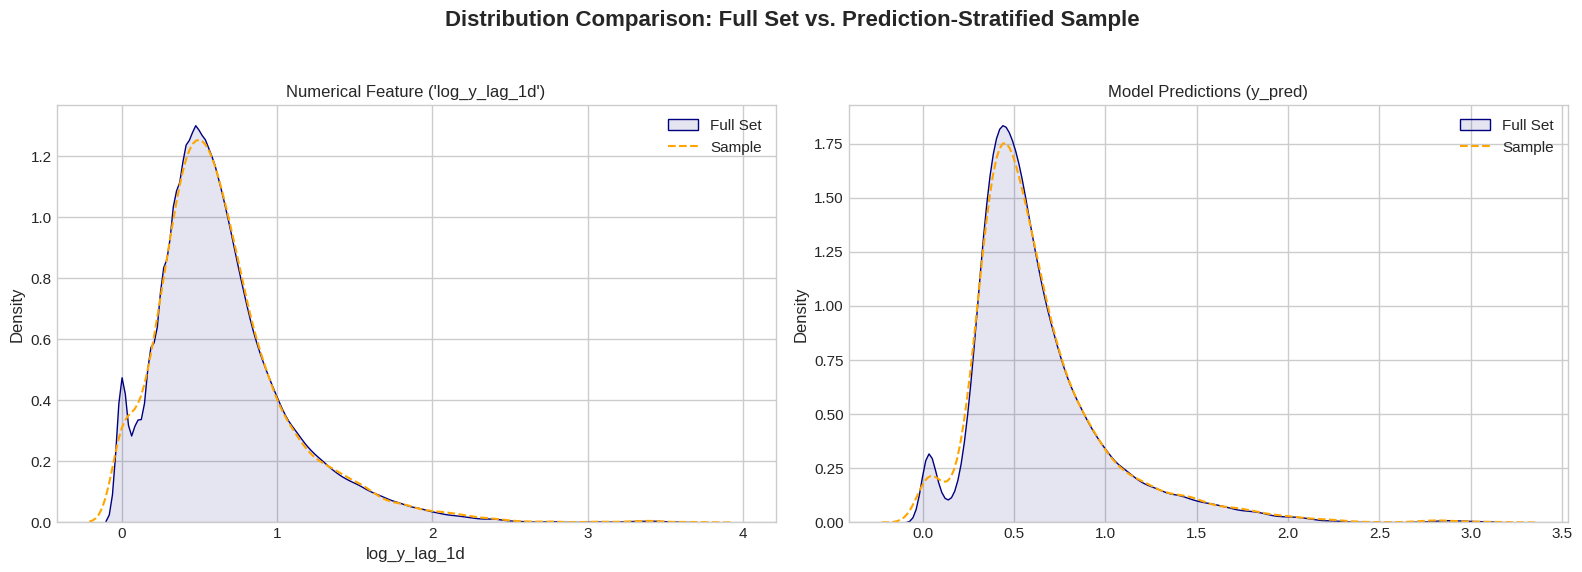

In [ ]:
# ===================================================================
# CELL 2 (New): Verify the Quality of the Stratified Sample
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Verifying the quality of the prediction-stratified sample ---")

# --- Compare Numerical Feature Distributions ---
key_numerical_feature = 'log_y_lag_1d'
print(f"\n--- Comparing summary statistics of '{key_numerical_feature}' ---")
numerical_comparison = pd.DataFrame({
    'Full Test Set': X_test[key_numerical_feature].describe(),
    'Sampled Set': X_shap_input[key_numerical_feature].describe()
})
print(numerical_comparison)

# --- Visual Verification ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribution Comparison: Full Set vs. Prediction-Stratified Sample', fontsize=16, fontweight='bold')

# Plot a numerical feature's density
sns.kdeplot(X_test[key_numerical_feature], ax=axes[0], label='Full Set', color='navy', fill=True, alpha=0.1)
sns.kdeplot(X_shap_input[key_numerical_feature], ax=axes[0], label='Sample', color='orange', linestyle='--')
axes[0].set_title(f"Numerical Feature ('{key_numerical_feature}')")
axes[0].legend()

# Plot the distribution of the predictions themselves
sample_predictions = champion_model_xgb.predict(X_shap_input)
sns.kdeplot(full_test_predictions, ax=axes[1], label='Full Set', color='navy', fill=True, alpha=0.1)
sns.kdeplot(sample_predictions, ax=axes[1], label='Sample', color='orange', linestyle='--')
axes[1].set_title("Model Predictions (y_pred)")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for the suptitle
plt.show()

## SHAP

In [ ]:
#Initializing SHAP Explainer

explainer = None

try:
    # fix the model's base_score for TreeExplainer compatibility
    print("Attempting to fix 'base_score' to enable the fast TreeExplainer...")
    config = champion_model_xgb.get_booster().save_config()
    config_dict = json.loads(config)

    # Check if base_score is a string that needs fixing
    base_score_val = config_dict['learner']['learner_model_param']['base_score']
    if isinstance(base_score_val, str) and '[' in base_score_val:
        new_base_score = float(base_score_val.strip('[]'))
        config_dict['learner']['learner_model_param']['base_score'] = new_base_score
        corrected_config = json.dumps(config_dict)
        champion_model_xgb.get_booster().load_config(corrected_config)
        print(f"Successfully fixed 'base_score' from '{base_score_val}' to '{new_base_score}'.")
    else:
        print("'base_score' is already in the correct format.")

    # Initialize the TreeExplainer
    explainer = shap.TreeExplainer(champion_model_xgb)
    print("\nSHAP is using the fast, model-specific TreeExplainer.")

except Exception as e:
    print("\n🚨 CRITICAL ERROR: Could not initialize the fast TreeExplainer.")
    print(f"   The error was: {e}")
    print("\n   ACTION REQUIRED: The code will not fall back to the slow KernelExplainer.")
    print("   Please debug the issue above or, if you choose to proceed with a slow method,")
    print("   manually implement the KernelExplainer in a new cell.")

Attempting to fix 'base_score' to enable the fast TreeExplainer...
Successfully fixed 'base_score' from '[5.9463465E-1]' to '0.59463465'.

SHAP is using the fast, model-specific TreeExplainer.


In [ ]:
if 'champion_model_xgb' in locals() and champion_model_xgb is not None:
    print(f"Calculating SHAP values for the {len(X_shap_input)} samples")

    explainer = shap.Explainer(champion_model_xgb, X_shap_input)
    shap_values_object = explainer(X_shap_input)

    shap_values = shap_values_object.values

    print(f"\SHAP values calculated successfully. Shape: {shap_values.shape}")

else:
    print("🚨 ERROR: Champion model 'champion_model_xgb' not found.")

Calculating SHAP values for the 10000 samples


100%|===================| 9999/10000 [168:43<00:01]       

\SHAP values calculated successfully. Shape: (10000, 25)


In [25]:
# Creating a df for the analysis
if 'shap_values' in locals() and 'X_shap_input' in locals():
    print("--- Creating 'shap_global_importance_df' from existing SHAP values ---")

    # Take the absolute of all SHAP values
    abs_shap_values = np.abs(shap_values)
    # Calculate the mean of the absolute values for each feature
    mean_abs_shap = np.mean(abs_shap_values, axis=0)

    # Create the 'global_importance_df' DataFrame
    shap_global_importance_df = pd.DataFrame({
        'Feature': X_shap_input.columns,
        'Mean Absolute SHAP': mean_abs_shap
    })

    # Sort the features by their importance
    shap_global_importance_df.sort_values(by='Mean Absolute SHAP', ascending=False, inplace=True)

    print("The 'shap_global_importance_df' DataFrame has been successfully created.")


else:
    print("'shap_values' or 'X_shap_input' not found in the current session.")


--- Creating 'shap_global_importance_df' from existing SHAP values ---
The 'shap_global_importance_df' DataFrame has been successfully created.


### save the shap analysis

In [ ]:
# ===================================================================
# ADD-ON: Save the Complete SHAP Analysis to Google Drive
# ===================================================================
from google.colab import drive
import os
import numpy as np
import json

# This code assumes that 'shap_values', 'X_shap_input', and 'explainer'
# exist in your session from the previous cells.

print("\n" + "="*50)
print("--- SAVING SHAP ANALYSIS ARTIFACTS TO GOOGLE DRIVE ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define a dedicated folder for your SHAP results
SHAP_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis"
os.makedirs(SHAP_DIR, exist_ok=True)

# 3. Define the paths for each file
SHAP_VALUES_PATH = os.path.join(SHAP_DIR, "shap_values.npy")
SHAP_INPUT_PATH = os.path.join(SHAP_DIR, "shap_input_data.csv")
SHAP_METADATA_PATH = os.path.join(SHAP_DIR, "shap_metadata.json")

# 4. Save each artifact using the best method for its type

#   a) Save the shap_values NumPy array using np.save (efficient binary format)
np.save(SHAP_VALUES_PATH, shap_values)
print(f"✅ SHAP values array saved to: {SHAP_VALUES_PATH}")

#   b) Save the X_shap_input DataFrame to a CSV
X_shap_input.to_csv(SHAP_INPUT_PATH, index=True) # index=True is crucial
print(f"✅ SHAP input data saved to: {SHAP_INPUT_PATH}")

#   c) Save the explainer's base value to a JSON for easy loading
shap_metadata = {'expected_value': explainer.expected_value}
with open(SHAP_METADATA_PATH, 'w') as f:
    json.dump(shap_metadata, f)
print(f"✅ SHAP metadata (base value) saved to: {SHAP_METADATA_PATH}")

print("\n\n🎉🎉🎉 ALL DONE. Your SHAP analysis is now permanently saved. 🎉🎉🎉")


--- SAVING SHAP ANALYSIS ARTIFACTS TO GOOGLE DRIVE ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ SHAP values array saved to: /content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis/shap_values.npy
✅ SHAP input data saved to: /content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis/shap_input_data.csv
✅ SHAP metadata (base value) saved to: /content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis/shap_metadata.json


🎉🎉🎉 ALL DONE. Your SHAP analysis is now permanently saved. 🎉🎉🎉


--- Loading all saved SHAP artifacts from Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ SHAP values loaded. Shape: (10000, 25)
✅ SHAP input data loaded. Shape: (10000, 25)
✅ SHAP base value loaded: 0.6094670440523025

🎉 All data loaded. You can now run any of your visualization cells instantly.

--- Example: Generating Global Bar Plot ---


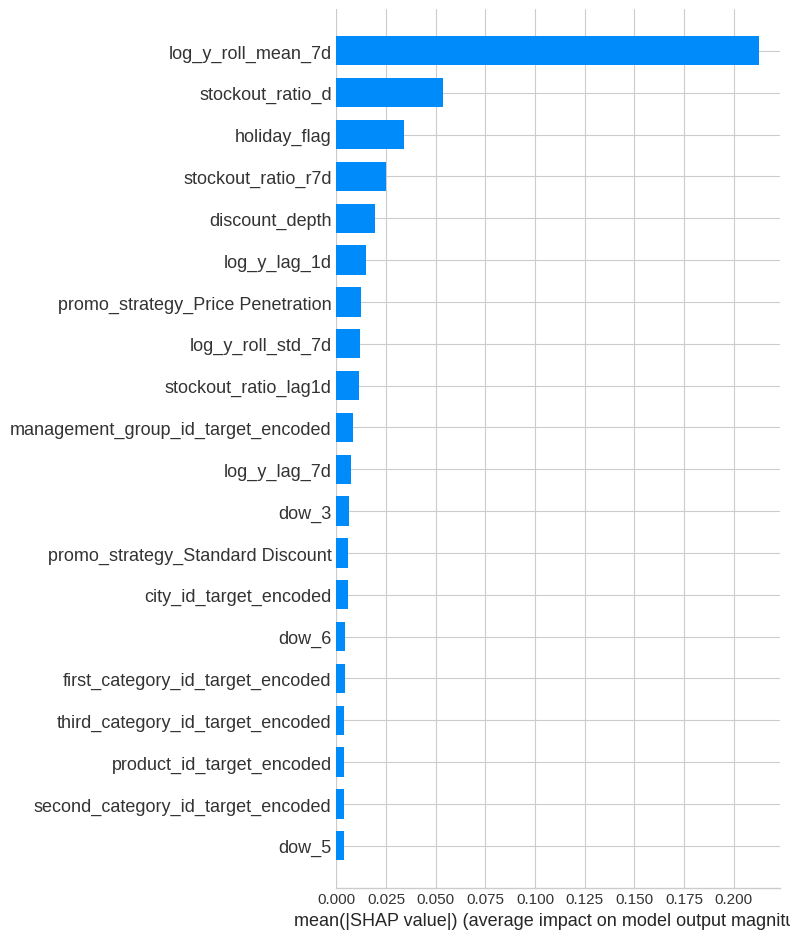


--- Example: Generating Local Waterfall Plot for instance #0 ---


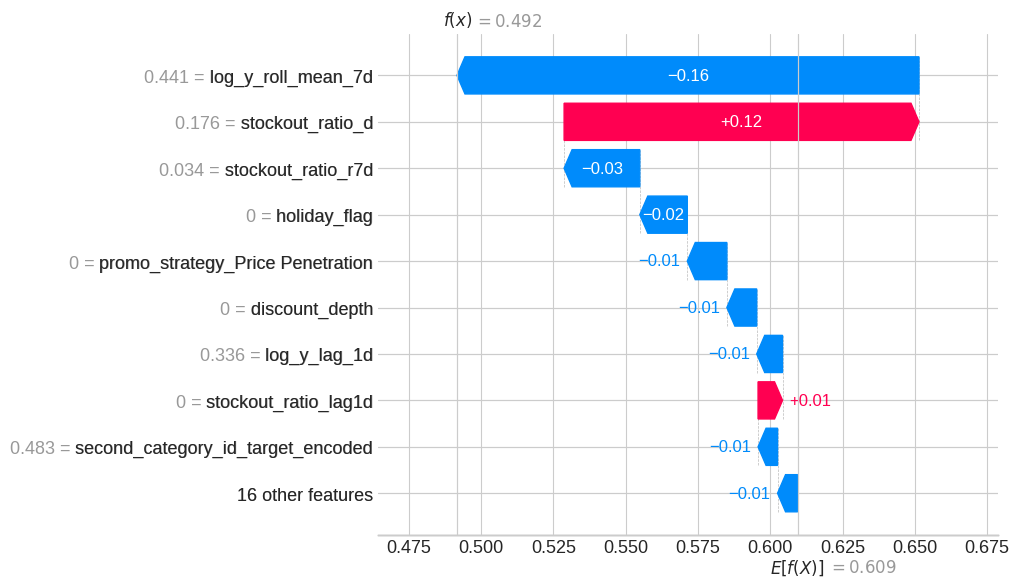

In [24]:
# ===================================================================
# FUTURE WORKFLOW: Load All Saved SHAP Artifacts from Google Drive
# This is the ONLY cell you need to run in the future to do SHAP analysis.
# ===================================================================
import pandas as pd
import numpy as np
import json
import shap
from google.colab import drive
import os

print("--- Loading all saved SHAP artifacts from Google Drive ---")
drive.mount('/content/drive')

# --- 1. Define Paths ---
SHAP_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis"
SHAP_VALUES_PATH = os.path.join(SHAP_DIR, "shap_values.npy")
SHAP_INPUT_PATH = os.path.join(SHAP_DIR, "shap_input_data.csv")
SHAP_METADATA_PATH = os.path.join(SHAP_DIR, "shap_metadata.json")

# --- 2. Load the Artifacts into Memory ---
#    (Includes error checking to ensure files exist)

if not os.path.exists(SHAP_DIR):
    raise FileNotFoundError(f"SHAP directory not found at {SHAP_DIR}. Please run the saving script first.")

# Load the SHAP values array
shap_values = np.load(SHAP_VALUES_PATH)
print(f"✅ SHAP values loaded. Shape: {shap_values.shape}")

# Load the input data. index_col=0 is crucial.
# Make sure to parse dates if your index is a date.
X_shap_input = pd.read_csv(SHAP_INPUT_PATH, index_col=0, parse_dates=True)
print(f"✅ SHAP input data loaded. Shape: {X_shap_input.shape}")

# Load the base value
with open(SHAP_METADATA_PATH, 'r') as f:
    shap_metadata = json.load(f)
loaded_expected_value = shap_metadata['expected_value']
print(f"✅ SHAP base value loaded: {loaded_expected_value}")


# --- 3. You are now ready to create ANY visualization ---
print("\n🎉 All data loaded. You can now run any of your visualization cells instantly.")


# --- EXAMPLE: Re-creating the Global Bar Plot ---
print("\n--- Example: Generating Global Bar Plot ---")
shap.summary_plot(shap_values, X_shap_input, plot_type="bar", show=True)


# --- EXAMPLE: Re-creating a Local Waterfall Plot ---
print("\n--- Example: Generating Local Waterfall Plot for instance #0 ---")
shap_explanation = shap.Explanation(
    values=shap_values[0],
    base_values=loaded_expected_value,
    data=X_shap_input.iloc[0],
    feature_names=X_shap_input.columns.tolist()
)
shap.waterfall_plot(shap_explanation, show=True)

## continue the shap analysis

Generating Global Feature Importance Plots

Bar Plot - Global Importance:


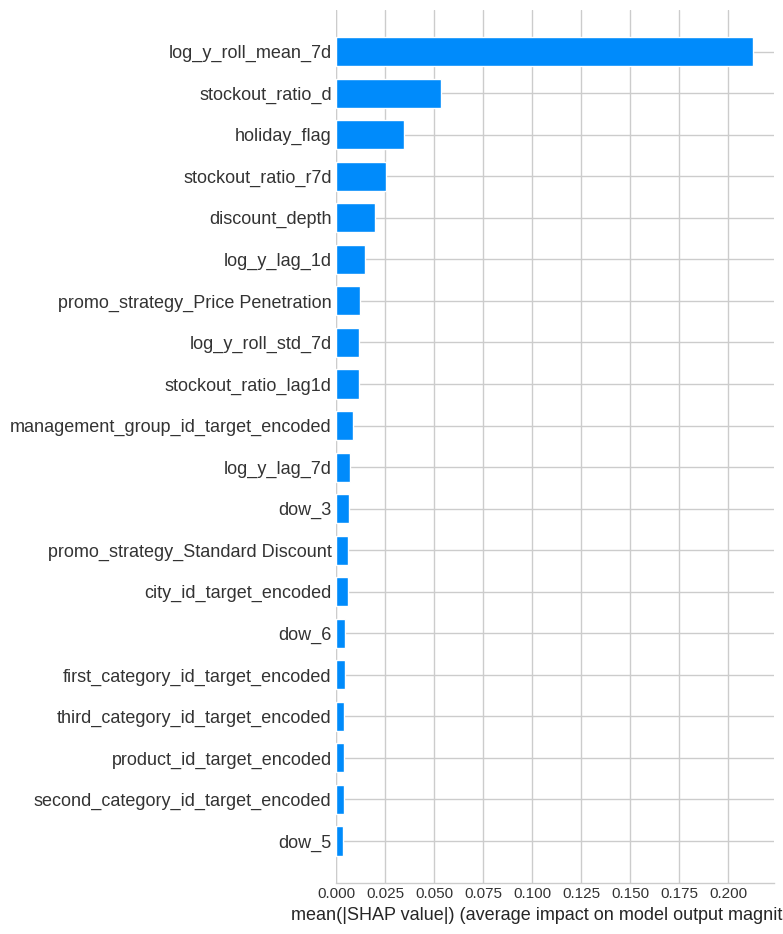


Beeswarm Plot - Importance and Impact:


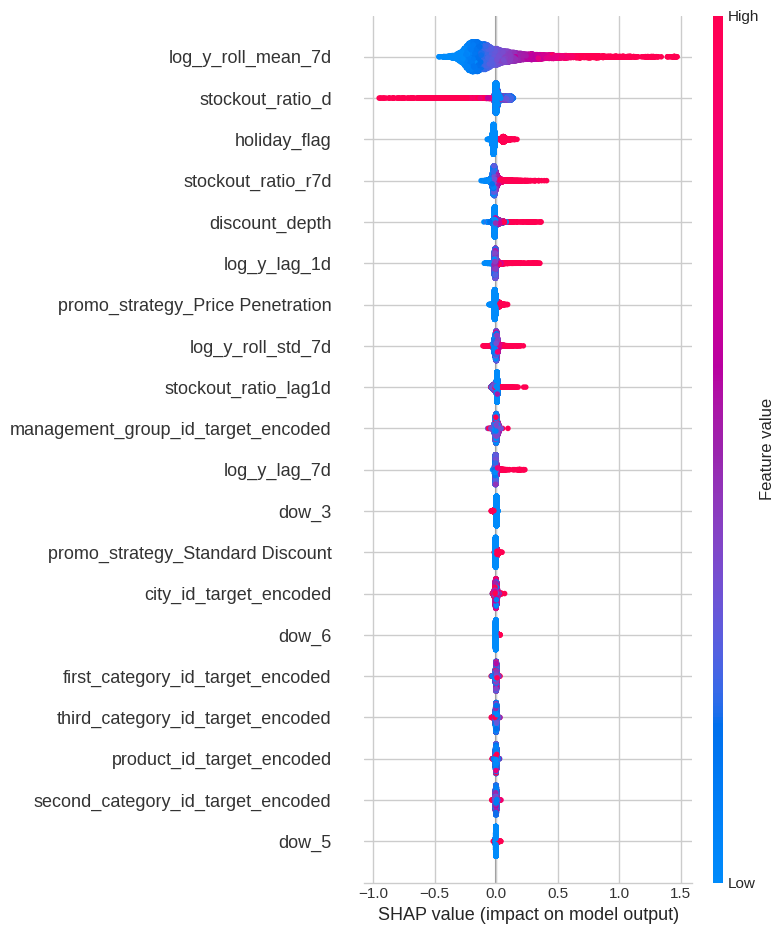

In [ ]:
if 'shap_values' in locals():
    print("Generating Global Feature Importance Plots")

    print("\nBar Plot - Global Importance:")
    shap.summary_plot(shap_values, X_shap_input, plot_type="bar", show=True)

    print("\nBeeswarm Plot - Importance and Impact:")
    shap.summary_plot(shap_values, X_shap_input, plot_type="dot", show=True)
else:
    print("shap_values not found.")

Identified the worst prediction in the sample at index: 214941 (position #7377)
   - Actual Value (log_y): 1.2238
   - Predicted Value (log_y): 0.1536
   - Absolute Error: 1.0702

Generating Local Explanation for this Worst Prediction


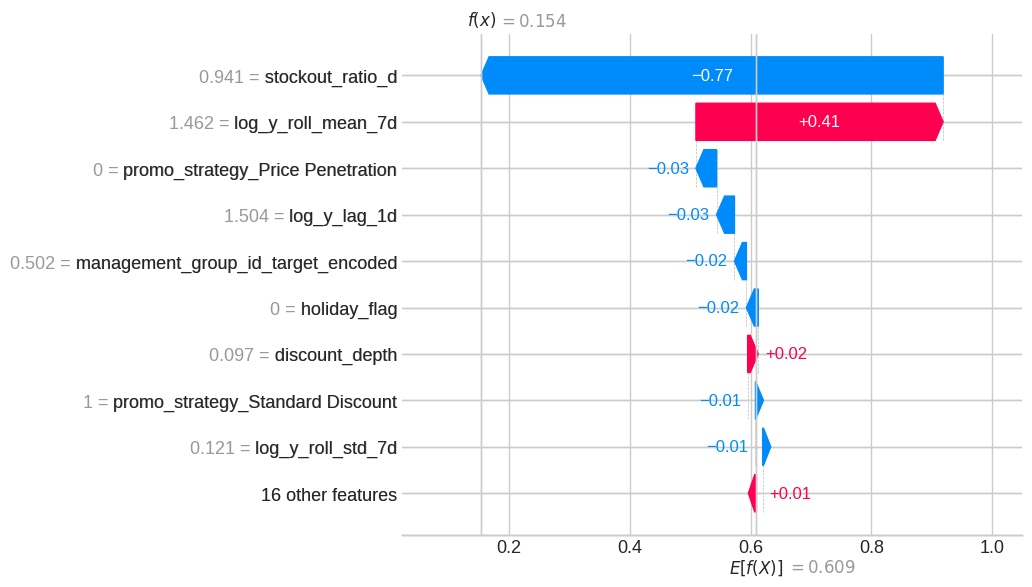

In [ ]:
if 'explainer' in locals() and 'shap_values' in locals():

    # Find the worst prediction in your SHAP sample

    # First, get the model's predictions for the same data used for SHAP
    predictions_on_shap_sample = explainer.model.predict(X_shap_input)

    # Get the corresponding true values
    true_values_for_shap_sample = y_test.loc[X_shap_input.index]

    # Calculate the absolute error for each instance in the sample
    abs_errors = np.abs(true_values_for_shap_sample - predictions_on_shap_sample)

    # Find the index of the instance with the LARGEST absolute error
    worst_prediction_index = abs_errors.idxmax()

    # Get the integer position of this index in the sample dataframe
    instance_iloc = X_shap_input.index.get_loc(worst_prediction_index)

    print(f"Identified the worst prediction in the sample at index: {worst_prediction_index} (position #{instance_iloc})")
    print(f"   - Actual Value (log_y): {true_values_for_shap_sample.loc[worst_prediction_index]:.4f}")
    print(f"   - Predicted Value (log_y): {predictions_on_shap_sample[instance_iloc]:.4f}")
    print(f"   - Absolute Error: {abs_errors.loc[worst_prediction_index]:.4f}")


    # Generate the Local Explanation for this specific instance
    print(f"\nGenerating Local Explanation for this Worst Prediction")

    # Create a SHAP Explanation object for modern plotting
    shap_explanation = shap.Explanation(
        values=shap_values[instance_iloc],
        base_values=explainer.expected_value,
        data=X_shap_input.iloc[instance_iloc],
        feature_names=X_shap_input.columns.tolist()
    )

    # The waterfall plot will now explain why the model made this specific large error
    shap.waterfall_plot(shap_explanation, show=True)

else:
    print("explainer or shap_values not found. Please run previous cells first.")

## LIME

In [ ]:
if 'X_lime_sample' in locals():
    print("Initializing LIME Explainer")

    # Create the LIME Explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns.tolist(),
        mode='regression',
        random_state=42
    )

    # Create an empty array to store the absolute weights for each feature from each explanation.
    all_abs_weights = np.zeros((len(X_lime_sample), len(X_train.columns)))

    print(f"\nGenerating LIME explanations for the {len(X_lime_sample)} samples...")
    print("This may take a while.")

    # Loop through each instance in the sample and get its explanation
    for i in tqdm(range(len(X_lime_sample)), desc="Generating LIME Explanations"):
        instance_to_explain = X_lime_sample.iloc[i]

        explanation = lime_explainer.explain_instance(
            instance_to_explain.values,
            champion_model_xgb.predict,
            num_features=len(X_train.columns)
        )

        # Map the explanation results to the correct feature indices and store the absolute weight
        weight_map = dict(explanation.as_map()[1])
        for feature_idx, weight in weight_map.items():
            all_abs_weights[i, feature_idx] = abs(weight)

    print("\nLIME explanation weights calculated successfully.")
    print("   The results are now stored in the 'all_abs_weights' variable and ready for analysis.")
else:
    print("`X_lime_sample` not found. Please run the setup cell first.")

In [27]:
if 'all_abs_weights' in locals():
    print("--- Calculating Final Global LIME Importance from the stored weights ---")

    # --- This part is very fast ---
    # Calculate the mean of the absolute weights for each feature (column)
    mean_abs_weights = np.mean(all_abs_weights, axis=0)

    # Create a clean DataFrame for display and further analysis
    global_lime_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Mean Absolute LIME Weight': mean_abs_weights
    }).sort_values(by='Mean Absolute LIME Weight', ascending=False)


    print("\nLIME Global Feature Importance (Top 20)")
    print(global_lime_importances.head(20).to_string(index=False))

    print("\nLIME global importance ranking is ready.")
else:
    print("`all_abs_weights` not found. Please run the slow calculation cell (Cell 1) first.")

--- Calculating Final Global LIME Importance from the stored weights ---

LIME Global Feature Importance (Top 20)
                          Feature  Mean Absolute LIME Weight
               log_y_roll_mean_7d                   0.286930
                     holiday_flag                   0.079601
                 stockout_ratio_d                   0.051489
 promo_strategy_Price Penetration                   0.040992
   promo_strategy_Non-Price Promo                   0.037142
               stockout_ratio_r7d                   0.035900
                            dow_3                   0.028309
                   discount_depth                   0.024137
                            dow_6                   0.021442
 promo_strategy_Standard Discount                   0.018790
                log_y_roll_std_7d                   0.018296
             stockout_ratio_lag1d                   0.016929
                            dow_2                   0.012496
                            dow_

--- Generating Professional LIME Local Explanation Plot ---

Explaining prediction for instance: 214941


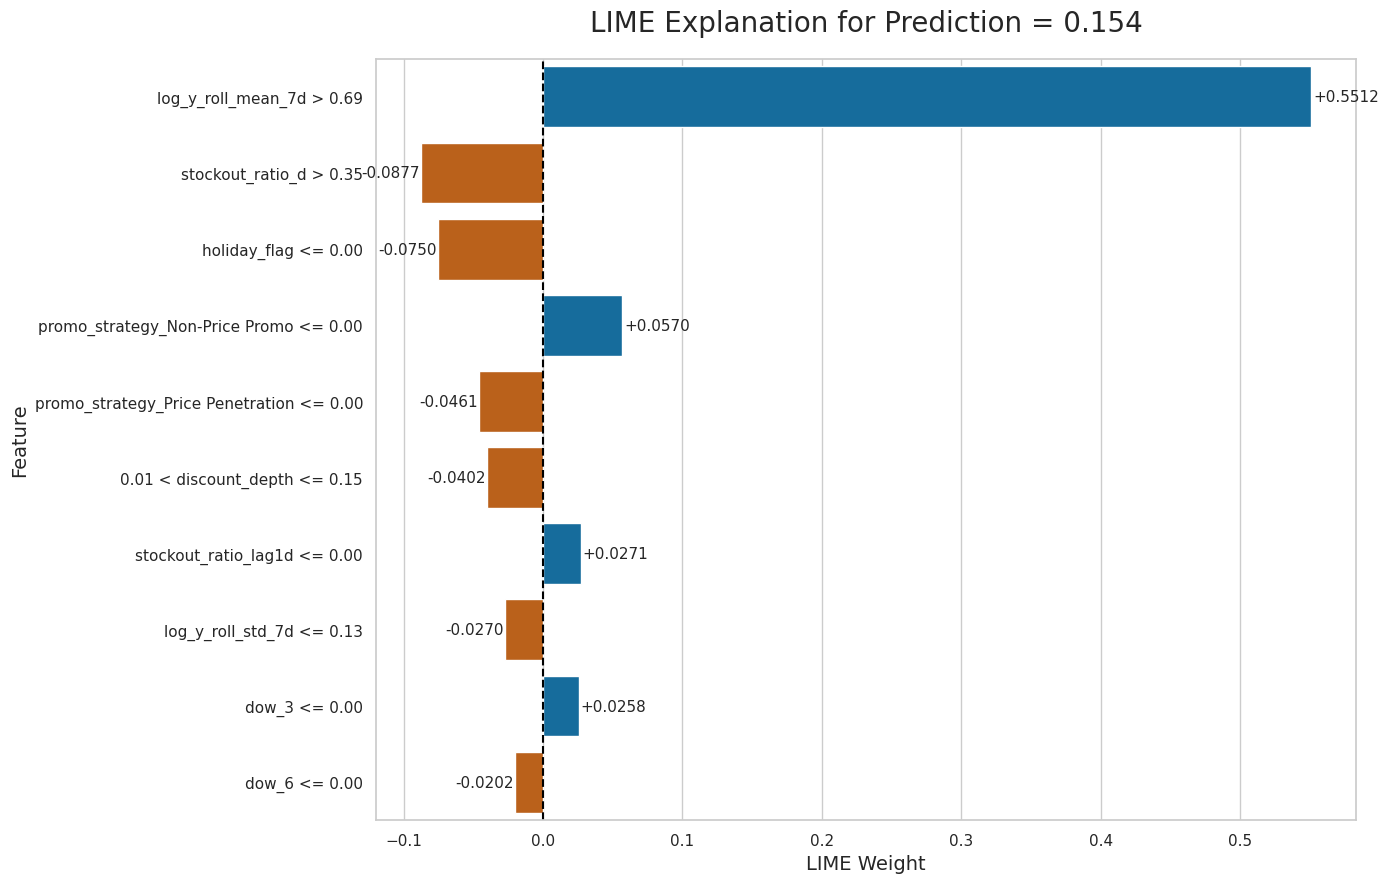

In [ ]:
# ===================================================================
# CELL: Professional LIME Local Explanation Plot
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap

# This check ensures the necessary objects exist.
if 'lime_explainer' in locals() and 'X_shap_input' in locals():
    print("--- Generating Professional LIME Local Explanation Plot ---")

    # --- Step 1: Identify the instance to explain ---
    # We use the same instance as your SHAP analysis for a direct comparison.
    instance_index_to_explain = 214941
    instance_to_explain = X_shap_input.loc[instance_index_to_explain]
    model_prediction = 0.1536 # The known prediction for this instance

    print(f"\nExplaining prediction for instance: {instance_index_to_explain}")

    # --- Step 2: Generate the LIME explanation object ---
    explanation = lime_explainer.explain_instance(
        instance_to_explain.values,
        champion_model_xgb.predict,
        num_features=10
    )

    # --- Step 3: Extract the data from the explanation ---
    # We get the feature-weight pairs and convert them to a pandas DataFrame.
    explanation_list = explanation.as_list()
    lime_df = pd.DataFrame(explanation_list, columns=['feature', 'weight'])

    # Create a column to distinguish positive vs. negative contributions
    lime_df['positive'] = lime_df['weight'] > 0
    # Sort by the absolute weight to show the most impactful features at the top
    lime_df = lime_df.reindex(lime_df.weight.abs().sort_values(ascending=False).index)

    # --- Step 4: Create the professional plot with seaborn ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 9))

    # Define a professional, non-clashing color palette
    palette = {True: "#0072B2", False: "#D55E00"} # Blue for positive, Orange/Red for negative

    # Create the horizontal bar plot
    sns.barplot(
        x='weight',
        y='feature',
        data=lime_df,
        hue='positive', # Use the 'positive' column to color the bars
        palette=palette,
        dodge=False,
        ax=ax,
        legend=False
    )

    # --- Step 5: Add professional titles and annotations ---
    ax.set_title(
        f"LIME Explanation for Prediction = {model_prediction:.3f}",
        fontsize=20,
        pad=20
    )
    ax.set_xlabel("LIME Weight", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)

    # Add value labels to the end of each bar for clarity
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.001 * (-1 if width < 0 else 1), # Position text slightly outside the bar
                p.get_y() + p.get_height() / 2.,
                f'{width:+.4f}',
                ha='left' if width > 0 else 'right',
                va='center',
                fontsize=11)

    plt.tight_layout()
    plt.show()

else:
    print("🚨 ERROR: `lime_explainer` or other necessary objects not found.")

### Save the Results

In [ ]:
# ===================================================================
# CELL: Save the EXISTING LIME Results to Google Drive (Fast)
# Run this cell once to save the 'all_abs_weights' variable from memory.
# ===================================================================
import numpy as np
from google.colab import drive
import os

# First, check if the variable we want to save actually exists in memory.
if 'all_abs_weights' in locals():
    print("--- Found the 'all_abs_weights' variable in the current session. Saving it now... ---")

    # 1. Mount your Google Drive
    drive.mount('/content/drive')

    # 2. Define the directory and path for the saved file
    LIME_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/LIME_Analysis"
    os.makedirs(LIME_DIR, exist_ok=True)
    LIME_WEIGHTS_PATH = os.path.join(LIME_DIR, "all_abs_weights.npy")

    # 3. Save the existing 'all_abs_weights' NumPy array to the file
    np.save(LIME_WEIGHTS_PATH, all_abs_weights)

    print(f"\n✅ The 'all_abs_weights' array has been successfully and permanently saved to: {LIME_WEIGHTS_PATH}")
    print("You will not need to run the long calculation cell again.")

else:
    print("🚨 CRITICAL ERROR: The 'all_abs_weights' variable was not found in the current session.")
    print("   This means the long LIME calculation cell either did not run or did not complete successfully.")
    print("   If you are sure it ran, please check for typos in the variable name.")

--- Found the 'all_abs_weights' variable in the current session. Saving it now... ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ The 'all_abs_weights' array has been successfully and permanently saved to: /content/drive/MyDrive/XGBoost_Champion_Model/LIME_Analysis/all_abs_weights.npy
You will not need to run the long calculation cell again.


In [26]:
# ===================================================================
# CELL: Load the Saved LIME Explanation Weights from Google Drive
# This is your new starting point for LIME analysis in any session.
# ===================================================================
import numpy as np
from google.colab import drive
import os

print("--- Loading the saved LIME weights from Google Drive ---")

# --- Step 1: Mount your Google Drive ---
# A pop-up will appear asking for permission.
drive.mount('/content/drive')

# --- Step 2: Define the EXACT Path to your saved file ---
LIME_WEIGHTS_PATH = "/content/drive/MyDrive/XGBoost_Champion_Model/LIME_Analysis/all_abs_weights.npy"

# --- Step 3: Check if the file exists and load it ---
# This check prevents errors and tells you if the saving step was not completed.
if not os.path.exists(LIME_WEIGHTS_PATH):
    raise FileNotFoundError(
        f"LIME weights file not found at {LIME_WEIGHTS_PATH}. "
        "Please ensure you have run the one-time saving script successfully."
    )

# Load the NumPy array from the file. This is a very fast operation.
all_abs_weights = np.load(LIME_WEIGHTS_PATH)

print(f"\n✅ LIME raw weights ('all_abs_weights') loaded successfully from Drive.")
print(f"   The shape of the loaded array is: {all_abs_weights.shape}")
print("   You can now run your fast analysis cell to generate the global importance table.")

--- Loading the saved LIME weights from Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ LIME raw weights ('all_abs_weights') loaded successfully from Drive.
   The shape of the loaded array is: (10000, 25)
   You can now run your fast analysis cell to generate the global importance table.


# MoRF/ LeRF

In [ ]:
import os
import json

# --- Step 1: Define and Create the Directory ---
FIDELITY_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/Fidelity_Analysis"
os.makedirs(FIDELITY_DIR, exist_ok=True)

# --- Step 2: Save the Raw DataFrames (The Curves) ---
SHAP_LERF_CSV = os.path.join(FIDELITY_DIR, "lerf_shap_results.csv")
LIME_LERF_CSV = os.path.join(FIDELITY_DIR, "lerf_lime_results.csv")

lerf_df_shap.to_csv(SHAP_LERF_CSV, index=False)
lerf_df_lime.to_csv(LIME_LERF_CSV, index=False)

# --- Step 3: Save the AUC Scores (The Metrics) ---
# We save these as a JSON file for quick reference in your text
fidelity_metrics = {
    "shap_fidelity_auc": float(auc_shap),
    "lime_fidelity_auc": float(auc_lime),
    "metric_name": "Degradation Score (AUC)",
    "y_axis_label": "Normalized Performance Score"
}

METRICS_PATH = os.path.join(FIDELITY_DIR, "fidelity_metrics_summary.json")
with open(METRICS_PATH, 'w') as f:
    json.dump(fidelity_metrics, f, indent=4)

print(f"✅ Fidelity (LeRF) results saved successfully to: {FIDELITY_DIR}")
print(f"   - SHAP Curve: {os.path.basename(SHAP_LERF_CSV)}")
print(f"   - LIME Curve: {os.path.basename(LIME_LERF_CSV)}")
print(f"   - AUC Scores: {os.path.basename(METRICS_PATH)}")

✅ Fidelity (LeRF) results saved successfully to: /content/drive/MyDrive/XGBoost_Champion_Model/Fidelity_Analysis
   - SHAP Curve: lerf_shap_results.csv
   - LIME Curve: lerf_lime_results.csv
   - AUC Scores: fidelity_metrics_summary.json


In [ ]:
lerf_df_shap = pd.read_csv("/content/drive/MyDrive/XGBoost_Champion_Model/Fidelity_Analysis/lerf_shap_results.csv")
lerf_df_lime = pd.read_csv("/content/drive/MyDrive/XGBoost_Champion_Model/Fidelity_Analysis/lerf_lime_results.csv")
# Then run the visualization block I gave you earlier!

In [50]:
import pandas as pd

# Create a list to store the report
baseline_report = []

for col in X_test.columns:
    dtype = X_test[col].dtype
    value = baseline_values_median[col]

    # Determine the logic used based on the code provided previously
    if dtype in ['int64', 'int32', 'uint8']:
        logic = "Categorical/Binary (Forced to 0)"
    else:
        logic = "Continuous (Median Calculation)"

    baseline_report.append({
        'Feature Name': col,
        'Data Type': dtype,
        'Baseline Value': round(value, 4),
        'Logic Applied': logic
    })

# Convert to DataFrame for easy viewing
df_baseline_verification = pd.DataFrame(baseline_report)

# Display the table
print("--- MARGINALIZATION BASELINE VERIFICATION TABLE ---")
display(df_baseline_verification)

# Check for potential issues: Are there any binary flags that were treated as continuous?
suspicious = df_baseline_verification[
    (df_baseline_verification['Logic Applied'] == "Continuous (Median Calculation)") &
    (df_baseline_verification['Feature Name'].str.contains('flag|promo|dow'))
]

if not suspicious.empty:
    print("\n⚠️ ALERT: Some binary-style features were treated as Continuous (Median).")
    print(suspicious[['Feature Name', 'Baseline Value']])
else:
    print("\n✅ All binary features appear to be correctly handled as integers.")

--- MARGINALIZATION BASELINE VERIFICATION TABLE ---


,Feature Name,Data Type,Baseline Value,Logic Applied
0,holiday_flag,int32,0.0000,Categorical/Binary (Forced to 0)
1,stockout_ratio_d,float64,0.0000,Continuous (Median Calculation)
2,discount_depth,float64,0.0150,Continuous (Median Calculation)
3,log_y_lag_1d,float64,0.5306,Continuous (Median Calculation)
4,log_y_lag_7d,float64,0.5306,Continuous (Median Calculation)
5,log_y_roll_mean_7d,float64,0.4904,Continuous (Median Calculation)
6,log_y_roll_std_7d,float64,0.1687,Continuous (Median Calculation)
7,stockout_ratio_lag1d,float64,0.0000,Continuous (Median Calculation)
8,stockout_ratio_r7d,float64,0.1597,Continuous (Median Calculation)
9,dow_1,float64,0.0000,Continuous (Median Calculation)



⚠️ ALERT: Some binary-style features were treated as Continuous (Median).
                        Feature Name  Baseline Value
9                              dow_1             0.0
10                             dow_2             0.0
11                             dow_3             0.0
12                             dow_4             0.0
13                             dow_5             0.0
14                             dow_6             0.0
15    promo_strategy_Non-Price Promo             0.0
16  promo_strategy_Price Penetration             0.0
17  promo_strategy_Standard Discount             0.0


In [51]:
import pandas as pd

# Create a list to store the report for the MEAN baseline
mean_baseline_report = []

# We look at the 'baseline_values' dictionary from your Mean Analysis run
for col in X_test.columns:
    dtype = X_test[col].dtype
    value = baseline_values[col] # Values from the Mean code

    # Logic from your previous cell
    if dtype in ['int64', 'int32', 'uint8']:
        logic = "Categorical/Binary (Forced to 0)"
    else:
        # Since your binary features are floats, they likely fell into this category
        logic = "Continuous (Mean Calculation)"

    mean_baseline_report.append({
        'Feature Name': col,
        'Data Type': dtype,
        'Mean Baseline Value': round(value, 4),
        'Logic Applied': logic
    })

df_mean_verification = pd.DataFrame(mean_baseline_report)

print("--- MEAN MARGINALIZATION BASELINE VERIFICATION ---")
display(df_mean_verification)

# Check for the "Frequency" issue
binary_with_means = df_mean_verification[
    (df_mean_verification['Mean Baseline Value'] > 0) &
    (df_mean_verification['Mean Baseline Value'] < 1) &
    (df_mean_verification['Feature Name'].str.contains('flag|promo|dow'))
]

if not binary_with_means.empty:
    print("\n⚠️ NOTE: These binary features use frequencies (e.g. 0.14) as a mean baseline:")
    print(binary_with_means[['Feature Name', 'Mean Baseline Value']])
else:
    print("\n✅ All binary features are at 0.0.")

--- MEAN MARGINALIZATION BASELINE VERIFICATION ---


,Feature Name,Data Type,Mean Baseline Value,Logic Applied
0,holiday_flag,int32,0.0000,Categorical/Binary (Forced to 0)
1,stockout_ratio_d,float64,0.1859,Continuous (Mean Calculation)
2,discount_depth,float64,0.0908,Continuous (Mean Calculation)
3,log_y_lag_1d,float64,0.5926,Continuous (Mean Calculation)
4,log_y_lag_7d,float64,0.5818,Continuous (Mean Calculation)
5,log_y_roll_mean_7d,float64,0.5871,Continuous (Mean Calculation)
6,log_y_roll_std_7d,float64,0.1952,Continuous (Mean Calculation)
7,stockout_ratio_lag1d,float64,0.1861,Continuous (Mean Calculation)
8,stockout_ratio_r7d,float64,0.1869,Continuous (Mean Calculation)
9,dow_1,float64,0.1446,Continuous (Mean Calculation)



⚠️ NOTE: These binary features use frequencies (e.g. 0.14) as a mean baseline:
                        Feature Name  Mean Baseline Value
9                              dow_1               0.1446
10                             dow_2               0.1325
11                             dow_3               0.1446
12                             dow_4               0.1446
13                             dow_5               0.1446
14                             dow_6               0.1446
15    promo_strategy_Non-Price Promo               0.0078
16  promo_strategy_Price Penetration               0.1468
17  promo_strategy_Standard Discount               0.3758


In [52]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================================
# 1. DEFINE THE LOGICAL HYBRID BASELINE
# ===================================================================
# We use the training set (X_full_train) to calculate the means
hybrid_baseline = {}

for col in X_test.columns:
    # Check if the feature is binary/categorical (indicator flags)
    # Most of your flags are likely 'int64' or have 'promo'/'dow'/'flag' in name
    if X_test[col].dtype in ['int64', 'int32', 'uint8'] or any(x in col.lower() for x in ['flag', 'promo', 'dow']):
        hybrid_baseline[col] = 0.0  # Force to Logical Null
    else:
        hybrid_baseline[col] = X_full_train[col].mean() # Mathematical Neutral

# ===================================================================
# 2. DEFINE THE FIXED ANCHOR POINTS
# ===================================================================
# Fully Masked: Every feature is at its hybrid baseline
X_test_fully_masked = X_test.copy()
for col in X_test.columns:
    X_test_fully_masked[col] = hybrid_baseline[col]

y_pred_worst = champion_model_xgb.predict(X_test_fully_masked)
worst_rmse = np.sqrt(mean_squared_error(y_test, y_pred_worst))

# Full Model: Original predictions
y_pred_full = champion_model_xgb.predict(X_test)
full_rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

# ===================================================================
# 3. RUN THE FIXED ANALYSIS (MoRF & LeRF)
# ===================================================================

def run_fixed_xai_eval(importance_df, is_morf=True):
    feature_order = importance_df['Feature'].tolist()
    if not is_morf:
        feature_order = feature_order[::-1] # Reverse for LeRF

    results = []
    # Start with base state
    X_iterative = X_test_fully_masked.copy() if is_morf else X_test.copy()

    # Initial point
    results.append({'step': 0, 'rmse': worst_rmse if is_morf else full_rmse})

    for i, feature in enumerate(tqdm(feature_order, desc="Processing")):
        if is_morf:
            X_iterative[feature] = X_test[feature] # Reveal true data
        else:
            X_iterative[feature] = hybrid_baseline[feature] # Mask with baseline

        preds = model.predict(X_iterative)
        curr_rmse = np.sqrt(mean_squared_error(y_test, preds))
        results.append({'step': i + 1, 'rmse': curr_rmse})

    df = pd.DataFrame(results)
    # Normalized Score Calculation
    df['score'] = (worst_rmse - df['rmse']) / (worst_rmse - full_rmse)
    df['score'] = df['score'].clip(0, 1)
    return df

# Execute (Ensure your model variable is named correctly, e.g., champion_model_xgb)
model = champion_model_xgb
morf_fixed_shap = run_fixed_xai_eval(shap_global_importance_df, is_morf=True)
morf_fixed_lime = run_fixed_xai_eval(global_lime_importances, is_morf=True)

lerf_fixed_shap = run_fixed_xai_eval(shap_global_importance_df, is_morf=False)
lerf_fixed_lime = run_fixed_xai_eval(global_lime_importances, is_morf=False)

# Calculate AUC for LeRF
auc_shap = np.trapz(y=lerf_fixed_shap['score'], x=lerf_fixed_shap['step']/25)
auc_lime = np.trapz(y=lerf_fixed_lime['score'], x=lerf_fixed_lime['step']/25)

Processing: 100%|██████████| 25/25 [04:47<00:00, 11.51s/it]


In [65]:
import pandas as pd

# 1. Gather all data
appendix_data = []

for col in X_test.columns:
    # Identify type
    is_binary = X_test[col].dtype in ['int64', 'int32', 'uint8'] or any(x in col.lower() for x in ['flag', 'promo', 'dow'])

    mean_val = X_full_train[col].mean()
    med_val = X_full_train[col].median()

    appendix_data.append({
        'Feature Name': col,
        'Data Type': str(X_test[col].dtype),
        'Mean Value (X_train)': mean_val,
        'Median Value (X_train)': med_val,
        'Primary Baseline (Used in Fig X)': 0.0 if is_binary else mean_val,
        'Robustness Baseline (Used in Fig Y)': 0.0 if is_binary else med_val,
        'Logic': 'Binary (Forced 0)' if is_binary else 'Continuous (Stats)'
    })

# 2. Create DataFrame
df_baselines_appendix = pd.DataFrame(appendix_data)

# 3. Clean up display
print("--- MASTER MARGINALIZATION TABLE FOR APPENDIX ---")
display(df_baselines_appendix.style.format({
    'Mean Value (X_train)': '{:.4f}',
    'Median Value (X_train)': '{:.4f}',
    'Primary Baseline (Used in Fig X)': '{:.4f}',
    'Robustness Baseline (Used in Fig Y)': '{:.4f}'
}))

# Optional: Export to CSV
# df_baselines_appendix.to_csv("marginalization_audit.csv", index=False)

--- MASTER MARGINALIZATION TABLE FOR APPENDIX ---


,Feature Name,Data Type,Mean Value (X_train),Median Value (X_train),Primary Baseline (Used in Fig X),Robustness Baseline (Used in Fig Y),Logic
0,holiday_flag,int32,0.3494,0.0000,0.0000,0.0000,Binary (Forced 0)
1,stockout_ratio_d,float64,0.1859,0.0000,0.1859,0.0000,Continuous (Stats)
2,discount_depth,float64,0.0908,0.0150,0.0908,0.0150,Continuous (Stats)
3,log_y_lag_1d,float64,0.5926,0.5306,0.5926,0.5306,Continuous (Stats)
4,log_y_lag_7d,float64,0.5818,0.5306,0.5818,0.5306,Continuous (Stats)
5,log_y_roll_mean_7d,float64,0.5871,0.4904,0.5871,0.4904,Continuous (Stats)
6,log_y_roll_std_7d,float64,0.1952,0.1687,0.1952,0.1687,Continuous (Stats)
7,stockout_ratio_lag1d,float64,0.1861,0.0000,0.1861,0.0000,Continuous (Stats)
8,stockout_ratio_r7d,float64,0.1869,0.1597,0.1869,0.1597,Continuous (Stats)
9,dow_1,float64,0.1446,0.0000,0.0000,0.0000,Binary (Forced 0)


In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. DEFINE ONE-HOT BLOCKS ONLY ---
# This ensures we get 18 units (16 individual + 2 blocks)
dow_cols = [c for c in X_test.columns if c.startswith('dow_')]
promo_cols = [c for c in X_test.columns if 'promo_strategy' in c]

# IMPORTANT: ONLY these two are grouped.
# Historical Sales, Stockout, etc., will be handled individually automatically.
semantic_groups = {
    'Day of Week': dow_cols,
    'Promo Strategy': promo_cols
}

# --- 2. GENERATE HYBRID BASELINES (k-1 Aware) ---
# Continuous = Mean, Categorical Blocks = 0.0 (Reference State)
baseline_mean = X_full_train.mean().to_dict()
baseline_median = X_full_train.median().to_dict()

for col in dow_cols + promo_cols:
    baseline_mean[col] = 0.0
    baseline_median[col] = 0.0

# Optional: Force binary flags like holiday to 0.0
if 'holiday_flag' in baseline_mean:
    baseline_mean['holiday_flag'] = 0.0
    baseline_median['holiday_flag'] = 0.0

print(f"✅ Setup Complete.")
print(f"Grouping {len(dow_cols)} DOW columns and {len(promo_cols)} Promo columns into 2 units.")
print(f"Other {25 - len(dow_cols) - len(promo_cols)} features will be treated individually.")

✅ Setup Complete.
Grouping 6 DOW columns and 3 Promo columns into 2 units.
Other 16 features will be treated individually.


In [31]:
import pandas as pd

def inspect_marginalization_values(mean_dict, median_dict, dow_list, promo_list):
    # Create a list to store the report
    report = []

    # Get all column names from the dictionary
    all_cols = list(mean_dict.keys())

    for col in all_cols:
        # Determine the "Type" for the report
        if col in dow_list:
            feat_type = "k-1 Block (DOW)"
        elif col in promo_list:
            feat_type = "k-1 Block (Promo)"
        elif "holiday" in col.lower() or "flag" in col.lower():
            feat_type = "Binary Flag"
        else:
            feat_type = "Continuous/Numeric"

        report.append({
            "Feature": col,
            "Type": feat_type,
            "Mean_Baseline (Primary)": mean_dict[col],
            "Median_Baseline (Robustness)": median_dict[col]
        })

    # Convert to DataFrame for pretty printing
    df_report = pd.DataFrame(report)

    # Sort so blocks are together
    df_report = df_report.sort_values(by="Type")

    return df_report

# --- EXECUTE INSPECTION ---
marginalization_check = inspect_marginalization_values(
    baseline_mean,
    baseline_median,
    dow_cols,
    promo_cols
)

# Display the result
print("--- MARGINALIZATION VALUE INSPECTION ---")
print(marginalization_check.to_string(index=False))

# --- SUMMARY STATISTICS FOR THESIS ---
print("\n--- VALIDATION SUMMARY ---")
k1_check = marginalization_check[marginalization_check['Type'].str.contains('k-1')]
if (k1_check['Mean_Baseline (Primary)'] == 0.0).all():
    print("✅ SUCCESS: All k-1 blocks are forced to 0.0 (Reference Category).")
else:
    print("❌ ERROR: Some k-1 blocks are not 0.0.")

numeric_check = marginalization_check[marginalization_check['Type'] == 'Continuous/Numeric']
diff_count = (numeric_check['Mean_Baseline (Primary)'] != numeric_check['Median_Baseline (Robustness)']).sum()
print(f"ℹ️ NOTE: {diff_count} numeric features use different values for the Robustness Check.")

--- MARGINALIZATION VALUE INSPECTION ---
                           Feature               Type  Mean_Baseline (Primary)  Median_Baseline (Robustness)
                      holiday_flag        Binary Flag                 0.000000                      0.000000
  first_category_id_target_encoded Continuous/Numeric                 0.463107                      0.436905
management_group_id_target_encoded Continuous/Numeric                 0.493152                      0.492782
            city_id_target_encoded Continuous/Numeric                 0.559056                      0.568779
           store_id_target_encoded Continuous/Numeric                 0.565469                      0.568227
         product_id_target_encoded Continuous/Numeric                 0.461854                      0.404464
 second_category_id_target_encoded Continuous/Numeric                 0.452873                      0.423514
                stockout_ratio_r7d Continuous/Numeric                 0.186870         

Units: 18


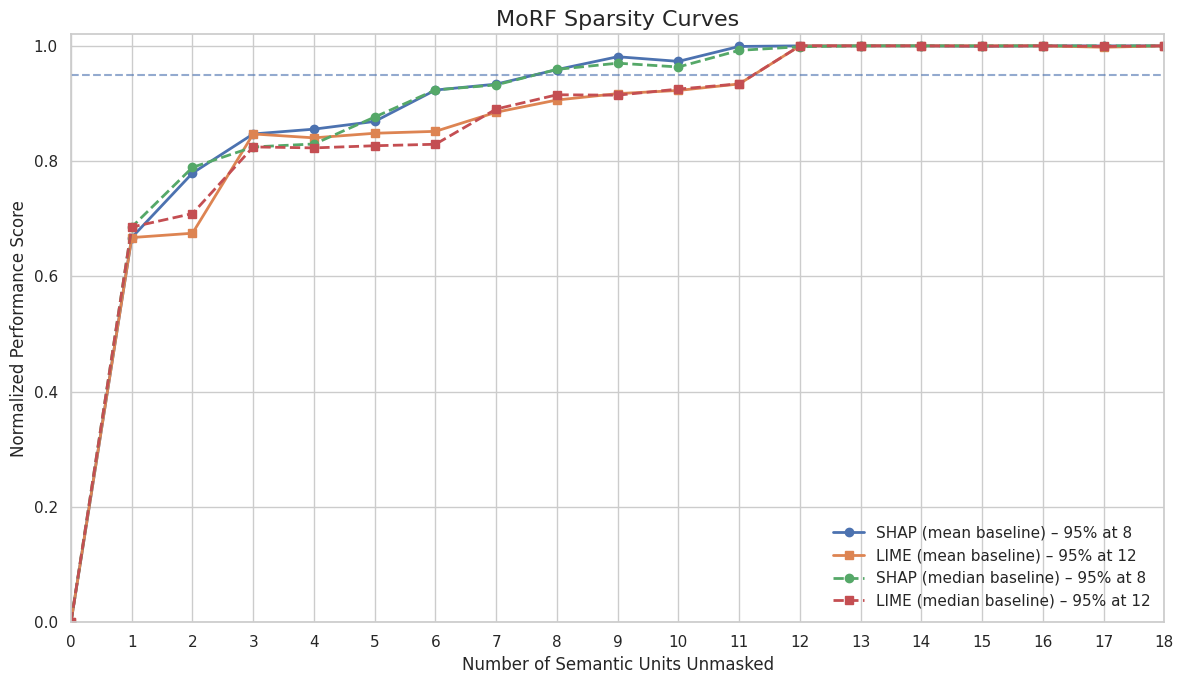

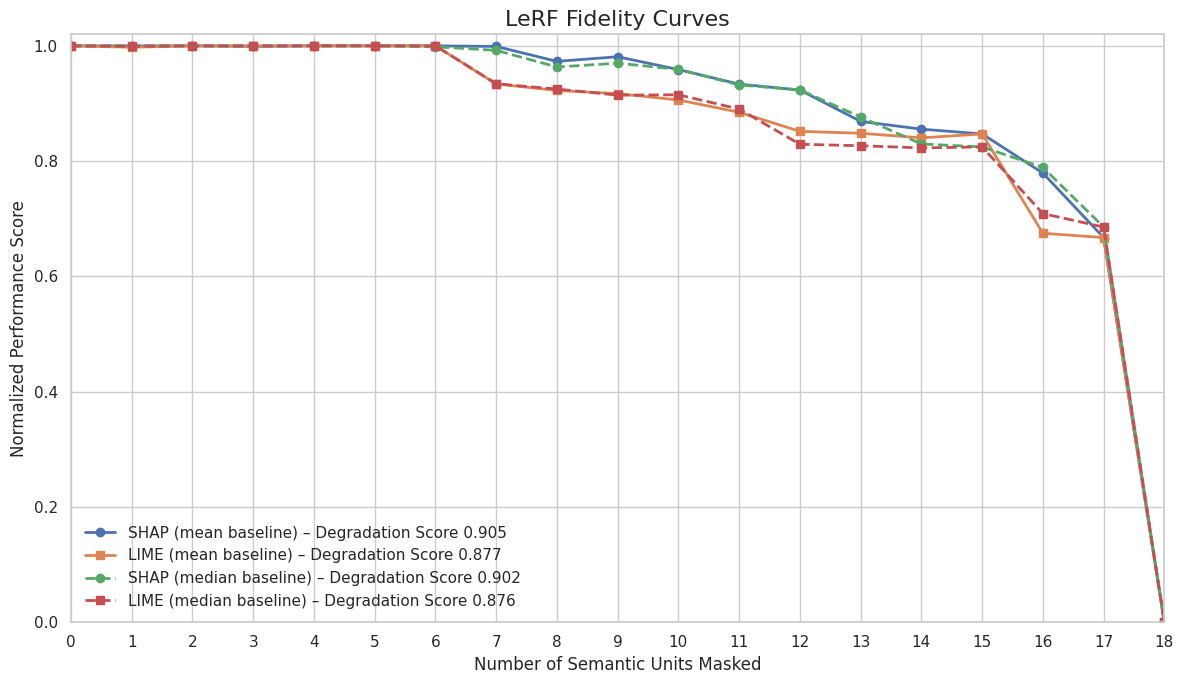

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# =========
# Helpers
# =========
def auc_over_units(df, n_units):
    return np.trapz(y=df["score"], x=df["step"] / n_units)

def get_95_threshold(df):
    hit = df[df["score"] >= 0.95]
    return int(hit.iloc[0]["step"]) if not hit.empty else int(df["step"].max())

# semantic units count (same for all runs)
n_units = int(max(morf_shap["step"].max(),
                  morf_lime["step"].max(),
                  morf_shap_med["step"].max(),
                  morf_lime_med["step"].max()))
# usually equals len(shap_entities) == 18, but this is robust
print("Units:", n_units)

# =========
# 1) MoRF ONLY — Mean vs Median (SHAP + LIME together)
# =========
s95_mean = get_95_threshold(morf_shap)
l95_mean = get_95_threshold(morf_lime)
s95_med  = get_95_threshold(morf_shap_med)
l95_med  = get_95_threshold(morf_lime_med)

plt.figure(figsize=(12, 7))
plt.plot(morf_shap["step"], morf_shap["score"], marker="o", lw=2,
         label=f"SHAP (mean baseline) – 95% at {s95_mean}")
plt.plot(morf_lime["step"], morf_lime["score"], marker="s", lw=2,
         label=f"LIME (mean baseline) – 95% at {l95_mean}")

plt.plot(morf_shap_med["step"], morf_shap_med["score"], marker="o", lw=2, ls="--",
         label=f"SHAP (median baseline) – 95% at {s95_med}")
plt.plot(morf_lime_med["step"], morf_lime_med["score"], marker="s", lw=2, ls="--",
         label=f"LIME (median baseline) – 95% at {l95_med}")

plt.axhline(0.95, linestyle="--", alpha=0.6)
plt.title("MoRF Sparsity Curves", fontsize=16)
plt.xlabel("Number of Semantic Units Unmasked")
plt.ylabel("Normalized Performance Score")
plt.xticks(range(0, n_units + 1))
plt.xlim(0, n_units)
plt.ylim(0, 1.02)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# =========
# 2) LeRF ONLY — Mean vs Median (SHAP + LIME together)
# =========
auc_s_mean = auc_over_units(lerf_shap, n_units)
auc_l_mean = auc_over_units(lerf_lime, n_units)
auc_s_med  = auc_over_units(lerf_shap_med, n_units)
auc_l_med  = auc_over_units(lerf_lime_med, n_units)

plt.figure(figsize=(12, 7))
plt.plot(lerf_shap["step"], lerf_shap["score"], marker="o", lw=2,
         label=f"SHAP (mean baseline) – Degradation Score {auc_s_mean:.3f}")
plt.plot(lerf_lime["step"], lerf_lime["score"], marker="s", lw=2,
         label=f"LIME (mean baseline) – Degradation Score {auc_l_mean:.3f}")

plt.plot(lerf_shap_med["step"], lerf_shap_med["score"], marker="o", lw=2, ls="--",
         label=f"SHAP (median baseline) – Degradation Score {auc_s_med:.3f}")
plt.plot(lerf_lime_med["step"], lerf_lime_med["score"], marker="s", lw=2, ls="--",
         label=f"LIME (median baseline) – Degradation Score {auc_l_med:.3f}")

plt.title("LeRF Fidelity Curves", fontsize=16)
plt.xlabel("Number of Semantic Units Masked")
plt.ylabel("Normalized Performance Score")
plt.xticks(range(0, n_units + 1))
plt.xlim(0, n_units)
plt.ylim(0, 1.02)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
import numpy as np

# =========================
# Baseline table for transparency
# =========================
# Assumes you already have:
#   X_full_train, X_test, dow_cols, promo_cols
# and you used k-1 reference (0.0) for one-hot blocks + holiday_flag = 0.0

# Align train to test columns (prevents leakage / mismatch)
X_train_aligned = X_full_train[X_test.columns].copy()

# Compute baselines on TRAIN ONLY
mean_vals = X_train_aligned.mean(numeric_only=True)
median_vals = X_train_aligned.median(numeric_only=True)

# Start with statistical baselines
baseline_mean = mean_vals.to_dict()
baseline_median = median_vals.to_dict()

# Apply your categorical block rule: k-1 reference category -> all zeros
for col in dow_cols + promo_cols:
    baseline_mean[col] = 0.0
    baseline_median[col] = 0.0

# Binary flag rule
if "holiday_flag" in X_test.columns:
    baseline_mean["holiday_flag"] = 0.0
    baseline_median["holiday_flag"] = 0.0

# Build audit table
audit = pd.DataFrame({
    "Feature Name": X_test.columns,
    "Train Mean": [float(mean_vals[c]) for c in X_test.columns],
    "Train Median": [float(median_vals[c]) for c in X_test.columns],
    "Primary Baseline (Mean scheme)": [float(baseline_mean[c]) for c in X_test.columns],
    "Robustness Baseline (Median scheme)": [float(baseline_median[c]) for c in X_test.columns],
})

# Add a readable "group / rule" column (optional but useful)
def baseline_rule(col: str) -> str:
    if col in dow_cols:
        return "DOW one-hot block (k-1 ref -> 0)"
    if col in promo_cols:
        return "Promo one-hot block (k-1 ref -> 0)"
    if col == "holiday_flag":
        return "Binary flag (forced 0)"
    return "Continuous/statistical (train mean/median)"

audit["Rule"] = [baseline_rule(c) for c in audit["Feature Name"]]

# Format: keep consistent precision for reporting
for c in ["Train Mean", "Train Median", "Primary Baseline (Mean scheme)", "Robustness Baseline (Median scheme)"]:
    audit[c] = audit[c].map(lambda x: f"{x:.4f}")

# Optional: order so categorical blocks appear together
audit = audit.sort_values(
    by="Rule",
    key=lambda s: s.map({
        "DOW one-hot block (k-1 ref -> 0)": 0,
        "Promo one-hot block (k-1 ref -> 0)": 1,
        "Binary flag (forced 0)": 2,
        "Continuous/statistical (train mean/median)": 3
    }).fillna(9)
).reset_index(drop=True)

# Show in notebook
display(audit)

# Export for LaTeX / appendix
audit.to_csv("marginalization_baseline_audit.csv", index=False)

# If you want LaTeX output quickly (requires booktabs in LaTeX)
latex_table = audit.to_latex(index=False, escape=True)  # escape=True handles underscores
with open("marginalization_baseline_audit.tex", "w") as f:
    f.write(latex_table)

print("✅ Saved: marginalization_baseline_audit.csv and marginalization_baseline_audit.tex")


,Feature Name,Train Mean,Train Median,Primary Baseline (Mean scheme),Robustness Baseline (Median scheme),Rule
0,dow_4,0.1446,0.0000,0.0000,0.0000,DOW one-hot block (k-1 ref -> 0)
1,dow_3,0.1446,0.0000,0.0000,0.0000,DOW one-hot block (k-1 ref -> 0)
2,dow_5,0.1446,0.0000,0.0000,0.0000,DOW one-hot block (k-1 ref -> 0)
3,dow_6,0.1446,0.0000,0.0000,0.0000,DOW one-hot block (k-1 ref -> 0)
4,dow_2,0.1325,0.0000,0.0000,0.0000,DOW one-hot block (k-1 ref -> 0)
5,dow_1,0.1446,0.0000,0.0000,0.0000,DOW one-hot block (k-1 ref -> 0)
6,promo_strategy_Non-Price Promo,0.0078,0.0000,0.0000,0.0000,Promo one-hot block (k-1 ref -> 0)
7,promo_strategy_Price Penetration,0.1468,0.0000,0.0000,0.0000,Promo one-hot block (k-1 ref -> 0)
8,promo_strategy_Standard Discount,0.3758,0.0000,0.0000,0.0000,Promo one-hot block (k-1 ref -> 0)
9,holiday_flag,0.3494,0.0000,0.0000,0.0000,Binary flag (forced 0)


✅ Saved: marginalization_baseline_audit.csv and marginalization_baseline_audit.tex
